In [148]:
import scipy         
import datetime
from scipy.linalg import expm,det
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit
from scipy.integrate import solve_ivp,odeint
from functools import reduce


In [149]:
L = 7 #system size
l=1 #spin length
M = 0.1
m_epsilon = 0
N=3
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [150]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
        0.         |2 2 2 2 2 2 2>           2186  
        1.         |2 2 2 2 2 2 1>           2185  
        2.         |2 2 2 2 2 2 0>           2184  
        3.         |2 2 2 2 2 1 2>           2183  
        4.         |2 2 2 2 2 1 1>           2182  
        5.         |2 2 2 2 2 1 0>           2181  
        6.         |2 2 2 2 2 0 2>           2180  
        7.         |2 2 2 2 2 0 1>           2179  
        8.         |2 2 2 2 2 0 0>           2178  
        9.         |2 2 2 2 1 2 2>           2177  
       10.         |2 2 2 2 1 2 1>           2176  
       11.         |2 2 2 2 1 2 0>           2175  
       12.         |2 2 2 2 1 1 2>           2174  
       13.         |2 2 2 2 1 1 1>           2173  
       14.         |2 2 2 2 1 1 0>           2172  
       15.         |2 2 2 2 1 0 2>           2171  
       16.         |2 2 2 2 1 0 1>           2170  
       17.         |2 2 2 2 1 0 0>           21

In [151]:
#initialisation of the Gauss laws
LL = 5 #number of sites-1
liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []
z_comp_minf = [[-m_epsilon,0]]
z_comp_pinf = [[m_epsilon,L-1]]

for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    
    
gauss_law_map.append([
    ["z",liste[0]],
    ["z",liste[5]],
])

gauss_law_map.append([
    ["z",liste[1]],
    ["z",liste[6]],
    ["z",liste_m[0]],
    ["I",liste[1]],
])

gauss_law_map.append([
    ["z",liste[2]],
    ["z",liste_m[1]],
])

gauss_law_map.append([
    ["z",liste_m[3]],
    ["z",liste_m[2]],
    ["I",liste[3]],
])

gauss_law_map.append([
    ["z",liste[3]],
    ["z",liste_m[4]],
    ["z",liste_m[6]],

])

gauss_law_map.append([
    ["z",liste[4]],
    ["z",liste_m[5]],
    ["I",liste[5]],

])
for i in range(LL+1):
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(LL+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [152]:
B = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(4*l+1)
b[2*l+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(4*3+1)
for i in range(4*l+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 0. 0. 1. 0.]


In [153]:
C = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(4*l+1)
c[2*l] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(4*3+1)
for i in range(4*l+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [154]:
#projectors on g=1 for every site
Proj = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(LL+1)]
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [155]:
A = np.zeros((2*l+1,2*l+1))
for i in range(2*l+1):
    for j in range(2*l+1):
        A[i][j] = (-l+i)**j
a = np.zeros(2*l+1)
for i in range(2*l+1):
    a[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,a)
x = np.zeros(2*3+1)
for i in range(2*l+1):
    x[i] = solution[i]
print(x)

[ 1.  0. -2.  0.  0.  0.  0.]


In [156]:
D = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        D[i][j] = (-2*l+i)**j
d = np.zeros(4*l+1)
d[2*l] = 1.
solution = scipy.linalg.solve(D,d)
dd = np.zeros(4*3+1)
for i in range(4*l+1):
    dd[i] = solution[i]
print(dd)
print(d)

[ 1.    0.   -1.25 -0.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [157]:
E = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        E[i][j] = (-2*l+i+1)**j
e = np.zeros(4*l+1)
e[2*l-1] = 1.
solution = scipy.linalg.solve(E,e)
ee = np.zeros(4*3+1)
for i in range(4*l+1):
    ee[i] = solution[i]
print(ee)
print(e)

[ 1.         -0.83333333 -0.83333333  0.83333333 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 1. 0. 0. 0.]


In [158]:
#projectors on g=0 for every site
Proj_0 = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(LL+1)]
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj_0[2*i] += dd[j]*gauss_law_matrix[2*i]**j
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj_0[2*i+1] += ee[j]*gauss_law_matrix[2*i+1]**j

In [159]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []
quartic_term = []
quintic_term = []
sextic_term = []

interaction_p = []
interaction_m = []

phase = []
phase_ham = []

link_p = []
link_p_ham = []

link_m = []
link_m_ham = []

for i in range(L):
    const_term.append([[x[0],i]])
    linear_term.append([[x[1],i]])
    quadratic_term.append([[x[2],i,i]])
    cubic_term.append([[x[3],i,i,i]])
    quartic_term.append([[x[4],i,i,i,i]])
    quintic_term.append([[x[5],i,i,i,i,i]])
    sextic_term.append([[x[6],i,i,i,i,i,i]])


    phase.append([
        ["I", const_term[i]],
        ["z", linear_term[i]],
        ["zz", quadratic_term[i]],
        ["zzz", cubic_term[i]],
        ["zzzz", quartic_term[i]],
        ["zzzzz", quintic_term[i]],
        ["zzzzzz", sextic_term[i]],

    ])
    
    link_p.append([
    ["+",[[1./np.sqrt(l*(l+1)),i]]]  
    ])      
    
    link_m.append([
    ["-",[[1./np.sqrt(l*(l+1)),i]]]           
        
    ])
    
    phase_ham.append(hamiltonian(phase[i],dynamic_list=[],basis=basis,**no_checks))
    link_p_ham.append(hamiltonian(link_p[i],dynamic_list=[],basis=basis,**no_checks))
    link_m_ham.append(hamiltonian(link_m[i],dynamic_list=[],basis=basis,**no_checks))


    


kin_energy = [[0.5,i,i] for i in range(L)]

mass_term = []
mass_term.append([2*(-1)**0*M,0])
mass_term.append([2*(-1)**1*M,1])
mass_term.append([2*(-1)**0*M,2])
mass_term.append([2*(-1)**0*M,3])
mass_term.append([2*(-1)**1*M,4])
mass_term.append([2*(-1)**0*M,5])
mass_term.append([2*(-1)**1*M,6])

kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

interaction = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(L)]

interaction[0] = -0.5*(Proj[0]@phase_ham[0].tocsc()@link_p_ham[0].tocsc()@Proj[1]+Proj[1]@link_m_ham[0].tocsc()@phase_ham[0].tocsc()@Proj[0])
interaction[1] = 0.5*(Proj[1]@phase_ham[1].tocsc()@link_p_ham[1].tocsc()@Proj[2]+Proj[2]@link_m_ham[1].tocsc()@phase_ham[1].tocsc()@Proj[1])
interaction[2] = -0.5*(Proj[2]@phase_ham[2].tocsc()@link_p_ham[2].tocsc()@Proj[3]+Proj[3]@link_m_ham[2].tocsc()@phase_ham[2].tocsc()@Proj[2])
interaction[3] = -0.5*(Proj[4]@phase_ham[2].tocsc()@phase_ham[3].tocsc()@link_p_ham[3].tocsc()@Proj[3]+Proj[3]@link_m_ham[3].tocsc()@phase_ham[3].tocsc()@phase_ham[2].tocsc()@Proj[4])
interaction[4] = 0.5*(Proj[5]@phase_ham[4].tocsc()@phase_ham[6].tocsc()@link_p_ham[4].tocsc()@Proj[4]+Proj[4]@link_m_ham[4].tocsc()@phase_ham[4].tocsc()@phase_ham[6].tocsc()@Proj[5])
interaction[5] = -0.5*(Proj[0]@phase_ham[0].tocsc()@phase_ham[5].tocsc()@link_p_ham[5].tocsc()@Proj[5]+Proj[5]@link_m_ham[5].tocsc()@phase_ham[5].tocsc()@phase_ham[0].tocsc()@Proj[0])
interaction[6] = 0.5*(Proj[1]@phase_ham[1].tocsc()@phase_ham[6].tocsc()@link_p_ham[6].tocsc()@Proj[4]+Proj[4]@link_m_ham[6].tocsc()@phase_ham[6].tocsc()@phase_ham[1].tocsc()@Proj[1])

plaquette = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(4)]

plaquette[0] = 0.5*(Proj_0[5]@phase_ham[0].tocsc()@phase_ham[6].tocsc()@phase_ham[4].tocsc()@phase_ham[5].tocsc()@link_p_ham[0].tocsc()@link_p_ham[6].tocsc()@link_m_ham[4].tocsc()@link_m_ham[5].tocsc()@Proj_0[5]+Proj_0[5]@link_p_ham[4].tocsc()@link_p_ham[5].tocsc()@link_m_ham[0].tocsc()@link_m_ham[6].tocsc()@phase_ham[0].tocsc()@phase_ham[6].tocsc()@phase_ham[4].tocsc()@phase_ham[5].tocsc()@Proj_0[5])
plaquette[1] = -0.5*(Proj[5]@phase_ham[0].tocsc()@phase_ham[6].tocsc()@phase_ham[4].tocsc()@phase_ham[5].tocsc()@link_p_ham[0].tocsc()@link_p_ham[6].tocsc()@link_m_ham[4].tocsc()@link_m_ham[5].tocsc()@Proj[5]+Proj[5]@link_p_ham[4].tocsc()@link_p_ham[5].tocsc()@link_m_ham[0].tocsc()@link_m_ham[6].tocsc()@phase_ham[0].tocsc()@phase_ham[6].tocsc()@phase_ham[4].tocsc()@phase_ham[5].tocsc()@Proj[5])
plaquette[2] = -0.5*(Proj_0[4]@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@phase_ham[6].tocsc()@link_p_ham[1].tocsc()@link_p_ham[2].tocsc()@link_m_ham[3].tocsc()@link_m_ham[6].tocsc()@Proj_0[4]+Proj_0[4]@link_p_ham[3].tocsc()@link_p_ham[6].tocsc()@link_m_ham[1].tocsc()@link_m_ham[2].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@phase_ham[6].tocsc()@Proj_0[4])
plaquette[3] = 0.5*(Proj[4]@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@phase_ham[6].tocsc()@link_p_ham[1].tocsc()@link_p_ham[2].tocsc()@link_m_ham[3].tocsc()@link_m_ham[6].tocsc()@Proj[4]+Proj[4]@link_p_ham[3].tocsc()@link_p_ham[6].tocsc()@link_m_ham[1].tocsc()@link_m_ham[2].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@phase_ham[6].tocsc()@Proj[4])

h_plaq = 0

for i in range(4):
    h_plaq += plaquette[i]

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_plaq + h_int #Spin-1 Hamiltonian without the local contstaints

for i in range(LL+1):
    full_ham_matrix = (Proj_0[i]+Proj[i])@full_ham_matrix@(Proj_0[i]+Proj[i])

G=0
for i in range(LL+1):
    G += 0.6*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= full_ham_matrix + constraint_full_matrix #Spin-1 Hamiltonian with the local contstaints as a penalty term


In [160]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(full_ham_matrix,k = 3,which = "SA")
string = ""
print(eigenval[eigenval<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvec[:,0][i])>=1e-5:
        string+=str(eigenvec[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"

[-1.6209751  -0.89907721 -0.7386169 ]


In [161]:
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")


In [162]:
#Gauge invariant part of the spectrum
string = ""
print(eigenvalues[eigenvalues<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])>=1e-4:
        string+=str(eigenvectors[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)


[-1.6209751  -0.89907721 -0.7386169 ]
(0.03045027309497814-0.000548693162353141j)|2 2 2 1 1 1 1>
(0.028315734873034362-0.0005102302387695709j)|2 2 2 1 1 1 0>
(-0.02312519333507092+0.00041670021879565894j)|2 2 2 1 0 1 1>
(0.019265927464440474-0.000347158878778548j)|2 2 2 1 0 0 1>
(-0.0462674244938357+0.0008337074475591129j)|2 2 2 0 1 1 0>
(0.021391582175242407-0.0003854617275474486j)|2 2 2 0 0 1 1>
(-0.013064308436307256+0.00023540993171146396j)|2 2 2 0 0 1 0>
(-0.03499645848305006+0.0006306123237830255j)|2 2 2 0 0 0 1>
(-0.0054977494149407455+9.906569648495807e-05j)|2 2 2 0 0 0 0>
(0.10212752512106826-0.0018402683794410837j)|2 1 2 1 1 1 1>
(0.018584061109096807-0.00033487211190192794j)|2 1 2 1 0 1 2>
(-0.04474829528864856+0.0008063337749156172j)|2 1 2 1 0 1 1>
(-0.04534983842629036+0.000817173172165779j)|2 1 2 1 0 0 2>
(-0.0020381021202818947+3.672521077442848e-05j)|2 1 2 1 0 0 1>
(0.023125193335070814-0.00041670021879586586j)|2 1 2 0 0 1 1>
(-0.019265927464440134+0.0003471588787785168

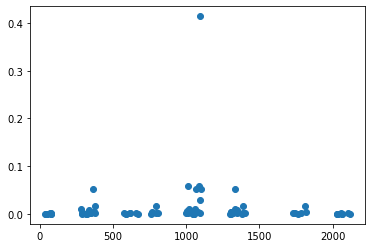

In [163]:
yy = []
xx = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])**2>=1e-4:
        yy.append(np.abs(eigenvectors[:,0][i])**2) 
        xx.append(i)
plt.plot(xx,yy, "o")

In [164]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def rot_sigma_e(i,j,phi,theta):
    sigma_e = sparse.identity(basis.Ns,dtype = complex)
    sigma_e = rot_sigma(0,i,j,phi,theta)@rot_sigma(3,i,j,phi,theta)
    return(sigma_e)

def rot_sigma_o(i,j,phi,theta):
    sigma_o = sparse.identity(basis.Ns,dtype = complex)
    sigma_o = rot_sigma(1,i,j,phi,theta)@rot_sigma(2,i,j,phi,theta)
    return(sigma_o)



def sigma(k,i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    if k==0:
        tensprod = sigma
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,sigma)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def sigma_e(i,j,phi):
    sigma_e = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_e = sparse.csc_matrix(sigma_e)
    sigma_e = sigma(0,i,j,phi) + sigma(3,i,j,phi)
    return sigma_e

def sigma_o(i,j,phi):
    sigma_o = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_o = sparse.csc_matrix(sigma_o)
    sigma_o = sigma(1,i,j,phi) + sigma(2,i,j,phi)
    return sigma_o


In [165]:
def swap(m,n):
    swap_matrix = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    swap_matrix = sparse.csc_matrix(swap_matrix)
    for i in range(basis.Ns):
        state_m = basis.int_to_state(basis.Ns-i-1)[2*m+1]
        state_n = basis.int_to_state(basis.Ns-i-1)[2*n+1]
        string = list(basis.int_to_state(basis.Ns-i-1))
        string[2*m+1],string[2*n+1] = state_n,state_m
        string = "".join(string)
        string = string.replace(" ", "")
        string = string.replace("|","")
        string = string.replace(">", "")
        i_new = basis.Ns-1-basis.state_to_int(string)
        swap_matrix[i_new,i] = 1.
        
    return swap_matrix


def exp_gate(k,theta):
    Matrix = np.zeros((9,9),dtype = complex)
    Matrix = sparse.csc_matrix(Matrix)
    Matrix[8-0,8-0] = np.cos(theta/2)
    Matrix[8-1,8-1] = np.cos(theta/2)
    Matrix[8-2,8-2] = 0

    Matrix[8-3,8-3] = np.cos(theta/2)
    Matrix[8-4,8-4] = np.cos(theta/2)
    Matrix[8-5,8-5] = 0

    Matrix[8-6,8-6] = -np.cos(theta/2)
    Matrix[8-7,8-7] = np.cos(theta/2)
    Matrix[8-8,8-8] = -1j

    Matrix[8-0,8-4] = -1j*np.sin(theta/2)
    Matrix[8-4,8-0] = -1j*np.sin(theta/2)

    Matrix[8-1,8-3] = -1j*np.sin(theta/2)
    Matrix[8-3,8-1] = -1j*np.sin(theta/2)


    Matrix[8-5,8-2] = -1
    Matrix[8-2,8-5] = -1

    Matrix[8-6,8-7] = np.sin(theta/2)
    Matrix[8-7,8-6] = np.sin(theta/2)

    if k == 0:
        Matrix_full = scipy.sparse.kron(Matrix,sparse.identity(3**(L-2)))
    
    else:
        Matrix_full = scipy.sparse.kron(sparse.identity(3**k),Matrix)
        Matrix_full = scipy.sparse.kron(Matrix_full,sparse.identity(3**((L-2)-k)))

    #return swap(0,k)@swap(1,k+1)@Matrix_full@swap(0,k+1)@swap(1,k)
    return Matrix_full

In [166]:
def exp_gate_der(k,theta):
    Matrix = np.zeros((9,9),dtype = complex)
    Matrix = sparse.csc_matrix(Matrix)
    Matrix[8-0,8-0] = -np.sin(theta/2)/2
    Matrix[8-1,8-1] = -np.sin(theta/2)/2

    Matrix[8-3,8-3] = -np.sin(theta/2)/2
    Matrix[8-4,8-4] = -np.sin(theta/2)/2

    Matrix[8-6,8-6] = np.sin(theta/2)/2
    Matrix[8-7,8-7] = -np.sin(theta/2)/2

    Matrix[8-0,8-4] = -1j*np.cos(theta/2)/2
    Matrix[8-4,8-0] = -1j*np.cos(theta/2)/2

    Matrix[8-1,8-3] = -1j*np.cos(theta/2)/2
    Matrix[8-3,8-1] = -1j*np.cos(theta/2)/2



    Matrix[8-6,8-7] = np.cos(theta/2)/2
    Matrix[8-7,8-6] = np.cos(theta/2)/2
    
    if k == 0:
        Matrix_full = scipy.sparse.kron(Matrix,sparse.identity(3**(L-2)))
    
    else:
        Matrix_full = scipy.sparse.kron(sparse.identity(3**k),Matrix)
        Matrix_full = scipy.sparse.kron(Matrix_full,sparse.identity(3**((L-2)-k)))

    #return swap(0,k)@swap(1,k+1)@Matrix_full@swap(0,k+1)@swap(1,k)
    return Matrix_full




In [167]:
%time exp_gate_der(0,np.pi/3)

CPU times: user 5.36 ms, sys: 7.99 ms, total: 13.3 ms
Wall time: 10.3 ms


/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


<2187x2187 sparse matrix of type '<class 'numpy.complex128'>'
	with 2916 stored elements in COOrdinate format>

In [168]:
#initial state
string = ""
for i in range(L):
    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string)
psi_0[i_0] = 1.

In [169]:
def R(i,theta):
    
    if i%27 == 0:
        return(exp_gate(0,theta))

    if i%27 == 1:
        return(exp_gate(1,theta))

    if i%27 == 2:
        return(exp_gate(2,theta))
    
    if i%27 == 3:
        return(exp_gate(3,theta))

    if i%27 == 4:
        return(exp_gate(4,theta))

    if i%27 == 5:
        return(exp_gate(5,theta))

    if i%27 == 6:
        return(rot_sigma(0,0,1,0,theta))


    if i%27 == 7:
        return(rot_sigma(0,0,2,0,theta))

    
    if i%27 == 8:
        return(rot_sigma(0,1,2,np.pi/2,theta))

    
    if i%27 == 9:
        return(rot_sigma(1,0,1,0,theta))


    if i%27 == 10:
        return(rot_sigma(1,0,2,0,theta))

    
    if i%27 == 11:
        return(rot_sigma(1,1,2,np.pi/2,theta))

    if i%27 == 12:
        return(rot_sigma(2,0,1,0,theta))


    if i%27 == 13:
        return(rot_sigma(2,0,2,0,theta))

    
    if i%27 == 14:
        return(rot_sigma(2,1,2,np.pi/2,theta))

    
    if i%27 == 15:
        return(rot_sigma(3,0,1,0,theta))


    if i%27 == 16:
        return(rot_sigma(3,0,2,0,theta))

    
    if i%27 == 17:
        return(rot_sigma(3,1,2,np.pi/2,theta))
    
    if i%27 == 18:
        return(rot_sigma(4,0,1,0,theta))


    if i%27 == 19:
        return(rot_sigma(4,0,2,0,theta))

    
    if i%27 == 20:
        return(rot_sigma(4,1,2,np.pi/2,theta))     

    if i%27 == 21:
        return(rot_sigma(5,0,1,0,theta))


    if i%27 == 22:
        return(rot_sigma(5,0,2,0,theta))

    
    if i%27 == 23:
        return(rot_sigma(5,1,2,np.pi/2,theta))
    
    if i%27 == 24:
        return(rot_sigma(6,0,1,0,theta))


    if i%27 == 25:
        return(rot_sigma(6,0,2,0,theta))

    
    if i%27 == 26:
        return(rot_sigma(6,1,2,np.pi/2,theta))

def S(i,theta):
    
    if i%27 == 0:
        return(exp_gate_der(0,theta)@exp_gate(0,theta).T.conj())

    if i%27 == 1:
        return(exp_gate_der(1,theta)@exp_gate(1,theta).T.conj())
    
    if i%27 == 2:
        return(exp_gate_der(2,theta)@exp_gate(2,theta).T.conj())

    if i%27 == 3:
        return(exp_gate_der(3,theta)@exp_gate(3,theta).T.conj())

    if i%27 == 4:
        return(exp_gate_der(4,theta)@exp_gate(4,theta).T.conj())
    
    if i%27 == 5:
        return(exp_gate_der(5,theta)@exp_gate(5,theta).T.conj())

    if i%27 == 6:
        return(-1j*sigma(0,0,1,0))

    
    if i%27 == 7:
        return(-1j*sigma(0,0,2,0))

    
    if i%27 == 8:
        return(-1j*sigma(0,1,2,np.pi/2))
     
    if i%27 == 9:
        return(-1j*sigma(1,0,1,0))

    
    if i%27 == 10:
        return(-1j*sigma(1,0,2,0))

    
    if i%27 == 11:
        return(-1j*sigma(1,1,2,np.pi/2))

     
    if i%27 == 12:
        return(-1j*sigma(2,0,1,0))

    
    if i%27 == 13:
        return(-1j*sigma(2,0,2,0))
    

    if i%27 == 14:
        return(-1j*sigma(2,1,2,np.pi/2))
    
     
    if i%27 == 15:
        return(-1j*sigma(3,0,1,0))

    
    if i%27 == 16:
        return(-1j*sigma(3,0,2,0))
    

    if i%27 == 17:
        return(-1j*sigma(3,1,2,np.pi/2))

    if i%27 == 18:
        return(-1j*sigma(4,0,1,0))

    
    if i%27 == 19:
        return(-1j*sigma(4,0,2,0))
    

    if i%27 == 20:
        return(-1j*sigma(4,1,2,np.pi/2))
    
    if i%27 == 21:
        return(-1j*sigma(5,0,1,0))

    
    if i%27 == 22:
        return(-1j*sigma(5,0,2,0))
    

    if i%27 == 23:
        return(-1j*sigma(5,1,2,np.pi/2))
    
    if i%27 == 24:
        return(-1j*sigma(6,0,1,0))

    
    if i%27 == 25:
        return(-1j*sigma(6,0,2,0))
    

    if i%27 == 26:
        return(-1j*sigma(6,1,2,np.pi/2))

In [170]:
coeff = 27
stepp = 600
t_final = 30

In [171]:
expt_value = []
energyy = []

time_domain = np.linspace(0, t_final, stepp)

Y = []

In [172]:
for kkk in range(3):
    
    N=kkk+1
    start_point = np.random.rand(coeff*N)

    matr = full_ham_matrix.toarray()
    B = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]
    psi_d = [np.zeros(basis.Ns,dtype = complex) for i in range(coeff*N)]
    psi_d_1 = [np.zeros(basis.Ns,dtype = complex) for i in range(coeff*N)]
    psi_d_s1 = [np.zeros(basis.Ns,dtype = complex) for i in range(coeff*N)]
    psi_d_s2 = [np.zeros(basis.Ns,dtype = complex) for i in range(coeff*N)]

    def rhs(t,theta):

        print(datetime.datetime.now())
        for k in range(coeff*N):
            B[k] = R(k,theta[k])

        psi_b = psi_0
        for k in range(coeff*N):
            psi_b = B[coeff*N-1-k]@psi_b

        for i in range(LL+1):
            psi_b = (Proj[i]+Proj_0[i])@psi_b
        norm_b = np.sqrt(np.real(np.conj(psi_b)@psi_b))
        psi_b = psi_b/norm_b



        psi_conj_b = np.conj(psi_b)

        print("start",datetime.datetime.now())

        for k in range(coeff*N):
            B[k] = S(k,theta[k])@R(k,theta[k])
            psi_d[k] = psi_0
            for i in range(coeff*N):
                psi_d[k] = B[coeff*N-1-i]@psi_d[k]
            B[k] = R(k,theta[k])

        print("stop_reduce",datetime.datetime.now())

        psi_conj_d = np.conj(psi_d)


        for k in range(coeff*N):
            for i in range(LL+1):
                psi_d_1[k] = (Proj[i]+Proj_0[i])@psi_d[k]  
            psi_d_s1[k] = psi_d_1[k]/norm_b
            psi_d_s2[k] = -psi_b*(psi_conj_d[k]@psi_b+psi_conj_b@psi_d[k])
            psi_d[k] = psi_d_s1[k]+psi_d_s2[k]

        psi_conj_d = np.conj(psi_d)




        X = np.zeros((coeff*N,coeff*N),dtype = complex)
        Y = np.zeros(coeff*N,dtype = complex)


        X = np.einsum("in,jn->ij",psi_conj_d,psi_d)

        Y = np.einsum("il,ln,n->i",psi_conj_d,matr,psi_b)

        XX = np.einsum("il,l->i",psi_conj_d,psi_b)

        YY_1 = np.einsum("n,in->i",psi_conj_b,psi_d)

        YY_2 = np.einsum("i,ij,j",psi_conj_b,matr,psi_b)
        YY = YY_1*YY_2
        XX = np.outer(XX,XX)
        X_r = 2*np.real(X+XX)
        Y_i = 2*np.real(Y+YY)
        result = -np.linalg.pinv(X_r,rcond = 1e-6)@Y_i
        print(datetime.datetime.now())

        print(t)

        return result

    # RK-4 method
    def rk4(x0,y0,xn,n):
        global Y

        # Calculating step size
        h = (xn-x0)/n

        #print('\n--------SOLUTION--------')
        #print('-------------------------')    
        #print('x0\ty0\tyn')
        #print('-------------------------')
        for i in range(n):
            k1 = h * (rhs(x0, y0))
            k2 = h * (rhs((x0+h/2), (y0+k1/2)))
            k3 = h * (rhs((x0+h/2), (y0+k2/2)))
            k4 = h * (rhs((x0+h), (y0+k3)))
            k = (k1+2*k2+2*k3+k4)/6
            yn = y0 + k
            #print('%.4f\t%.4f\t%.4f'% (x0,y0,yn) )
            #print('-------------------------')
            y0 = yn
            x0 = x0+h
            Y.append(y0)

        #print('\nAt x=%.4f, y=%.4f' %(xn,yn))

    # Inputs
    #print('Enter initial conditions:')
    #x0 = float(input('x0 = '))
    #y0 = float(input('y0 = '))

    #print('Enter calculation point: ')
    #xn = float(input('xn = '))

    #print('Enter number of steps:')
    #step = int(input('Number of steps = '))

    # RK4 method call
    #start_point = 0.001*np.ones(coeff*N)




    Y = []
    #start_point = np.zeros(coeff*N)

    rk4(0,start_point,t_final,stepp)
    def var_ansatz(theta,psi_0):
        psi = psi_0
        for i in range(coeff*N):
            psi = R(coeff*N-1-i,theta[coeff*N-1-i])@psi

        return psi
    psi = var_ansatz(start_point,psi_0)
    psi_ground = eigenvec[:,0]
    expt_value_u = np.zeros(len(time_domain))
    energy = np.zeros(len(time_domain))

    psi = var_ansatz(start_point,psi_0)
    for tt in range(len(time_domain)):
        theta = []
        for i in range(coeff*N):
            theta.append(Y[tt][i])


        psi_var = var_ansatz(theta,psi_0)
        for i in range(LL+1):
            psi_var = (Proj[i]+Proj_0[i])@psi_var
        norm = np.sqrt(np.real(np.conj(psi_var)@psi_var))

        expt_value_u[tt] = np.abs(np.conj(psi_var)@psi_ground/norm)**2
        energy[tt] = np.real(np.conj(psi_var)@full_ham_matrix@psi_var/norm**2)
        
    expt_value.append(expt_value_u)
    energyy.append(energy)


    

2022-08-17 11:35:13.963972
start 2022-08-17 11:35:14.050595
stop_reduce 2022-08-17 11:35:14.299699
2022-08-17 11:35:14.658235
0
2022-08-17 11:35:14.658332
start 2022-08-17 11:35:14.740108
stop_reduce 2022-08-17 11:35:15.001240
2022-08-17 11:35:15.354705
0.025
2022-08-17 11:35:15.354813
start 2022-08-17 11:35:15.436479
stop_reduce 2022-08-17 11:35:15.687844
2022-08-17 11:35:16.046359
0.025
2022-08-17 11:35:16.046460
start 2022-08-17 11:35:16.128061
stop_reduce 2022-08-17 11:35:16.385492
2022-08-17 11:35:16.746689
0.05
2022-08-17 11:35:16.746796
start 2022-08-17 11:35:16.829479
stop_reduce 2022-08-17 11:35:17.081140
2022-08-17 11:35:17.431274
0.05
2022-08-17 11:35:17.431378
start 2022-08-17 11:35:17.513090
stop_reduce 2022-08-17 11:35:17.764345
2022-08-17 11:35:18.116591
0.07500000000000001
2022-08-17 11:35:18.116698
start 2022-08-17 11:35:18.198599
stop_reduce 2022-08-17 11:35:18.450901
2022-08-17 11:35:18.800856
0.07500000000000001
2022-08-17 11:35:18.800954
start 2022-08-17 11:35:18.8

stop_reduce 2022-08-17 11:35:55.353966
2022-08-17 11:35:55.706130
0.7500000000000001
2022-08-17 11:35:55.706230
start 2022-08-17 11:35:55.787852
stop_reduce 2022-08-17 11:35:56.034716
2022-08-17 11:35:56.384916
0.7750000000000001
2022-08-17 11:35:56.385017
start 2022-08-17 11:35:56.466318
stop_reduce 2022-08-17 11:35:56.714268
2022-08-17 11:35:57.067491
0.7750000000000001
2022-08-17 11:35:57.067589
start 2022-08-17 11:35:57.149206
stop_reduce 2022-08-17 11:35:57.396941
2022-08-17 11:35:57.746617
0.8000000000000002
2022-08-17 11:35:57.746724
start 2022-08-17 11:35:57.828367
stop_reduce 2022-08-17 11:35:58.075520
2022-08-17 11:35:58.426326
0.8000000000000002
2022-08-17 11:35:58.426445
start 2022-08-17 11:35:58.508339
stop_reduce 2022-08-17 11:35:58.756032
2022-08-17 11:35:59.106412
0.8250000000000002
2022-08-17 11:35:59.106513
start 2022-08-17 11:35:59.187799
stop_reduce 2022-08-17 11:35:59.435019
2022-08-17 11:35:59.784084
0.8250000000000002
2022-08-17 11:35:59.784183
start 2022-08-17 1

stop_reduce 2022-08-17 11:36:34.277156
2022-08-17 11:36:34.630251
1.4750000000000005
2022-08-17 11:36:34.630369
start 2022-08-17 11:36:34.712104
stop_reduce 2022-08-17 11:36:34.961565
2022-08-17 11:36:35.310974
1.4750000000000005
2022-08-17 11:36:35.311220
start 2022-08-17 11:36:35.392411
stop_reduce 2022-08-17 11:36:35.639685
2022-08-17 11:36:35.989413
1.5000000000000007
2022-08-17 11:36:35.989532
start 2022-08-17 11:36:36.071380
stop_reduce 2022-08-17 11:36:36.319423
2022-08-17 11:36:36.669004
1.5000000000000007
2022-08-17 11:36:36.669121
start 2022-08-17 11:36:36.750463
stop_reduce 2022-08-17 11:36:36.997833
2022-08-17 11:36:37.350087
1.5250000000000006
2022-08-17 11:36:37.350202
start 2022-08-17 11:36:37.431646
stop_reduce 2022-08-17 11:36:37.679067
2022-08-17 11:36:38.028864
1.5250000000000006
2022-08-17 11:36:38.028975
start 2022-08-17 11:36:38.110562
stop_reduce 2022-08-17 11:36:38.358185
2022-08-17 11:36:38.718347
1.5500000000000007
2022-08-17 11:36:38.718458
start 2022-08-17 1

stop_reduce 2022-08-17 11:37:13.757334
2022-08-17 11:37:14.115799
2.1750000000000003
2022-08-17 11:37:14.115910
start 2022-08-17 11:37:14.200094
stop_reduce 2022-08-17 11:37:14.450468
2022-08-17 11:37:14.815236
2.2
2022-08-17 11:37:14.815408
start 2022-08-17 11:37:14.903975
stop_reduce 2022-08-17 11:37:15.152634
2022-08-17 11:37:15.526383
2.2
2022-08-17 11:37:15.526485
start 2022-08-17 11:37:15.615856
stop_reduce 2022-08-17 11:37:15.886669
2022-08-17 11:37:16.271999
2.225
2022-08-17 11:37:16.272095
start 2022-08-17 11:37:16.364285
stop_reduce 2022-08-17 11:37:16.631594
2022-08-17 11:37:16.996469
2.225
2022-08-17 11:37:16.996583
start 2022-08-17 11:37:17.087842
stop_reduce 2022-08-17 11:37:17.345469
2022-08-17 11:37:17.701330
2.25
2022-08-17 11:37:17.701626
start 2022-08-17 11:37:17.785575
stop_reduce 2022-08-17 11:37:18.032838
2022-08-17 11:37:18.403220
2.25
2022-08-17 11:37:18.403311
start 2022-08-17 11:37:18.503927
stop_reduce 2022-08-17 11:37:18.779949
2022-08-17 11:37:19.140871
2.2

stop_reduce 2022-08-17 11:37:54.327155
2022-08-17 11:37:54.682116
2.8999999999999977
2022-08-17 11:37:54.682219
start 2022-08-17 11:37:54.766996
stop_reduce 2022-08-17 11:37:55.016863
2022-08-17 11:37:55.374194
2.9249999999999976
2022-08-17 11:37:55.374300
start 2022-08-17 11:37:55.459066
stop_reduce 2022-08-17 11:37:55.707388
2022-08-17 11:37:56.064489
2.9249999999999976
2022-08-17 11:37:56.064591
start 2022-08-17 11:37:56.149244
stop_reduce 2022-08-17 11:37:56.400168
2022-08-17 11:37:56.755169
2.9499999999999975
2022-08-17 11:37:56.755279
start 2022-08-17 11:37:56.840335
stop_reduce 2022-08-17 11:37:57.089987
2022-08-17 11:37:57.446395
2.9499999999999975
2022-08-17 11:37:57.446502
start 2022-08-17 11:37:57.532086
stop_reduce 2022-08-17 11:37:57.780066
2022-08-17 11:37:58.136136
2.9749999999999974
2022-08-17 11:37:58.136242
start 2022-08-17 11:37:58.221433
stop_reduce 2022-08-17 11:37:58.468898
2022-08-17 11:37:58.824857
2.9749999999999974
2022-08-17 11:37:58.824954
start 2022-08-17 1

stop_reduce 2022-08-17 11:38:33.779790
2022-08-17 11:38:34.139270
3.624999999999995
2022-08-17 11:38:34.139374
start 2022-08-17 11:38:34.224897
stop_reduce 2022-08-17 11:38:34.474387
2022-08-17 11:38:34.834144
3.624999999999995
2022-08-17 11:38:34.834243
start 2022-08-17 11:38:34.919117
stop_reduce 2022-08-17 11:38:35.169440
2022-08-17 11:38:35.525307
3.649999999999995
2022-08-17 11:38:35.525417
start 2022-08-17 11:38:35.611633
stop_reduce 2022-08-17 11:38:35.860481
2022-08-17 11:38:36.217746
3.649999999999995
2022-08-17 11:38:36.217847
start 2022-08-17 11:38:36.302633
stop_reduce 2022-08-17 11:38:36.549466
2022-08-17 11:38:36.908048
3.674999999999995
2022-08-17 11:38:36.908150
start 2022-08-17 11:38:36.993367
stop_reduce 2022-08-17 11:38:37.242015
2022-08-17 11:38:37.597353
3.674999999999995
2022-08-17 11:38:37.597454
start 2022-08-17 11:38:37.682204
stop_reduce 2022-08-17 11:38:37.933014
2022-08-17 11:38:38.290836
3.699999999999995
2022-08-17 11:38:38.290946
start 2022-08-17 11:38:38

stop_reduce 2022-08-17 11:39:13.405086
2022-08-17 11:39:13.762247
4.324999999999993
2022-08-17 11:39:13.762347
start 2022-08-17 11:39:13.848094
stop_reduce 2022-08-17 11:39:14.097695
2022-08-17 11:39:14.457865
4.3499999999999925
2022-08-17 11:39:14.457973
start 2022-08-17 11:39:14.543644
stop_reduce 2022-08-17 11:39:14.797744
2022-08-17 11:39:15.159053
4.3499999999999925
2022-08-17 11:39:15.159160
start 2022-08-17 11:39:15.247911
stop_reduce 2022-08-17 11:39:15.496548
2022-08-17 11:39:15.854875
4.374999999999993
2022-08-17 11:39:15.854978
start 2022-08-17 11:39:15.940431
stop_reduce 2022-08-17 11:39:16.188132
2022-08-17 11:39:16.547865
4.374999999999993
2022-08-17 11:39:16.547965
start 2022-08-17 11:39:16.634162
stop_reduce 2022-08-17 11:39:16.884224
2022-08-17 11:39:17.242320
4.399999999999992
2022-08-17 11:39:17.242401
start 2022-08-17 11:39:17.328837
stop_reduce 2022-08-17 11:39:17.578465
2022-08-17 11:39:17.936558
4.399999999999992
2022-08-17 11:39:17.936661
start 2022-08-17 11:39:

stop_reduce 2022-08-17 11:39:54.587387
2022-08-17 11:39:54.969020
5.04999999999999
2022-08-17 11:39:54.969126
start 2022-08-17 11:39:55.058307
stop_reduce 2022-08-17 11:39:55.312243
2022-08-17 11:39:55.680861
5.04999999999999
2022-08-17 11:39:55.680963
start 2022-08-17 11:39:55.769820
stop_reduce 2022-08-17 11:39:56.024072
2022-08-17 11:39:56.398844
5.07499999999999
2022-08-17 11:39:56.399166
start 2022-08-17 11:39:56.489598
stop_reduce 2022-08-17 11:39:56.747602
2022-08-17 11:39:57.125772
5.07499999999999
2022-08-17 11:39:57.125858
start 2022-08-17 11:39:57.225481
stop_reduce 2022-08-17 11:39:57.490596
2022-08-17 11:39:57.876928
5.09999999999999
2022-08-17 11:39:57.877057
start 2022-08-17 11:39:57.967880
stop_reduce 2022-08-17 11:39:58.243068
2022-08-17 11:39:58.611494
5.09999999999999
2022-08-17 11:39:58.611606
start 2022-08-17 11:39:58.698721
stop_reduce 2022-08-17 11:39:58.964761
2022-08-17 11:39:59.341755
5.12499999999999
2022-08-17 11:39:59.341854
start 2022-08-17 11:39:59.431837

stop_reduce 2022-08-17 11:40:35.463327
2022-08-17 11:40:35.837378
5.749999999999988
2022-08-17 11:40:35.837488
start 2022-08-17 11:40:35.920779
stop_reduce 2022-08-17 11:40:36.184048
2022-08-17 11:40:36.597310
5.774999999999988
2022-08-17 11:40:36.597464
start 2022-08-17 11:40:36.693883
stop_reduce 2022-08-17 11:40:36.956533
2022-08-17 11:40:37.339625
5.774999999999988
2022-08-17 11:40:37.339736
start 2022-08-17 11:40:37.443982
stop_reduce 2022-08-17 11:40:37.706234
2022-08-17 11:40:38.068759
5.799999999999987
2022-08-17 11:40:38.068870
start 2022-08-17 11:40:38.158881
stop_reduce 2022-08-17 11:40:38.414199
2022-08-17 11:40:38.767154
5.799999999999987
2022-08-17 11:40:38.767255
start 2022-08-17 11:40:38.850668
stop_reduce 2022-08-17 11:40:39.098632
2022-08-17 11:40:39.451894
5.824999999999988
2022-08-17 11:40:39.451993
start 2022-08-17 11:40:39.533840
stop_reduce 2022-08-17 11:40:39.791653
2022-08-17 11:40:40.154187
5.824999999999988
2022-08-17 11:40:40.154284
start 2022-08-17 11:40:40

stop_reduce 2022-08-17 11:41:15.583138
2022-08-17 11:41:15.957467
6.474999999999985
2022-08-17 11:41:15.957569
start 2022-08-17 11:41:16.052883
stop_reduce 2022-08-17 11:41:16.317432
2022-08-17 11:41:16.697871
6.474999999999985
2022-08-17 11:41:16.697950
start 2022-08-17 11:41:16.789228
stop_reduce 2022-08-17 11:41:17.053270
2022-08-17 11:41:17.420843
6.499999999999985
2022-08-17 11:41:17.420951
start 2022-08-17 11:41:17.509962
stop_reduce 2022-08-17 11:41:17.773775
2022-08-17 11:41:18.153614
6.499999999999985
2022-08-17 11:41:18.153724
start 2022-08-17 11:41:18.253942
stop_reduce 2022-08-17 11:41:18.529156
2022-08-17 11:41:18.910307
6.524999999999985
2022-08-17 11:41:18.910385
start 2022-08-17 11:41:19.004975
stop_reduce 2022-08-17 11:41:19.288540
2022-08-17 11:41:19.661244
6.524999999999985
2022-08-17 11:41:19.661339
start 2022-08-17 11:41:19.757994
stop_reduce 2022-08-17 11:41:20.027399
2022-08-17 11:41:20.407352
6.549999999999985
2022-08-17 11:41:20.407479
start 2022-08-17 11:41:20

stop_reduce 2022-08-17 11:41:57.570745
2022-08-17 11:41:57.937980
7.174999999999983
2022-08-17 11:41:57.938266
start 2022-08-17 11:41:58.027969
stop_reduce 2022-08-17 11:41:58.285455
2022-08-17 11:41:58.638533
7.199999999999982
2022-08-17 11:41:58.638628
start 2022-08-17 11:41:58.722414
stop_reduce 2022-08-17 11:41:58.981934
2022-08-17 11:41:59.350123
7.199999999999982
2022-08-17 11:41:59.350227
start 2022-08-17 11:41:59.437307
stop_reduce 2022-08-17 11:41:59.695425
2022-08-17 11:42:00.056292
7.224999999999983
2022-08-17 11:42:00.056396
start 2022-08-17 11:42:00.145266
stop_reduce 2022-08-17 11:42:00.411859
2022-08-17 11:42:00.790658
7.224999999999983
2022-08-17 11:42:00.790747
start 2022-08-17 11:42:00.872753
stop_reduce 2022-08-17 11:42:01.128805
2022-08-17 11:42:01.488234
7.249999999999982
2022-08-17 11:42:01.488332
start 2022-08-17 11:42:01.571983
stop_reduce 2022-08-17 11:42:01.822084
2022-08-17 11:42:02.177265
7.249999999999982
2022-08-17 11:42:02.177371
start 2022-08-17 11:42:02

stop_reduce 2022-08-17 11:42:38.114637
2022-08-17 11:42:38.465499
7.89999999999998
2022-08-17 11:42:38.465608
start 2022-08-17 11:42:38.550768
stop_reduce 2022-08-17 11:42:38.795213
2022-08-17 11:42:39.143076
7.89999999999998
2022-08-17 11:42:39.143170
start 2022-08-17 11:42:39.225149
stop_reduce 2022-08-17 11:42:39.469298
2022-08-17 11:42:39.818898
7.92499999999998
2022-08-17 11:42:39.818985
start 2022-08-17 11:42:39.900775
stop_reduce 2022-08-17 11:42:40.144905
2022-08-17 11:42:40.495082
7.92499999999998
2022-08-17 11:42:40.495180
start 2022-08-17 11:42:40.576526
stop_reduce 2022-08-17 11:42:40.821184
2022-08-17 11:42:41.172597
7.94999999999998
2022-08-17 11:42:41.172696
start 2022-08-17 11:42:41.254060
stop_reduce 2022-08-17 11:42:41.497766
2022-08-17 11:42:41.847069
7.94999999999998
2022-08-17 11:42:41.847151
start 2022-08-17 11:42:41.929159
stop_reduce 2022-08-17 11:42:42.174054
2022-08-17 11:42:42.521830
7.97499999999998
2022-08-17 11:42:42.521919
start 2022-08-17 11:42:42.603338

2022-08-17 11:43:17.156435
8.599999999999987
2022-08-17 11:43:17.156556
start 2022-08-17 11:43:17.238613
stop_reduce 2022-08-17 11:43:17.488266
2022-08-17 11:43:17.842147
8.624999999999988
2022-08-17 11:43:17.842248
start 2022-08-17 11:43:17.929371
stop_reduce 2022-08-17 11:43:18.179509
2022-08-17 11:43:18.548793
8.624999999999988
2022-08-17 11:43:18.548874
start 2022-08-17 11:43:18.654303
stop_reduce 2022-08-17 11:43:18.933085
2022-08-17 11:43:19.330377
8.649999999999988
2022-08-17 11:43:19.330467
start 2022-08-17 11:43:19.420364
stop_reduce 2022-08-17 11:43:19.698121
2022-08-17 11:43:20.089357
8.649999999999988
2022-08-17 11:43:20.089446
start 2022-08-17 11:43:20.185259
stop_reduce 2022-08-17 11:43:20.491227
2022-08-17 11:43:20.886050
8.674999999999988
2022-08-17 11:43:20.886157
start 2022-08-17 11:43:20.981425
stop_reduce 2022-08-17 11:43:21.263482
2022-08-17 11:43:21.662590
8.674999999999988
2022-08-17 11:43:21.662671
start 2022-08-17 11:43:21.763257
stop_reduce 2022-08-17 11:43:22

2022-08-17 11:44:00.037956
9.324999999999998
2022-08-17 11:44:00.038254
start 2022-08-17 11:44:00.126499
stop_reduce 2022-08-17 11:44:00.376650
2022-08-17 11:44:00.742571
9.324999999999998
2022-08-17 11:44:00.742693
start 2022-08-17 11:44:00.830030
stop_reduce 2022-08-17 11:44:01.079892
2022-08-17 11:44:01.451609
9.349999999999998
2022-08-17 11:44:01.451727
start 2022-08-17 11:44:01.539475
stop_reduce 2022-08-17 11:44:01.790176
2022-08-17 11:44:02.157361
9.349999999999998
2022-08-17 11:44:02.157466
start 2022-08-17 11:44:02.245530
stop_reduce 2022-08-17 11:44:02.496630
2022-08-17 11:44:02.860860
9.374999999999998
2022-08-17 11:44:02.860975
start 2022-08-17 11:44:02.947626
stop_reduce 2022-08-17 11:44:03.200943
2022-08-17 11:44:03.563291
9.374999999999998
2022-08-17 11:44:03.563392
start 2022-08-17 11:44:03.649193
stop_reduce 2022-08-17 11:44:03.900624
2022-08-17 11:44:04.265106
9.399999999999999
2022-08-17 11:44:04.265207
start 2022-08-17 11:44:04.353331
stop_reduce 2022-08-17 11:44:04

2022-08-17 11:44:42.183398
10.050000000000008
2022-08-17 11:44:42.183522
start 2022-08-17 11:44:42.292945
stop_reduce 2022-08-17 11:44:42.579998
2022-08-17 11:44:43.002094
10.050000000000008
2022-08-17 11:44:43.002213
start 2022-08-17 11:44:43.147275
stop_reduce 2022-08-17 11:44:43.440025
2022-08-17 11:44:43.855000
10.075000000000008
2022-08-17 11:44:43.855083
start 2022-08-17 11:44:43.946421
stop_reduce 2022-08-17 11:44:44.204143
2022-08-17 11:44:44.653834
10.075000000000008
2022-08-17 11:44:44.653941
start 2022-08-17 11:44:44.749959
stop_reduce 2022-08-17 11:44:45.005144
2022-08-17 11:44:45.411351
10.100000000000009
2022-08-17 11:44:45.411440
start 2022-08-17 11:44:45.505152
stop_reduce 2022-08-17 11:44:45.761421
2022-08-17 11:44:46.147510
10.100000000000009
2022-08-17 11:44:46.147744
start 2022-08-17 11:44:46.243417
stop_reduce 2022-08-17 11:44:46.506231
2022-08-17 11:44:46.893461
10.125000000000009
2022-08-17 11:44:46.893567
start 2022-08-17 11:44:46.983515
stop_reduce 2022-08-17 1

stop_reduce 2022-08-17 11:45:23.035711
2022-08-17 11:45:23.400131
10.750000000000018
2022-08-17 11:45:23.400235
start 2022-08-17 11:45:23.487786
stop_reduce 2022-08-17 11:45:23.738448
2022-08-17 11:45:24.105011
10.775000000000018
2022-08-17 11:45:24.105120
start 2022-08-17 11:45:24.194400
stop_reduce 2022-08-17 11:45:24.444156
2022-08-17 11:45:24.808269
10.775000000000018
2022-08-17 11:45:24.808368
start 2022-08-17 11:45:24.895412
stop_reduce 2022-08-17 11:45:25.148887
2022-08-17 11:45:25.512245
10.800000000000018
2022-08-17 11:45:25.512360
start 2022-08-17 11:45:25.599840
stop_reduce 2022-08-17 11:45:25.849672
2022-08-17 11:45:26.219742
10.800000000000018
2022-08-17 11:45:26.219850
start 2022-08-17 11:45:26.307012
stop_reduce 2022-08-17 11:45:26.557084
2022-08-17 11:45:26.919986
10.825000000000019
2022-08-17 11:45:26.920084
start 2022-08-17 11:45:27.007351
stop_reduce 2022-08-17 11:45:27.261872
2022-08-17 11:45:27.621931
10.825000000000019
2022-08-17 11:45:27.622035
start 2022-08-17 1

stop_reduce 2022-08-17 11:46:03.182986
2022-08-17 11:46:03.545621
11.475000000000028
2022-08-17 11:46:03.545728
start 2022-08-17 11:46:03.633075
stop_reduce 2022-08-17 11:46:03.883419
2022-08-17 11:46:04.249108
11.475000000000028
2022-08-17 11:46:04.249214
start 2022-08-17 11:46:04.337620
stop_reduce 2022-08-17 11:46:04.587292
2022-08-17 11:46:04.953854
11.500000000000028
2022-08-17 11:46:04.953981
start 2022-08-17 11:46:05.041219
stop_reduce 2022-08-17 11:46:05.294529
2022-08-17 11:46:05.661748
11.500000000000028
2022-08-17 11:46:05.661863
start 2022-08-17 11:46:05.750014
stop_reduce 2022-08-17 11:46:06.000660
2022-08-17 11:46:06.367170
11.525000000000029
2022-08-17 11:46:06.367442
start 2022-08-17 11:46:06.453609
stop_reduce 2022-08-17 11:46:06.706811
2022-08-17 11:46:07.069591
11.525000000000029
2022-08-17 11:46:07.069700
start 2022-08-17 11:46:07.158333
stop_reduce 2022-08-17 11:46:07.410194
2022-08-17 11:46:07.775957
11.55000000000003
2022-08-17 11:46:07.776082
start 2022-08-17 11

stop_reduce 2022-08-17 11:46:43.270827
2022-08-17 11:46:43.632781
12.175000000000038
2022-08-17 11:46:43.632896
start 2022-08-17 11:46:43.721487
stop_reduce 2022-08-17 11:46:43.970491
2022-08-17 11:46:44.334324
12.200000000000038
2022-08-17 11:46:44.334441
start 2022-08-17 11:46:44.421530
stop_reduce 2022-08-17 11:46:44.670428
2022-08-17 11:46:45.033154
12.200000000000038
2022-08-17 11:46:45.033261
start 2022-08-17 11:46:45.122772
stop_reduce 2022-08-17 11:46:45.372085
2022-08-17 11:46:45.734108
12.225000000000039
2022-08-17 11:46:45.734230
start 2022-08-17 11:46:45.821553
stop_reduce 2022-08-17 11:46:46.069339
2022-08-17 11:46:46.436827
12.225000000000039
2022-08-17 11:46:46.436928
start 2022-08-17 11:46:46.525036
stop_reduce 2022-08-17 11:46:46.776324
2022-08-17 11:46:47.143001
12.250000000000039
2022-08-17 11:46:47.143116
start 2022-08-17 11:46:47.230861
stop_reduce 2022-08-17 11:46:47.481365
2022-08-17 11:46:47.845985
12.250000000000039
2022-08-17 11:46:47.846086
start 2022-08-17 1

stop_reduce 2022-08-17 11:47:23.463178
2022-08-17 11:47:23.834309
12.900000000000048
2022-08-17 11:47:23.834427
start 2022-08-17 11:47:23.921607
stop_reduce 2022-08-17 11:47:24.173112
2022-08-17 11:47:24.534445
12.900000000000048
2022-08-17 11:47:24.534543
start 2022-08-17 11:47:24.627333
stop_reduce 2022-08-17 11:47:24.878987
2022-08-17 11:47:25.244717
12.925000000000049
2022-08-17 11:47:25.244822
start 2022-08-17 11:47:25.334523
stop_reduce 2022-08-17 11:47:25.583593
2022-08-17 11:47:25.955876
12.925000000000049
2022-08-17 11:47:25.955978
start 2022-08-17 11:47:26.042941
stop_reduce 2022-08-17 11:47:26.293257
2022-08-17 11:47:26.662281
12.950000000000049
2022-08-17 11:47:26.662391
start 2022-08-17 11:47:26.751806
stop_reduce 2022-08-17 11:47:27.000389
2022-08-17 11:47:27.366571
12.950000000000049
2022-08-17 11:47:27.366666
start 2022-08-17 11:47:27.453681
stop_reduce 2022-08-17 11:47:27.709276
2022-08-17 11:47:28.071773
12.97500000000005
2022-08-17 11:47:28.071903
start 2022-08-17 11

stop_reduce 2022-08-17 11:48:03.659705
2022-08-17 11:48:04.026232
13.600000000000058
2022-08-17 11:48:04.026327
start 2022-08-17 11:48:04.112725
stop_reduce 2022-08-17 11:48:04.365149
2022-08-17 11:48:04.727120
13.625000000000059
2022-08-17 11:48:04.727223
start 2022-08-17 11:48:04.814015
stop_reduce 2022-08-17 11:48:05.062474
2022-08-17 11:48:05.427516
13.625000000000059
2022-08-17 11:48:05.427610
start 2022-08-17 11:48:05.514965
stop_reduce 2022-08-17 11:48:05.764322
2022-08-17 11:48:06.127289
13.650000000000059
2022-08-17 11:48:06.127375
start 2022-08-17 11:48:06.216504
stop_reduce 2022-08-17 11:48:06.463563
2022-08-17 11:48:06.827164
13.650000000000059
2022-08-17 11:48:06.827280
start 2022-08-17 11:48:06.914455
stop_reduce 2022-08-17 11:48:07.164629
2022-08-17 11:48:07.527577
13.67500000000006
2022-08-17 11:48:07.527688
start 2022-08-17 11:48:07.613428
stop_reduce 2022-08-17 11:48:07.863278
2022-08-17 11:48:08.227402
13.67500000000006
2022-08-17 11:48:08.227516
start 2022-08-17 11:

stop_reduce 2022-08-17 11:48:46.559505
2022-08-17 11:48:46.965541
14.325000000000069
2022-08-17 11:48:46.965639
start 2022-08-17 11:48:47.067373
stop_reduce 2022-08-17 11:48:47.354540
2022-08-17 11:48:47.748397
14.325000000000069
2022-08-17 11:48:47.748553
start 2022-08-17 11:48:47.850727
stop_reduce 2022-08-17 11:48:48.170671
2022-08-17 11:48:48.663749
14.350000000000069
2022-08-17 11:48:48.663885
start 2022-08-17 11:48:48.767974
stop_reduce 2022-08-17 11:48:49.047989
2022-08-17 11:48:49.425633
14.350000000000069
2022-08-17 11:48:49.425742
start 2022-08-17 11:48:49.516699
stop_reduce 2022-08-17 11:48:49.783496
2022-08-17 11:48:50.187111
14.37500000000007
2022-08-17 11:48:50.187239
start 2022-08-17 11:48:50.278963
stop_reduce 2022-08-17 11:48:50.532716
2022-08-17 11:48:50.936215
14.37500000000007
2022-08-17 11:48:50.936310
start 2022-08-17 11:48:51.052770
stop_reduce 2022-08-17 11:48:51.394776
2022-08-17 11:48:51.828198
14.40000000000007
2022-08-17 11:48:51.828328
start 2022-08-17 11:4

stop_reduce 2022-08-17 11:49:29.169276
2022-08-17 11:49:29.535523
15.025000000000079
2022-08-17 11:49:29.535628
start 2022-08-17 11:49:29.623865
stop_reduce 2022-08-17 11:49:29.871780
2022-08-17 11:49:30.235301
15.050000000000079
2022-08-17 11:49:30.235421
start 2022-08-17 11:49:30.324656
stop_reduce 2022-08-17 11:49:30.578737
2022-08-17 11:49:30.962579
15.050000000000079
2022-08-17 11:49:30.962685
start 2022-08-17 11:49:31.056923
stop_reduce 2022-08-17 11:49:31.320086
2022-08-17 11:49:31.713607
15.07500000000008
2022-08-17 11:49:31.713704
start 2022-08-17 11:49:31.807045
stop_reduce 2022-08-17 11:49:32.068810
2022-08-17 11:49:32.462527
15.07500000000008
2022-08-17 11:49:32.462644
start 2022-08-17 11:49:32.554581
stop_reduce 2022-08-17 11:49:32.806513
2022-08-17 11:49:33.176576
15.10000000000008
2022-08-17 11:49:33.176686
start 2022-08-17 11:49:33.265317
stop_reduce 2022-08-17 11:49:33.518891
2022-08-17 11:49:33.882930
15.10000000000008
2022-08-17 11:49:33.883041
start 2022-08-17 11:49

stop_reduce 2022-08-17 11:50:09.448103
2022-08-17 11:50:09.810959
15.750000000000089
2022-08-17 11:50:09.811116
start 2022-08-17 11:50:09.897387
stop_reduce 2022-08-17 11:50:10.146046
2022-08-17 11:50:10.508796
15.750000000000089
2022-08-17 11:50:10.508904
start 2022-08-17 11:50:10.594784
stop_reduce 2022-08-17 11:50:10.842069
2022-08-17 11:50:11.207379
15.77500000000009
2022-08-17 11:50:11.207489
start 2022-08-17 11:50:11.294101
stop_reduce 2022-08-17 11:50:11.543928
2022-08-17 11:50:11.906089
15.77500000000009
2022-08-17 11:50:11.906193
start 2022-08-17 11:50:11.992787
stop_reduce 2022-08-17 11:50:12.243480
2022-08-17 11:50:12.607211
15.80000000000009
2022-08-17 11:50:12.607306
start 2022-08-17 11:50:12.692734
stop_reduce 2022-08-17 11:50:12.942980
2022-08-17 11:50:13.305660
15.80000000000009
2022-08-17 11:50:13.305765
start 2022-08-17 11:50:13.392728
stop_reduce 2022-08-17 11:50:13.640670
2022-08-17 11:50:14.002600
15.82500000000009
2022-08-17 11:50:14.002677
start 2022-08-17 11:50:

stop_reduce 2022-08-17 11:50:49.419450
2022-08-17 11:50:49.781593
16.4500000000001
2022-08-17 11:50:49.781681
start 2022-08-17 11:50:49.867100
stop_reduce 2022-08-17 11:50:50.118732
2022-08-17 11:50:50.489575
16.475000000000097
2022-08-17 11:50:50.489687
start 2022-08-17 11:50:50.577214
stop_reduce 2022-08-17 11:50:50.828831
2022-08-17 11:50:51.198372
16.475000000000097
2022-08-17 11:50:51.198484
start 2022-08-17 11:50:51.286641
stop_reduce 2022-08-17 11:50:51.537684
2022-08-17 11:50:51.903643
16.5000000000001
2022-08-17 11:50:51.903753
start 2022-08-17 11:50:51.992127
stop_reduce 2022-08-17 11:50:52.247665
2022-08-17 11:50:52.629555
16.5000000000001
2022-08-17 11:50:52.629656
start 2022-08-17 11:50:52.717207
stop_reduce 2022-08-17 11:50:52.967366
2022-08-17 11:50:53.332699
16.525000000000098
2022-08-17 11:50:53.332802
start 2022-08-17 11:50:53.421090
stop_reduce 2022-08-17 11:50:53.672975
2022-08-17 11:50:54.036836
16.525000000000098
2022-08-17 11:50:54.036916
start 2022-08-17 11:50:5

stop_reduce 2022-08-17 11:51:29.493071
2022-08-17 11:51:29.856307
17.175000000000107
2022-08-17 11:51:29.856403
start 2022-08-17 11:51:29.945952
stop_reduce 2022-08-17 11:51:30.198012
2022-08-17 11:51:30.563774
17.175000000000107
2022-08-17 11:51:30.564076
start 2022-08-17 11:51:30.650870
stop_reduce 2022-08-17 11:51:30.901726
2022-08-17 11:51:31.267062
17.20000000000011
2022-08-17 11:51:31.267179
start 2022-08-17 11:51:31.353531
stop_reduce 2022-08-17 11:51:31.603114
2022-08-17 11:51:31.964850
17.20000000000011
2022-08-17 11:51:31.964935
start 2022-08-17 11:51:32.054029
stop_reduce 2022-08-17 11:51:32.301823
2022-08-17 11:51:32.667819
17.225000000000108
2022-08-17 11:51:32.667924
start 2022-08-17 11:51:32.754736
stop_reduce 2022-08-17 11:51:33.004136
2022-08-17 11:51:33.368101
17.225000000000108
2022-08-17 11:51:33.368198
start 2022-08-17 11:51:33.455980
stop_reduce 2022-08-17 11:51:33.703874
2022-08-17 11:51:34.070037
17.25000000000011
2022-08-17 11:51:34.070158
start 2022-08-17 11:5

stop_reduce 2022-08-17 11:52:09.447832
2022-08-17 11:52:09.809966
17.875000000000117
2022-08-17 11:52:09.810070
start 2022-08-17 11:52:09.895191
stop_reduce 2022-08-17 11:52:10.145392
2022-08-17 11:52:10.510768
17.90000000000012
2022-08-17 11:52:10.510895
start 2022-08-17 11:52:10.596275
stop_reduce 2022-08-17 11:52:10.842744
2022-08-17 11:52:11.203838
17.90000000000012
2022-08-17 11:52:11.203968
start 2022-08-17 11:52:11.289165
stop_reduce 2022-08-17 11:52:11.541650
2022-08-17 11:52:11.903217
17.925000000000118
2022-08-17 11:52:11.903313
start 2022-08-17 11:52:11.989198
stop_reduce 2022-08-17 11:52:12.238389
2022-08-17 11:52:12.603078
17.925000000000118
2022-08-17 11:52:12.603173
start 2022-08-17 11:52:12.688537
stop_reduce 2022-08-17 11:52:12.938594
2022-08-17 11:52:13.304921
17.95000000000012
2022-08-17 11:52:13.305017
start 2022-08-17 11:52:13.392486
stop_reduce 2022-08-17 11:52:13.641350
2022-08-17 11:52:14.004048
17.95000000000012
2022-08-17 11:52:14.004155
start 2022-08-17 11:52

stop_reduce 2022-08-17 11:52:49.383110
2022-08-17 11:52:49.743531
18.60000000000013
2022-08-17 11:52:49.743627
start 2022-08-17 11:52:49.830085
stop_reduce 2022-08-17 11:52:50.080459
2022-08-17 11:52:50.445956
18.60000000000013
2022-08-17 11:52:50.446069
start 2022-08-17 11:52:50.533285
stop_reduce 2022-08-17 11:52:50.782657
2022-08-17 11:52:51.145612
18.625000000000128
2022-08-17 11:52:51.145692
start 2022-08-17 11:52:51.231976
stop_reduce 2022-08-17 11:52:51.481697
2022-08-17 11:52:51.844759
18.625000000000128
2022-08-17 11:52:51.844863
start 2022-08-17 11:52:51.930319
stop_reduce 2022-08-17 11:52:52.180118
2022-08-17 11:52:52.544778
18.65000000000013
2022-08-17 11:52:52.544888
start 2022-08-17 11:52:52.631447
stop_reduce 2022-08-17 11:52:52.878688
2022-08-17 11:52:53.240108
18.65000000000013
2022-08-17 11:52:53.240212
start 2022-08-17 11:52:53.325481
stop_reduce 2022-08-17 11:52:53.577708
2022-08-17 11:52:53.938008
18.67500000000013
2022-08-17 11:52:53.938110
start 2022-08-17 11:52:

stop_reduce 2022-08-17 11:53:29.535398
2022-08-17 11:53:29.901278
19.30000000000014
2022-08-17 11:53:29.901371
start 2022-08-17 11:53:29.988941
stop_reduce 2022-08-17 11:53:30.237034
2022-08-17 11:53:30.601870
19.325000000000138
2022-08-17 11:53:30.601976
start 2022-08-17 11:53:30.688699
stop_reduce 2022-08-17 11:53:30.937474
2022-08-17 11:53:31.299971
19.325000000000138
2022-08-17 11:53:31.300068
start 2022-08-17 11:53:31.389225
stop_reduce 2022-08-17 11:53:31.637726
2022-08-17 11:53:32.000822
19.35000000000014
2022-08-17 11:53:32.000910
start 2022-08-17 11:53:32.087303
stop_reduce 2022-08-17 11:53:32.335584
2022-08-17 11:53:32.702410
19.35000000000014
2022-08-17 11:53:32.702514
start 2022-08-17 11:53:32.789270
stop_reduce 2022-08-17 11:53:33.037966
2022-08-17 11:53:33.415275
19.37500000000014
2022-08-17 11:53:33.415384
start 2022-08-17 11:53:33.504203
stop_reduce 2022-08-17 11:53:33.754439
2022-08-17 11:53:34.121820
19.37500000000014
2022-08-17 11:53:34.121920
start 2022-08-17 11:53:

stop_reduce 2022-08-17 11:54:10.678574
2022-08-17 11:54:11.046592
20.025000000000148
2022-08-17 11:54:11.046702
start 2022-08-17 11:54:11.134190
stop_reduce 2022-08-17 11:54:11.384271
2022-08-17 11:54:11.750274
20.025000000000148
2022-08-17 11:54:11.750391
start 2022-08-17 11:54:11.835723
stop_reduce 2022-08-17 11:54:12.085381
2022-08-17 11:54:12.449955
20.05000000000015
2022-08-17 11:54:12.450089
start 2022-08-17 11:54:12.536299
stop_reduce 2022-08-17 11:54:12.786343
2022-08-17 11:54:13.150164
20.05000000000015
2022-08-17 11:54:13.150275
start 2022-08-17 11:54:13.235909
stop_reduce 2022-08-17 11:54:13.485088
2022-08-17 11:54:13.844560
20.07500000000015
2022-08-17 11:54:13.844670
start 2022-08-17 11:54:13.929808
stop_reduce 2022-08-17 11:54:14.179191
2022-08-17 11:54:14.542983
20.07500000000015
2022-08-17 11:54:14.543101
start 2022-08-17 11:54:14.630661
stop_reduce 2022-08-17 11:54:14.876902
2022-08-17 11:54:15.245235
20.10000000000015
2022-08-17 11:54:15.245352
start 2022-08-17 11:54:

stop_reduce 2022-08-17 11:54:52.542080
2022-08-17 11:54:52.909018
20.725000000000158
2022-08-17 11:54:52.909134
start 2022-08-17 11:54:52.994497
stop_reduce 2022-08-17 11:54:53.247777
2022-08-17 11:54:53.611085
20.75000000000016
2022-08-17 11:54:53.611204
start 2022-08-17 11:54:53.696880
stop_reduce 2022-08-17 11:54:53.945729
2022-08-17 11:54:54.309756
20.75000000000016
2022-08-17 11:54:54.309877
start 2022-08-17 11:54:54.396253
stop_reduce 2022-08-17 11:54:54.646328
2022-08-17 11:54:55.025920
20.77500000000016
2022-08-17 11:54:55.026046
start 2022-08-17 11:54:55.118052
stop_reduce 2022-08-17 11:54:55.379445
2022-08-17 11:54:55.774618
20.77500000000016
2022-08-17 11:54:55.774725
start 2022-08-17 11:54:55.867829
stop_reduce 2022-08-17 11:54:56.129767
2022-08-17 11:54:56.522327
20.80000000000016
2022-08-17 11:54:56.522451
start 2022-08-17 11:54:56.615048
stop_reduce 2022-08-17 11:54:56.879164
2022-08-17 11:54:57.275769
20.80000000000016
2022-08-17 11:54:57.275887
start 2022-08-17 11:54:5

stop_reduce 2022-08-17 11:55:35.196841
2022-08-17 11:55:35.581190
21.45000000000017
2022-08-17 11:55:35.581311
start 2022-08-17 11:55:35.672979
stop_reduce 2022-08-17 11:55:35.927729
2022-08-17 11:55:36.313661
21.45000000000017
2022-08-17 11:55:36.313757
start 2022-08-17 11:55:36.405382
stop_reduce 2022-08-17 11:55:36.659949
2022-08-17 11:55:37.037341
21.47500000000017
2022-08-17 11:55:37.037430
start 2022-08-17 11:55:37.127722
stop_reduce 2022-08-17 11:55:37.381529
2022-08-17 11:55:37.760058
21.47500000000017
2022-08-17 11:55:37.760153
start 2022-08-17 11:55:37.851212
stop_reduce 2022-08-17 11:55:38.103864
2022-08-17 11:55:38.483242
21.50000000000017
2022-08-17 11:55:38.483373
start 2022-08-17 11:55:38.574068
stop_reduce 2022-08-17 11:55:38.827439
2022-08-17 11:55:39.205523
21.50000000000017
2022-08-17 11:55:39.205624
start 2022-08-17 11:55:39.296207
stop_reduce 2022-08-17 11:55:39.548953
2022-08-17 11:55:39.927337
21.52500000000017
2022-08-17 11:55:39.927430
start 2022-08-17 11:55:40

stop_reduce 2022-08-17 11:56:17.692410
2022-08-17 11:56:18.114913
22.15000000000018
2022-08-17 11:56:18.115038
start 2022-08-17 11:56:18.211423
stop_reduce 2022-08-17 11:56:18.474272
2022-08-17 11:56:18.871595
22.17500000000018
2022-08-17 11:56:18.871702
start 2022-08-17 11:56:18.965239
stop_reduce 2022-08-17 11:56:19.230990
2022-08-17 11:56:19.626205
22.17500000000018
2022-08-17 11:56:19.626316
start 2022-08-17 11:56:19.720404
stop_reduce 2022-08-17 11:56:19.979498
2022-08-17 11:56:20.357488
22.20000000000018
2022-08-17 11:56:20.357591
start 2022-08-17 11:56:20.445612
stop_reduce 2022-08-17 11:56:20.695697
2022-08-17 11:56:21.058175
22.20000000000018
2022-08-17 11:56:21.058282
start 2022-08-17 11:56:21.145224
stop_reduce 2022-08-17 11:56:21.393288
2022-08-17 11:56:21.758630
22.22500000000018
2022-08-17 11:56:21.758749
start 2022-08-17 11:56:21.845147
stop_reduce 2022-08-17 11:56:22.094052
2022-08-17 11:56:22.455973
22.22500000000018
2022-08-17 11:56:22.456077
start 2022-08-17 11:56:22

stop_reduce 2022-08-17 11:56:59.839076
2022-08-17 11:57:00.233881
22.87500000000019
2022-08-17 11:57:00.233987
start 2022-08-17 11:57:00.329259
stop_reduce 2022-08-17 11:57:00.597035
2022-08-17 11:57:00.993316
22.87500000000019
2022-08-17 11:57:00.993429
start 2022-08-17 11:57:01.088286
stop_reduce 2022-08-17 11:57:01.352652
2022-08-17 11:57:01.748755
22.90000000000019
2022-08-17 11:57:01.748869
start 2022-08-17 11:57:01.843805
stop_reduce 2022-08-17 11:57:02.112734
2022-08-17 11:57:02.514772
22.90000000000019
2022-08-17 11:57:02.514878
start 2022-08-17 11:57:02.609784
stop_reduce 2022-08-17 11:57:02.872371
2022-08-17 11:57:03.265323
22.92500000000019
2022-08-17 11:57:03.265425
start 2022-08-17 11:57:03.359638
stop_reduce 2022-08-17 11:57:03.626064
2022-08-17 11:57:04.022605
22.92500000000019
2022-08-17 11:57:04.022719
start 2022-08-17 11:57:04.116573
stop_reduce 2022-08-17 11:57:04.380988
2022-08-17 11:57:04.776432
22.95000000000019
2022-08-17 11:57:04.776553
start 2022-08-17 11:57:04

stop_reduce 2022-08-17 11:57:42.623691
2022-08-17 11:57:43.016184
23.5750000000002
2022-08-17 11:57:43.016284
start 2022-08-17 11:57:43.110177
stop_reduce 2022-08-17 11:57:43.379444
2022-08-17 11:57:43.787828
23.6000000000002
2022-08-17 11:57:43.787937
start 2022-08-17 11:57:43.884346
stop_reduce 2022-08-17 11:57:44.154502
2022-08-17 11:57:44.551790
23.6000000000002
2022-08-17 11:57:44.551909
start 2022-08-17 11:57:44.646998
stop_reduce 2022-08-17 11:57:44.907974
2022-08-17 11:57:45.298862
23.6250000000002
2022-08-17 11:57:45.298979
start 2022-08-17 11:57:45.392286
stop_reduce 2022-08-17 11:57:45.654381
2022-08-17 11:57:46.045096
23.6250000000002
2022-08-17 11:57:46.045193
start 2022-08-17 11:57:46.138748
stop_reduce 2022-08-17 11:57:46.400650
2022-08-17 11:57:46.793195
23.6500000000002
2022-08-17 11:57:46.793314
start 2022-08-17 11:57:46.886151
stop_reduce 2022-08-17 11:57:47.152530
2022-08-17 11:57:47.546190
23.6500000000002
2022-08-17 11:57:47.546313
start 2022-08-17 11:57:47.639639

stop_reduce 2022-08-17 11:58:23.991394
2022-08-17 11:58:24.352088
24.30000000000021
2022-08-17 11:58:24.352199
start 2022-08-17 11:58:24.437482
stop_reduce 2022-08-17 11:58:24.688121
2022-08-17 11:58:25.048344
24.30000000000021
2022-08-17 11:58:25.048446
start 2022-08-17 11:58:25.135083
stop_reduce 2022-08-17 11:58:25.383046
2022-08-17 11:58:25.744707
24.32500000000021
2022-08-17 11:58:25.744808
start 2022-08-17 11:58:25.829712
stop_reduce 2022-08-17 11:58:26.082269
2022-08-17 11:58:26.446364
24.32500000000021
2022-08-17 11:58:26.446467
start 2022-08-17 11:58:26.533607
stop_reduce 2022-08-17 11:58:26.782111
2022-08-17 11:58:27.147112
24.35000000000021
2022-08-17 11:58:27.147250
start 2022-08-17 11:58:27.232636
stop_reduce 2022-08-17 11:58:27.481892
2022-08-17 11:58:27.861095
24.35000000000021
2022-08-17 11:58:27.861193
start 2022-08-17 11:58:27.952237
stop_reduce 2022-08-17 11:58:28.211853
2022-08-17 11:58:28.608143
24.37500000000021
2022-08-17 11:58:28.608252
start 2022-08-17 11:58:28

stop_reduce 2022-08-17 11:59:04.822861
2022-08-17 11:59:05.187151
25.00000000000022
2022-08-17 11:59:05.187258
start 2022-08-17 11:59:05.274245
stop_reduce 2022-08-17 11:59:05.523391
2022-08-17 11:59:05.884900
25.02500000000022
2022-08-17 11:59:05.885025
start 2022-08-17 11:59:05.970764
stop_reduce 2022-08-17 11:59:06.221467
2022-08-17 11:59:06.583748
25.02500000000022
2022-08-17 11:59:06.583850
start 2022-08-17 11:59:06.670581
stop_reduce 2022-08-17 11:59:06.920034
2022-08-17 11:59:07.283204
25.05000000000022
2022-08-17 11:59:07.283314
start 2022-08-17 11:59:07.369102
stop_reduce 2022-08-17 11:59:07.620735
2022-08-17 11:59:07.982595
25.05000000000022
2022-08-17 11:59:07.982707
start 2022-08-17 11:59:08.069968
stop_reduce 2022-08-17 11:59:08.325052
2022-08-17 11:59:08.689299
25.07500000000022
2022-08-17 11:59:08.689410
start 2022-08-17 11:59:08.775278
stop_reduce 2022-08-17 11:59:09.023356
2022-08-17 11:59:09.384234
25.07500000000022
2022-08-17 11:59:09.384340
start 2022-08-17 11:59:09

stop_reduce 2022-08-17 11:59:45.472480
2022-08-17 11:59:45.840697
25.72500000000023
2022-08-17 11:59:45.840824
start 2022-08-17 11:59:45.928640
stop_reduce 2022-08-17 11:59:46.179193
2022-08-17 11:59:46.549423
25.72500000000023
2022-08-17 11:59:46.549539
start 2022-08-17 11:59:46.638661
stop_reduce 2022-08-17 11:59:46.889660
2022-08-17 11:59:47.260605
25.75000000000023
2022-08-17 11:59:47.260723
start 2022-08-17 11:59:47.349344
stop_reduce 2022-08-17 11:59:47.607904
2022-08-17 11:59:47.995126
25.75000000000023
2022-08-17 11:59:47.995238
start 2022-08-17 11:59:48.089622
stop_reduce 2022-08-17 11:59:48.352185
2022-08-17 11:59:48.754287
25.77500000000023
2022-08-17 11:59:48.754418
start 2022-08-17 11:59:48.849793
stop_reduce 2022-08-17 11:59:49.115558
2022-08-17 11:59:49.521407
25.77500000000023
2022-08-17 11:59:49.521723
start 2022-08-17 11:59:49.616962
stop_reduce 2022-08-17 11:59:49.883474
2022-08-17 11:59:50.283901
25.80000000000023
2022-08-17 11:59:50.284027
start 2022-08-17 11:59:50

stop_reduce 2022-08-17 12:00:26.913733
2022-08-17 12:00:27.281667
26.42500000000024
2022-08-17 12:00:27.281780
start 2022-08-17 12:00:27.370052
stop_reduce 2022-08-17 12:00:27.620560
2022-08-17 12:00:28.006124
26.45000000000024
2022-08-17 12:00:28.006253
start 2022-08-17 12:00:28.095816
stop_reduce 2022-08-17 12:00:28.346224
2022-08-17 12:00:28.717496
26.45000000000024
2022-08-17 12:00:28.717601
start 2022-08-17 12:00:28.805160
stop_reduce 2022-08-17 12:00:29.059270
2022-08-17 12:00:29.426604
26.47500000000024
2022-08-17 12:00:29.426680
start 2022-08-17 12:00:29.515608
stop_reduce 2022-08-17 12:00:29.763231
2022-08-17 12:00:30.140644
26.47500000000024
2022-08-17 12:00:30.140747
start 2022-08-17 12:00:30.233408
stop_reduce 2022-08-17 12:00:30.493502
2022-08-17 12:00:30.892536
26.50000000000024
2022-08-17 12:00:30.892658
start 2022-08-17 12:00:30.990040
stop_reduce 2022-08-17 12:00:31.254256
2022-08-17 12:00:31.651787
26.50000000000024
2022-08-17 12:00:31.651907
start 2022-08-17 12:00:31

stop_reduce 2022-08-17 12:01:09.246788
2022-08-17 12:01:09.638686
27.15000000000025
2022-08-17 12:01:09.638803
start 2022-08-17 12:01:09.730104
stop_reduce 2022-08-17 12:01:09.985697
2022-08-17 12:01:10.370497
27.15000000000025
2022-08-17 12:01:10.370605
start 2022-08-17 12:01:10.469690
stop_reduce 2022-08-17 12:01:10.725606
2022-08-17 12:01:11.111275
27.17500000000025
2022-08-17 12:01:11.111384
start 2022-08-17 12:01:11.203689
stop_reduce 2022-08-17 12:01:11.466012
2022-08-17 12:01:11.837609
27.17500000000025
2022-08-17 12:01:11.837701
start 2022-08-17 12:01:11.924843
stop_reduce 2022-08-17 12:01:12.172245
2022-08-17 12:01:12.540654
27.20000000000025
2022-08-17 12:01:12.540760
start 2022-08-17 12:01:12.627220
stop_reduce 2022-08-17 12:01:12.873257
2022-08-17 12:01:13.273498
27.20000000000025
2022-08-17 12:01:13.273608
start 2022-08-17 12:01:13.369407
stop_reduce 2022-08-17 12:01:13.634471
2022-08-17 12:01:13.996197
27.22500000000025
2022-08-17 12:01:13.996325
start 2022-08-17 12:01:14

stop_reduce 2022-08-17 12:01:50.348294
2022-08-17 12:01:50.730766
27.85000000000026
2022-08-17 12:01:50.730869
start 2022-08-17 12:01:50.822355
stop_reduce 2022-08-17 12:01:51.077970
2022-08-17 12:01:51.460804
27.87500000000026
2022-08-17 12:01:51.460899
start 2022-08-17 12:01:51.552157
stop_reduce 2022-08-17 12:01:51.806257
2022-08-17 12:01:52.188972
27.87500000000026
2022-08-17 12:01:52.189067
start 2022-08-17 12:01:52.280370
stop_reduce 2022-08-17 12:01:52.533846
2022-08-17 12:01:52.915473
27.90000000000026
2022-08-17 12:01:52.915586
start 2022-08-17 12:01:53.006535
stop_reduce 2022-08-17 12:01:53.262334
2022-08-17 12:01:53.644691
27.90000000000026
2022-08-17 12:01:53.644791
start 2022-08-17 12:01:53.735625
stop_reduce 2022-08-17 12:01:53.988352
2022-08-17 12:01:54.372611
27.92500000000026
2022-08-17 12:01:54.372706
start 2022-08-17 12:01:54.463796
stop_reduce 2022-08-17 12:01:54.717653
2022-08-17 12:01:55.102602
27.92500000000026
2022-08-17 12:01:55.102696
start 2022-08-17 12:01:55

stop_reduce 2022-08-17 12:02:30.478649
2022-08-17 12:02:30.835142
28.57500000000027
2022-08-17 12:02:30.835233
start 2022-08-17 12:02:30.920400
stop_reduce 2022-08-17 12:02:31.166699
2022-08-17 12:02:31.523246
28.57500000000027
2022-08-17 12:02:31.523359
start 2022-08-17 12:02:31.608354
stop_reduce 2022-08-17 12:02:31.853871
2022-08-17 12:02:32.211233
28.60000000000027
2022-08-17 12:02:32.211344
start 2022-08-17 12:02:32.296088
stop_reduce 2022-08-17 12:02:32.541650
2022-08-17 12:02:32.901195
28.60000000000027
2022-08-17 12:02:32.901302
start 2022-08-17 12:02:32.986172
stop_reduce 2022-08-17 12:02:33.231950
2022-08-17 12:02:33.592641
28.62500000000027
2022-08-17 12:02:33.592734
start 2022-08-17 12:02:33.679477
stop_reduce 2022-08-17 12:02:33.927751
2022-08-17 12:02:34.302465
28.62500000000027
2022-08-17 12:02:34.302563
start 2022-08-17 12:02:34.393263
stop_reduce 2022-08-17 12:02:34.646263
2022-08-17 12:02:35.026387
28.650000000000272
2022-08-17 12:02:35.026499
start 2022-08-17 12:02:3

stop_reduce 2022-08-17 12:03:10.131767
2022-08-17 12:03:10.488425
29.27500000000028
2022-08-17 12:03:10.488522
start 2022-08-17 12:03:10.573289
stop_reduce 2022-08-17 12:03:10.819709
2022-08-17 12:03:11.179277
29.30000000000028
2022-08-17 12:03:11.179401
start 2022-08-17 12:03:11.264481
stop_reduce 2022-08-17 12:03:11.510262
2022-08-17 12:03:11.867516
29.30000000000028
2022-08-17 12:03:11.867609
start 2022-08-17 12:03:11.952751
stop_reduce 2022-08-17 12:03:12.199522
2022-08-17 12:03:12.556098
29.32500000000028
2022-08-17 12:03:12.556189
start 2022-08-17 12:03:12.641454
stop_reduce 2022-08-17 12:03:12.889258
2022-08-17 12:03:13.282637
29.32500000000028
2022-08-17 12:03:13.282744
start 2022-08-17 12:03:13.380756
stop_reduce 2022-08-17 12:03:13.638005
2022-08-17 12:03:14.001449
29.350000000000282
2022-08-17 12:03:14.001558
start 2022-08-17 12:03:14.088575
stop_reduce 2022-08-17 12:03:14.335532
2022-08-17 12:03:14.693895
29.350000000000282
2022-08-17 12:03:14.693982
start 2022-08-17 12:03:

stop_reduce 2022-08-17 12:03:51.527613
2022-08-17 12:03:51.910790
30.00000000000029
2022-08-17 12:04:47.579166
start 2022-08-17 12:04:47.768807
stop_reduce 2022-08-17 12:04:48.337707
2022-08-17 12:04:49.046183
0
2022-08-17 12:04:49.046309
start 2022-08-17 12:04:49.262350
stop_reduce 2022-08-17 12:04:49.778143
2022-08-17 12:04:50.479720
0.025
2022-08-17 12:04:50.480020
start 2022-08-17 12:04:50.659383
stop_reduce 2022-08-17 12:04:51.175987
2022-08-17 12:04:51.877930
0.025
2022-08-17 12:04:51.878012
start 2022-08-17 12:04:52.058000
stop_reduce 2022-08-17 12:04:52.574013
2022-08-17 12:04:53.280834
0.05
2022-08-17 12:04:53.281041
start 2022-08-17 12:04:53.461013
stop_reduce 2022-08-17 12:04:53.979485
2022-08-17 12:04:54.678980
0.05
2022-08-17 12:04:54.679059
start 2022-08-17 12:04:54.859377
stop_reduce 2022-08-17 12:04:55.377195
2022-08-17 12:04:56.076491
0.07500000000000001
2022-08-17 12:04:56.076667
start 2022-08-17 12:04:56.256868
stop_reduce 2022-08-17 12:04:56.782705
2022-08-17 12:04:

2022-08-17 12:06:13.501121
0.7500000000000001
2022-08-17 12:06:13.501254
start 2022-08-17 12:06:13.680074
stop_reduce 2022-08-17 12:06:14.194925
2022-08-17 12:06:14.893470
0.7500000000000001
2022-08-17 12:06:14.893581
start 2022-08-17 12:06:15.073092
stop_reduce 2022-08-17 12:06:15.588890
2022-08-17 12:06:16.286184
0.7750000000000001
2022-08-17 12:06:16.286386
start 2022-08-17 12:06:16.465600
stop_reduce 2022-08-17 12:06:16.980055
2022-08-17 12:06:17.676982
0.7750000000000001
2022-08-17 12:06:17.677108
start 2022-08-17 12:06:17.856688
stop_reduce 2022-08-17 12:06:18.371406
2022-08-17 12:06:19.072327
0.8000000000000002
2022-08-17 12:06:19.072464
start 2022-08-17 12:06:19.257394
stop_reduce 2022-08-17 12:06:19.773207
2022-08-17 12:06:20.470148
0.8000000000000002
2022-08-17 12:06:20.470888
start 2022-08-17 12:06:20.649112
stop_reduce 2022-08-17 12:06:21.164038
2022-08-17 12:06:21.868053
0.8250000000000002
2022-08-17 12:06:21.868180
start 2022-08-17 12:06:22.046941
stop_reduce 2022-08-17 1

stop_reduce 2022-08-17 12:07:32.920898
2022-08-17 12:07:33.620706
1.4500000000000006
2022-08-17 12:07:33.620799
start 2022-08-17 12:07:33.799466
stop_reduce 2022-08-17 12:07:34.315293
2022-08-17 12:07:35.015849
1.4750000000000005
2022-08-17 12:07:35.015984
start 2022-08-17 12:07:35.195124
stop_reduce 2022-08-17 12:07:35.710817
2022-08-17 12:07:36.410156
1.4750000000000005
2022-08-17 12:07:36.410260
start 2022-08-17 12:07:36.589009
stop_reduce 2022-08-17 12:07:37.106037
2022-08-17 12:07:37.804936
1.5000000000000007
2022-08-17 12:07:37.805034
start 2022-08-17 12:07:37.983668
stop_reduce 2022-08-17 12:07:38.500348
2022-08-17 12:07:39.199265
1.5000000000000007
2022-08-17 12:07:39.199384
start 2022-08-17 12:07:39.378639
stop_reduce 2022-08-17 12:07:39.904999
2022-08-17 12:07:40.629481
1.5250000000000006
2022-08-17 12:07:40.629606
start 2022-08-17 12:07:40.812461
stop_reduce 2022-08-17 12:07:41.361008
2022-08-17 12:07:42.092582
1.5250000000000006
2022-08-17 12:07:42.093061
start 2022-08-17 1

stop_reduce 2022-08-17 12:08:55.139716
2022-08-17 12:08:55.875651
2.1750000000000003
2022-08-17 12:08:55.875765
start 2022-08-17 12:08:56.057289
stop_reduce 2022-08-17 12:08:56.603131
2022-08-17 12:08:57.333714
2.1750000000000003
2022-08-17 12:08:57.333795
start 2022-08-17 12:08:57.515054
stop_reduce 2022-08-17 12:08:58.072144
2022-08-17 12:08:58.822308
2.2
2022-08-17 12:08:58.822402
start 2022-08-17 12:08:59.004857
stop_reduce 2022-08-17 12:08:59.556311
2022-08-17 12:09:00.293221
2.2
2022-08-17 12:09:00.293356
start 2022-08-17 12:09:00.476556
stop_reduce 2022-08-17 12:09:01.024180
2022-08-17 12:09:01.758626
2.225
2022-08-17 12:09:01.758731
start 2022-08-17 12:09:01.942064
stop_reduce 2022-08-17 12:09:02.490164
2022-08-17 12:09:03.227679
2.225
2022-08-17 12:09:03.227796
start 2022-08-17 12:09:03.409534
stop_reduce 2022-08-17 12:09:03.956731
2022-08-17 12:09:04.696780
2.25
2022-08-17 12:09:04.696880
start 2022-08-17 12:09:04.880108
stop_reduce 2022-08-17 12:09:05.427051
2022-08-17 12:09

stop_reduce 2022-08-17 12:10:22.528156
2022-08-17 12:10:23.250864
2.8999999999999977
2022-08-17 12:10:23.250984
start 2022-08-17 12:10:23.431483
stop_reduce 2022-08-17 12:10:23.973020
2022-08-17 12:10:24.707078
2.8999999999999977
2022-08-17 12:10:24.707160
start 2022-08-17 12:10:24.887817
stop_reduce 2022-08-17 12:10:25.432409
2022-08-17 12:10:26.162761
2.9249999999999976
2022-08-17 12:10:26.162856
start 2022-08-17 12:10:26.342910
stop_reduce 2022-08-17 12:10:26.882887
2022-08-17 12:10:27.604304
2.9249999999999976
2022-08-17 12:10:27.604637
start 2022-08-17 12:10:27.784615
stop_reduce 2022-08-17 12:10:28.326322
2022-08-17 12:10:29.047202
2.9499999999999975
2022-08-17 12:10:29.047311
start 2022-08-17 12:10:29.227943
stop_reduce 2022-08-17 12:10:29.770039
2022-08-17 12:10:30.502260
2.9499999999999975
2022-08-17 12:10:30.502370
start 2022-08-17 12:10:30.683239
stop_reduce 2022-08-17 12:10:31.251033
2022-08-17 12:10:31.979462
2.9749999999999974
2022-08-17 12:10:31.979780
start 2022-08-17 1

stop_reduce 2022-08-17 12:11:46.414936
2022-08-17 12:11:47.110184
3.599999999999995
2022-08-17 12:11:47.110294
start 2022-08-17 12:11:47.290171
stop_reduce 2022-08-17 12:11:47.806451
2022-08-17 12:11:48.502308
3.624999999999995
2022-08-17 12:11:48.502629
start 2022-08-17 12:11:48.681914
stop_reduce 2022-08-17 12:11:49.203078
2022-08-17 12:11:49.939761
3.624999999999995
2022-08-17 12:11:49.940147
start 2022-08-17 12:11:50.125539
stop_reduce 2022-08-17 12:11:50.680317
2022-08-17 12:11:51.418310
3.649999999999995
2022-08-17 12:11:51.418410
start 2022-08-17 12:11:51.602842
stop_reduce 2022-08-17 12:11:52.156126
2022-08-17 12:11:52.901141
3.649999999999995
2022-08-17 12:11:52.901231
start 2022-08-17 12:11:53.085147
stop_reduce 2022-08-17 12:11:53.639689
2022-08-17 12:11:54.377868
3.674999999999995
2022-08-17 12:11:54.377960
start 2022-08-17 12:11:54.562062
stop_reduce 2022-08-17 12:11:55.146119
2022-08-17 12:11:55.901998
3.674999999999995
2022-08-17 12:11:55.902076
start 2022-08-17 12:11:56

stop_reduce 2022-08-17 12:13:09.946956
2022-08-17 12:13:10.655522
4.324999999999993
2022-08-17 12:13:10.655619
start 2022-08-17 12:13:10.834333
stop_reduce 2022-08-17 12:13:11.364101
2022-08-17 12:13:12.070761
4.324999999999993
2022-08-17 12:13:12.070842
start 2022-08-17 12:13:12.257366
stop_reduce 2022-08-17 12:13:12.779405
2022-08-17 12:13:13.547396
4.3499999999999925
2022-08-17 12:13:13.547715
start 2022-08-17 12:13:13.740713
stop_reduce 2022-08-17 12:13:14.277550
2022-08-17 12:13:15.012444
4.3499999999999925
2022-08-17 12:13:15.012562
start 2022-08-17 12:13:15.206817
stop_reduce 2022-08-17 12:13:15.764356
2022-08-17 12:13:16.503948
4.374999999999993
2022-08-17 12:13:16.504706
start 2022-08-17 12:13:16.684319
stop_reduce 2022-08-17 12:13:17.214529
2022-08-17 12:13:17.921603
4.374999999999993
2022-08-17 12:13:17.921717
start 2022-08-17 12:13:18.101930
stop_reduce 2022-08-17 12:13:18.634644
2022-08-17 12:13:19.350390
4.399999999999992
2022-08-17 12:13:19.350505
start 2022-08-17 12:13:

stop_reduce 2022-08-17 12:14:36.899115
2022-08-17 12:14:37.632596
5.024999999999991
2022-08-17 12:14:37.632701
start 2022-08-17 12:14:37.814626
stop_reduce 2022-08-17 12:14:38.366076
2022-08-17 12:14:39.106905
5.04999999999999
2022-08-17 12:14:39.107008
start 2022-08-17 12:14:39.290755
stop_reduce 2022-08-17 12:14:39.844717
2022-08-17 12:14:40.579614
5.04999999999999
2022-08-17 12:14:40.580016
start 2022-08-17 12:14:40.761215
stop_reduce 2022-08-17 12:14:41.312521
2022-08-17 12:14:42.050445
5.07499999999999
2022-08-17 12:14:42.050535
start 2022-08-17 12:14:42.232778
stop_reduce 2022-08-17 12:14:42.786752
2022-08-17 12:14:43.521267
5.07499999999999
2022-08-17 12:14:43.521343
start 2022-08-17 12:14:43.703207
stop_reduce 2022-08-17 12:14:44.254486
2022-08-17 12:14:44.989586
5.09999999999999
2022-08-17 12:14:44.989701
start 2022-08-17 12:14:45.171208
stop_reduce 2022-08-17 12:14:45.722208
2022-08-17 12:14:46.453542
5.09999999999999
2022-08-17 12:14:46.453665
start 2022-08-17 12:14:46.63670

stop_reduce 2022-08-17 12:16:02.405649
2022-08-17 12:16:03.134765
5.749999999999988
2022-08-17 12:16:03.134895
start 2022-08-17 12:16:03.319678
stop_reduce 2022-08-17 12:16:03.875747
2022-08-17 12:16:04.610977
5.749999999999988
2022-08-17 12:16:04.611097
start 2022-08-17 12:16:04.795416
stop_reduce 2022-08-17 12:16:05.372799
2022-08-17 12:16:06.106420
5.774999999999988
2022-08-17 12:16:06.106510
start 2022-08-17 12:16:06.290985
stop_reduce 2022-08-17 12:16:06.850388
2022-08-17 12:16:07.588372
5.774999999999988
2022-08-17 12:16:07.588493
start 2022-08-17 12:16:07.771534
stop_reduce 2022-08-17 12:16:08.320578
2022-08-17 12:16:09.054549
5.799999999999987
2022-08-17 12:16:09.054823
start 2022-08-17 12:16:09.238452
stop_reduce 2022-08-17 12:16:09.793022
2022-08-17 12:16:10.527703
5.799999999999987
2022-08-17 12:16:10.527793
start 2022-08-17 12:16:10.711725
stop_reduce 2022-08-17 12:16:11.267706
2022-08-17 12:16:11.999685
5.824999999999988
2022-08-17 12:16:11.999925
start 2022-08-17 12:16:12

stop_reduce 2022-08-17 12:17:27.753451
2022-08-17 12:17:28.510899
6.449999999999985
2022-08-17 12:17:28.511033
start 2022-08-17 12:17:28.698805
stop_reduce 2022-08-17 12:17:29.253494
2022-08-17 12:17:29.989860
6.474999999999985
2022-08-17 12:17:29.990214
start 2022-08-17 12:17:30.174046
stop_reduce 2022-08-17 12:17:30.732295
2022-08-17 12:17:31.462211
6.474999999999985
2022-08-17 12:17:31.462291
start 2022-08-17 12:17:31.647356
stop_reduce 2022-08-17 12:17:32.196598
2022-08-17 12:17:32.932166
6.499999999999985
2022-08-17 12:17:32.932338
start 2022-08-17 12:17:33.117854
stop_reduce 2022-08-17 12:17:33.679078
2022-08-17 12:17:34.411226
6.499999999999985
2022-08-17 12:17:34.411336
start 2022-08-17 12:17:34.603349
stop_reduce 2022-08-17 12:17:35.156806
2022-08-17 12:17:35.897602
6.524999999999985
2022-08-17 12:17:35.897687
start 2022-08-17 12:17:36.081728
stop_reduce 2022-08-17 12:17:36.639065
2022-08-17 12:17:37.373807
6.524999999999985
2022-08-17 12:17:37.374117
start 2022-08-17 12:17:37

stop_reduce 2022-08-17 12:18:52.985075
2022-08-17 12:18:53.805614
7.174999999999983
2022-08-17 12:18:53.805711
start 2022-08-17 12:18:54.035415
stop_reduce 2022-08-17 12:18:54.672473
2022-08-17 12:18:55.463821
7.174999999999983
2022-08-17 12:18:55.463905
start 2022-08-17 12:18:55.669668
stop_reduce 2022-08-17 12:18:56.298311
2022-08-17 12:18:57.329789
7.199999999999982
2022-08-17 12:18:57.329899
start 2022-08-17 12:18:57.630335
stop_reduce 2022-08-17 12:18:58.338592
2022-08-17 12:18:59.264761
7.199999999999982
2022-08-17 12:18:59.264854
start 2022-08-17 12:18:59.513192
stop_reduce 2022-08-17 12:19:00.255355
2022-08-17 12:19:01.151114
7.224999999999983
2022-08-17 12:19:01.151214
start 2022-08-17 12:19:01.348628
stop_reduce 2022-08-17 12:19:01.944900
2022-08-17 12:19:02.746440
7.224999999999983
2022-08-17 12:19:02.746533
start 2022-08-17 12:19:02.941846
stop_reduce 2022-08-17 12:19:03.558443
2022-08-17 12:19:04.444624
7.249999999999982
2022-08-17 12:19:04.444760
start 2022-08-17 12:19:04

stop_reduce 2022-08-17 12:20:32.563271
2022-08-17 12:20:33.302300
7.8749999999999805
2022-08-17 12:20:33.302381
start 2022-08-17 12:20:33.521714
stop_reduce 2022-08-17 12:20:34.137027
2022-08-17 12:20:34.989308
7.89999999999998
2022-08-17 12:20:34.989431
start 2022-08-17 12:20:35.195687
stop_reduce 2022-08-17 12:20:35.818781
2022-08-17 12:20:36.759725
7.89999999999998
2022-08-17 12:20:36.759827
start 2022-08-17 12:20:37.009295
stop_reduce 2022-08-17 12:20:37.738653
2022-08-17 12:20:38.608346
7.92499999999998
2022-08-17 12:20:38.608648
start 2022-08-17 12:20:38.852748
stop_reduce 2022-08-17 12:20:39.634860
2022-08-17 12:20:40.497039
7.92499999999998
2022-08-17 12:20:40.497458
start 2022-08-17 12:20:40.687050
stop_reduce 2022-08-17 12:20:41.246913
2022-08-17 12:20:41.984251
7.94999999999998
2022-08-17 12:20:41.984368
start 2022-08-17 12:20:42.169218
stop_reduce 2022-08-17 12:20:42.724048
2022-08-17 12:20:43.451243
7.94999999999998
2022-08-17 12:20:43.451321
start 2022-08-17 12:20:43.6357

2022-08-17 12:21:58.485113
8.599999999999987
2022-08-17 12:21:58.485208
start 2022-08-17 12:21:58.668804
stop_reduce 2022-08-17 12:21:59.231905
2022-08-17 12:21:59.973147
8.599999999999987
2022-08-17 12:21:59.973231
start 2022-08-17 12:22:00.158443
stop_reduce 2022-08-17 12:22:00.711064
2022-08-17 12:22:01.458282
8.624999999999988
2022-08-17 12:22:01.458395
start 2022-08-17 12:22:01.644523
stop_reduce 2022-08-17 12:22:02.200500
2022-08-17 12:22:02.928370
8.624999999999988
2022-08-17 12:22:02.928994
start 2022-08-17 12:22:03.112794
stop_reduce 2022-08-17 12:22:03.666734
2022-08-17 12:22:04.392929
8.649999999999988
2022-08-17 12:22:04.393640
start 2022-08-17 12:22:04.576652
stop_reduce 2022-08-17 12:22:05.127456
2022-08-17 12:22:05.860670
8.649999999999988
2022-08-17 12:22:05.861105
start 2022-08-17 12:22:06.044118
stop_reduce 2022-08-17 12:22:06.594563
2022-08-17 12:22:07.319593
8.674999999999988
2022-08-17 12:22:07.319707
start 2022-08-17 12:22:07.503218
stop_reduce 2022-08-17 12:22:08

2022-08-17 12:23:23.740901
9.299999999999997
2022-08-17 12:23:23.741181
start 2022-08-17 12:23:23.986590
stop_reduce 2022-08-17 12:23:24.699102
2022-08-17 12:23:25.624349
9.324999999999998
2022-08-17 12:23:25.624478
start 2022-08-17 12:23:25.850882
stop_reduce 2022-08-17 12:23:26.557942
2022-08-17 12:23:27.459032
9.324999999999998
2022-08-17 12:23:27.459401
start 2022-08-17 12:23:27.709377
stop_reduce 2022-08-17 12:23:28.382400
2022-08-17 12:23:29.175928
9.349999999999998
2022-08-17 12:23:29.176034
start 2022-08-17 12:23:29.440347
stop_reduce 2022-08-17 12:23:30.133050
2022-08-17 12:23:31.324221
9.349999999999998
2022-08-17 12:23:31.324354
start 2022-08-17 12:23:31.648976
stop_reduce 2022-08-17 12:23:32.491077
2022-08-17 12:23:33.332240
9.374999999999998
2022-08-17 12:23:33.332328
start 2022-08-17 12:23:33.536575
stop_reduce 2022-08-17 12:23:34.100386
2022-08-17 12:23:34.833697
9.374999999999998
2022-08-17 12:23:34.833800
start 2022-08-17 12:23:35.023578
stop_reduce 2022-08-17 12:23:35

2022-08-17 12:24:51.319032
10.025000000000007
2022-08-17 12:24:51.319162
start 2022-08-17 12:24:51.504471
stop_reduce 2022-08-17 12:24:52.055325
2022-08-17 12:24:52.779607
10.050000000000008
2022-08-17 12:24:52.779690
start 2022-08-17 12:24:52.963935
stop_reduce 2022-08-17 12:24:53.516764
2022-08-17 12:24:54.244839
10.050000000000008
2022-08-17 12:24:54.244947
start 2022-08-17 12:24:54.429285
stop_reduce 2022-08-17 12:24:54.980842
2022-08-17 12:24:55.710550
10.075000000000008
2022-08-17 12:24:55.710662
start 2022-08-17 12:24:55.894933
stop_reduce 2022-08-17 12:24:56.449115
2022-08-17 12:24:57.187465
10.075000000000008
2022-08-17 12:24:57.187582
start 2022-08-17 12:24:57.371646
stop_reduce 2022-08-17 12:24:57.922378
2022-08-17 12:24:58.656722
10.100000000000009
2022-08-17 12:24:58.656811
start 2022-08-17 12:24:58.842998
stop_reduce 2022-08-17 12:24:59.398863
2022-08-17 12:25:00.131587
10.100000000000009
2022-08-17 12:25:00.131701
start 2022-08-17 12:25:00.320051
stop_reduce 2022-08-17 1

stop_reduce 2022-08-17 12:26:14.404400
2022-08-17 12:26:15.138598
10.750000000000018
2022-08-17 12:26:15.138683
start 2022-08-17 12:26:15.323821
stop_reduce 2022-08-17 12:26:15.876458
2022-08-17 12:26:16.602656
10.750000000000018
2022-08-17 12:26:16.602765
start 2022-08-17 12:26:16.787089
stop_reduce 2022-08-17 12:26:17.359972
2022-08-17 12:26:18.113167
10.775000000000018
2022-08-17 12:26:18.113509
start 2022-08-17 12:26:18.299784
stop_reduce 2022-08-17 12:26:18.857420
2022-08-17 12:26:19.596141
10.775000000000018
2022-08-17 12:26:19.596701
start 2022-08-17 12:26:19.781820
stop_reduce 2022-08-17 12:26:20.338546
2022-08-17 12:26:21.091005
10.800000000000018
2022-08-17 12:26:21.091382
start 2022-08-17 12:26:21.276461
stop_reduce 2022-08-17 12:26:21.836776
2022-08-17 12:26:22.581102
10.800000000000018
2022-08-17 12:26:22.581188
start 2022-08-17 12:26:22.766748
stop_reduce 2022-08-17 12:26:23.325208
2022-08-17 12:26:24.055908
10.825000000000019
2022-08-17 12:26:24.056027
start 2022-08-17 1

stop_reduce 2022-08-17 12:27:37.524527
2022-08-17 12:27:38.256010
11.450000000000028
2022-08-17 12:27:38.256108
start 2022-08-17 12:27:38.440054
stop_reduce 2022-08-17 12:27:38.991315
2022-08-17 12:27:39.721098
11.475000000000028
2022-08-17 12:27:39.721275
start 2022-08-17 12:27:39.905991
stop_reduce 2022-08-17 12:27:40.458693
2022-08-17 12:27:41.186752
11.475000000000028
2022-08-17 12:27:41.186859
start 2022-08-17 12:27:41.371104
stop_reduce 2022-08-17 12:27:41.920700
2022-08-17 12:27:42.650146
11.500000000000028
2022-08-17 12:27:42.650287
start 2022-08-17 12:27:42.834667
stop_reduce 2022-08-17 12:27:43.391312
2022-08-17 12:27:44.122896
11.500000000000028
2022-08-17 12:27:44.122979
start 2022-08-17 12:27:44.306249
stop_reduce 2022-08-17 12:27:44.858320
2022-08-17 12:27:45.583386
11.525000000000029
2022-08-17 12:27:45.583468
start 2022-08-17 12:27:45.768135
stop_reduce 2022-08-17 12:27:46.318699
2022-08-17 12:27:47.041080
11.525000000000029
2022-08-17 12:27:47.041155
start 2022-08-17 1

stop_reduce 2022-08-17 12:29:01.272364
2022-08-17 12:29:01.973441
12.175000000000038
2022-08-17 12:29:01.973570
start 2022-08-17 12:29:02.157031
stop_reduce 2022-08-17 12:29:02.707577
2022-08-17 12:29:03.448809
12.175000000000038
2022-08-17 12:29:03.448926
start 2022-08-17 12:29:03.634310
stop_reduce 2022-08-17 12:29:04.188325
2022-08-17 12:29:04.921204
12.200000000000038
2022-08-17 12:29:04.921591
start 2022-08-17 12:29:05.105968
stop_reduce 2022-08-17 12:29:05.658388
2022-08-17 12:29:06.396155
12.200000000000038
2022-08-17 12:29:06.396266
start 2022-08-17 12:29:06.581360
stop_reduce 2022-08-17 12:29:07.135763
2022-08-17 12:29:07.869580
12.225000000000039
2022-08-17 12:29:07.869679
start 2022-08-17 12:29:08.054901
stop_reduce 2022-08-17 12:29:08.607680
2022-08-17 12:29:09.344944
12.225000000000039
2022-08-17 12:29:09.345040
start 2022-08-17 12:29:09.530679
stop_reduce 2022-08-17 12:29:10.084992
2022-08-17 12:29:10.821563
12.250000000000039
2022-08-17 12:29:10.821652
start 2022-08-17 1

stop_reduce 2022-08-17 12:30:25.184322
2022-08-17 12:30:25.918343
12.875000000000048
2022-08-17 12:30:25.918436
start 2022-08-17 12:30:26.103613
stop_reduce 2022-08-17 12:30:26.657579
2022-08-17 12:30:27.390703
12.900000000000048
2022-08-17 12:30:27.390839
start 2022-08-17 12:30:27.575614
stop_reduce 2022-08-17 12:30:28.129818
2022-08-17 12:30:28.863520
12.900000000000048
2022-08-17 12:30:28.863641
start 2022-08-17 12:30:29.049096
stop_reduce 2022-08-17 12:30:29.602109
2022-08-17 12:30:30.335935
12.925000000000049
2022-08-17 12:30:30.336070
start 2022-08-17 12:30:30.521354
stop_reduce 2022-08-17 12:30:31.075005
2022-08-17 12:30:31.817645
12.925000000000049
2022-08-17 12:30:31.817987
start 2022-08-17 12:30:32.009729
stop_reduce 2022-08-17 12:30:32.575481
2022-08-17 12:30:33.315016
12.950000000000049
2022-08-17 12:30:33.315525
start 2022-08-17 12:30:33.499757
stop_reduce 2022-08-17 12:30:34.052321
2022-08-17 12:30:34.784332
12.950000000000049
2022-08-17 12:30:34.784423
start 2022-08-17 1

stop_reduce 2022-08-17 12:31:48.258259
2022-08-17 12:31:48.960856
13.600000000000058
2022-08-17 12:31:48.960940
start 2022-08-17 12:31:49.143002
stop_reduce 2022-08-17 12:31:49.664994
2022-08-17 12:31:50.360292
13.600000000000058
2022-08-17 12:31:50.360407
start 2022-08-17 12:31:50.542530
stop_reduce 2022-08-17 12:31:51.064972
2022-08-17 12:31:51.764248
13.625000000000059
2022-08-17 12:31:51.764354
start 2022-08-17 12:31:51.948765
stop_reduce 2022-08-17 12:31:52.471939
2022-08-17 12:31:53.171380
13.625000000000059
2022-08-17 12:31:53.171904
start 2022-08-17 12:31:53.353433
stop_reduce 2022-08-17 12:31:53.874872
2022-08-17 12:31:54.591424
13.650000000000059
2022-08-17 12:31:54.591544
start 2022-08-17 12:31:54.775767
stop_reduce 2022-08-17 12:31:55.332112
2022-08-17 12:31:56.068540
13.650000000000059
2022-08-17 12:31:56.069080
start 2022-08-17 12:31:56.254914
stop_reduce 2022-08-17 12:31:56.809786
2022-08-17 12:31:57.543725
13.67500000000006
2022-08-17 12:31:57.543826
start 2022-08-17 12

stop_reduce 2022-08-17 12:33:11.147221
2022-08-17 12:33:11.892181
14.300000000000068
2022-08-17 12:33:11.892426
start 2022-08-17 12:33:12.079962
stop_reduce 2022-08-17 12:33:12.633051
2022-08-17 12:33:13.402529
14.325000000000069
2022-08-17 12:33:13.402630
start 2022-08-17 12:33:13.607746
stop_reduce 2022-08-17 12:33:14.174262
2022-08-17 12:33:14.899776
14.325000000000069
2022-08-17 12:33:14.899894
start 2022-08-17 12:33:15.085440
stop_reduce 2022-08-17 12:33:15.636206
2022-08-17 12:33:16.368103
14.350000000000069
2022-08-17 12:33:16.368201
start 2022-08-17 12:33:16.553040
stop_reduce 2022-08-17 12:33:17.110071
2022-08-17 12:33:17.843947
14.350000000000069
2022-08-17 12:33:17.844070
start 2022-08-17 12:33:18.029044
stop_reduce 2022-08-17 12:33:18.580132
2022-08-17 12:33:19.308154
14.37500000000007
2022-08-17 12:33:19.308291
start 2022-08-17 12:33:19.495107
stop_reduce 2022-08-17 12:33:20.048807
2022-08-17 12:33:20.779388
14.37500000000007
2022-08-17 12:33:20.779505
start 2022-08-17 12:

stop_reduce 2022-08-17 12:34:33.777410
2022-08-17 12:34:34.463835
15.025000000000079
2022-08-17 12:34:34.463943
start 2022-08-17 12:34:34.646365
stop_reduce 2022-08-17 12:34:35.166119
2022-08-17 12:34:35.853290
15.025000000000079
2022-08-17 12:34:35.853412
start 2022-08-17 12:34:36.036303
stop_reduce 2022-08-17 12:34:36.555054
2022-08-17 12:34:37.247456
15.050000000000079
2022-08-17 12:34:37.247555
start 2022-08-17 12:34:37.430462
stop_reduce 2022-08-17 12:34:37.978558
2022-08-17 12:34:38.704209
15.050000000000079
2022-08-17 12:34:38.704336
start 2022-08-17 12:34:38.889682
stop_reduce 2022-08-17 12:34:39.443057
2022-08-17 12:34:40.165240
15.07500000000008
2022-08-17 12:34:40.165333
start 2022-08-17 12:34:40.350885
stop_reduce 2022-08-17 12:34:40.904464
2022-08-17 12:34:41.614985
15.07500000000008
2022-08-17 12:34:41.615078
start 2022-08-17 12:34:41.797538
stop_reduce 2022-08-17 12:34:42.317519
2022-08-17 12:34:43.005313
15.10000000000008
2022-08-17 12:34:43.005575
start 2022-08-17 12:3

stop_reduce 2022-08-17 12:35:55.530898
2022-08-17 12:35:56.258539
15.725000000000088
2022-08-17 12:35:56.258635
start 2022-08-17 12:35:56.444233
stop_reduce 2022-08-17 12:35:56.996518
2022-08-17 12:35:57.730682
15.750000000000089
2022-08-17 12:35:57.731093
start 2022-08-17 12:35:57.915856
stop_reduce 2022-08-17 12:35:58.469003
2022-08-17 12:35:59.201873
15.750000000000089
2022-08-17 12:35:59.201988
start 2022-08-17 12:35:59.387254
stop_reduce 2022-08-17 12:35:59.939145
2022-08-17 12:36:00.668664
15.77500000000009
2022-08-17 12:36:00.668769
start 2022-08-17 12:36:00.855425
stop_reduce 2022-08-17 12:36:01.404811
2022-08-17 12:36:02.094464
15.77500000000009
2022-08-17 12:36:02.094549
start 2022-08-17 12:36:02.277624
stop_reduce 2022-08-17 12:36:02.794767
2022-08-17 12:36:03.482425
15.80000000000009
2022-08-17 12:36:03.482525
start 2022-08-17 12:36:03.665532
stop_reduce 2022-08-17 12:36:04.181497
2022-08-17 12:36:04.872389
15.80000000000009
2022-08-17 12:36:04.872492
start 2022-08-17 12:36

stop_reduce 2022-08-17 12:37:18.482794
2022-08-17 12:37:19.209378
16.4500000000001
2022-08-17 12:37:19.209480
start 2022-08-17 12:37:19.396750
stop_reduce 2022-08-17 12:37:19.950352
2022-08-17 12:37:20.677007
16.4500000000001
2022-08-17 12:37:20.677127
start 2022-08-17 12:37:20.862564
stop_reduce 2022-08-17 12:37:21.415173
2022-08-17 12:37:22.156075
16.475000000000097
2022-08-17 12:37:22.156198
start 2022-08-17 12:37:22.341535
stop_reduce 2022-08-17 12:37:22.893038
2022-08-17 12:37:23.629479
16.475000000000097
2022-08-17 12:37:23.629812
start 2022-08-17 12:37:23.815503
stop_reduce 2022-08-17 12:37:24.367325
2022-08-17 12:37:25.100004
16.5000000000001
2022-08-17 12:37:25.100285
start 2022-08-17 12:37:25.285918
stop_reduce 2022-08-17 12:37:25.837678
2022-08-17 12:37:26.562363
16.5000000000001
2022-08-17 12:37:26.562475
start 2022-08-17 12:37:26.747821
stop_reduce 2022-08-17 12:37:27.299455
2022-08-17 12:37:28.022698
16.525000000000098
2022-08-17 12:37:28.022835
start 2022-08-17 12:37:28.

stop_reduce 2022-08-17 12:38:40.994909
2022-08-17 12:38:41.699602
17.15000000000011
2022-08-17 12:38:41.699700
start 2022-08-17 12:38:41.882560
stop_reduce 2022-08-17 12:38:42.409846
2022-08-17 12:38:43.134332
17.175000000000107
2022-08-17 12:38:43.134447
start 2022-08-17 12:38:43.320067
stop_reduce 2022-08-17 12:38:43.879053
2022-08-17 12:38:44.616694
17.175000000000107
2022-08-17 12:38:44.617039
start 2022-08-17 12:38:44.803075
stop_reduce 2022-08-17 12:38:45.361162
2022-08-17 12:38:46.099782
17.20000000000011
2022-08-17 12:38:46.099869
start 2022-08-17 12:38:46.287199
stop_reduce 2022-08-17 12:38:46.846302
2022-08-17 12:38:47.581045
17.20000000000011
2022-08-17 12:38:47.581365
start 2022-08-17 12:38:47.768661
stop_reduce 2022-08-17 12:38:48.328075
2022-08-17 12:38:49.063433
17.225000000000108
2022-08-17 12:38:49.063548
start 2022-08-17 12:38:49.250630
stop_reduce 2022-08-17 12:38:49.810799
2022-08-17 12:38:50.547173
17.225000000000108
2022-08-17 12:38:50.547271
start 2022-08-17 12:3

stop_reduce 2022-08-17 12:40:04.351712
2022-08-17 12:40:05.089957
17.875000000000117
2022-08-17 12:40:05.090365
start 2022-08-17 12:40:05.277981
stop_reduce 2022-08-17 12:40:05.836911
2022-08-17 12:40:06.571292
17.875000000000117
2022-08-17 12:40:06.571378
start 2022-08-17 12:40:06.758742
stop_reduce 2022-08-17 12:40:07.313192
2022-08-17 12:40:08.042056
17.90000000000012
2022-08-17 12:40:08.042161
start 2022-08-17 12:40:08.260242
stop_reduce 2022-08-17 12:40:08.827738
2022-08-17 12:40:09.577707
17.90000000000012
2022-08-17 12:40:09.578306
start 2022-08-17 12:40:09.765010
stop_reduce 2022-08-17 12:40:10.322379
2022-08-17 12:40:11.072702
17.925000000000118
2022-08-17 12:40:11.072797
start 2022-08-17 12:40:11.262489
stop_reduce 2022-08-17 12:40:11.829989
2022-08-17 12:40:12.570795
17.925000000000118
2022-08-17 12:40:12.570916
start 2022-08-17 12:40:12.766652
stop_reduce 2022-08-17 12:40:13.324555
2022-08-17 12:40:14.070443
17.95000000000012
2022-08-17 12:40:14.070760
start 2022-08-17 12:4

stop_reduce 2022-08-17 12:41:29.025844
2022-08-17 12:41:29.756318
18.575000000000127
2022-08-17 12:41:29.756396
start 2022-08-17 12:41:29.942680
stop_reduce 2022-08-17 12:41:30.497202
2022-08-17 12:41:31.225481
18.60000000000013
2022-08-17 12:41:31.225594
start 2022-08-17 12:41:31.411794
stop_reduce 2022-08-17 12:41:31.965686
2022-08-17 12:41:32.693652
18.60000000000013
2022-08-17 12:41:32.693759
start 2022-08-17 12:41:32.879566
stop_reduce 2022-08-17 12:41:33.438484
2022-08-17 12:41:34.175865
18.625000000000128
2022-08-17 12:41:34.175983
start 2022-08-17 12:41:34.361971
stop_reduce 2022-08-17 12:41:34.917761
2022-08-17 12:41:35.652510
18.625000000000128
2022-08-17 12:41:35.652608
start 2022-08-17 12:41:35.839318
stop_reduce 2022-08-17 12:41:36.395351
2022-08-17 12:41:37.126141
18.65000000000013
2022-08-17 12:41:37.126479
start 2022-08-17 12:41:37.311553
stop_reduce 2022-08-17 12:41:37.865518
2022-08-17 12:41:38.596403
18.65000000000013
2022-08-17 12:41:38.596652
start 2022-08-17 12:41

stop_reduce 2022-08-17 12:42:53.711013
2022-08-17 12:42:54.451467
19.30000000000014
2022-08-17 12:42:54.451594
start 2022-08-17 12:42:54.639151
stop_reduce 2022-08-17 12:42:55.203683
2022-08-17 12:42:55.941782
19.30000000000014
2022-08-17 12:42:55.941865
start 2022-08-17 12:42:56.128934
stop_reduce 2022-08-17 12:42:56.684859
2022-08-17 12:42:57.419902
19.325000000000138
2022-08-17 12:42:57.420012
start 2022-08-17 12:42:57.607530
stop_reduce 2022-08-17 12:42:58.173323
2022-08-17 12:42:58.914308
19.325000000000138
2022-08-17 12:42:58.914997
start 2022-08-17 12:42:59.101053
stop_reduce 2022-08-17 12:42:59.657175
2022-08-17 12:43:00.404824
19.35000000000014
2022-08-17 12:43:00.404948
start 2022-08-17 12:43:00.593004
stop_reduce 2022-08-17 12:43:01.152214
2022-08-17 12:43:01.891470
19.35000000000014
2022-08-17 12:43:01.891556
start 2022-08-17 12:43:02.074346
stop_reduce 2022-08-17 12:43:02.600561
2022-08-17 12:43:03.312743
19.37500000000014
2022-08-17 12:43:03.312827
start 2022-08-17 12:43:

start 2022-08-17 12:44:20.848199
stop_reduce 2022-08-17 12:44:21.810806
2022-08-17 12:44:22.952337
20.00000000000015
2022-08-17 12:44:22.952451
start 2022-08-17 12:44:23.214260
stop_reduce 2022-08-17 12:44:23.840938
2022-08-17 12:44:24.587389
20.025000000000148
2022-08-17 12:44:24.587486
start 2022-08-17 12:44:24.782859
stop_reduce 2022-08-17 12:44:25.363331
2022-08-17 12:44:26.136189
20.025000000000148
2022-08-17 12:44:26.136274
start 2022-08-17 12:44:26.329331
stop_reduce 2022-08-17 12:44:26.922215
2022-08-17 12:44:27.698294
20.05000000000015
2022-08-17 12:44:27.698417
start 2022-08-17 12:44:27.894539
stop_reduce 2022-08-17 12:44:28.467832
2022-08-17 12:44:29.226283
20.05000000000015
2022-08-17 12:44:29.226378
start 2022-08-17 12:44:29.436351
stop_reduce 2022-08-17 12:44:30.014250
2022-08-17 12:44:30.779371
20.07500000000015
2022-08-17 12:44:30.779466
start 2022-08-17 12:44:30.976506
stop_reduce 2022-08-17 12:44:31.582394
2022-08-17 12:44:32.366668
20.07500000000015
2022-08-17 12:44:

start 2022-08-17 12:45:59.278732
stop_reduce 2022-08-17 12:45:59.851244
2022-08-17 12:46:00.605301
20.725000000000158
2022-08-17 12:46:00.605424
start 2022-08-17 12:46:00.795495
stop_reduce 2022-08-17 12:46:01.369502
2022-08-17 12:46:02.113899
20.725000000000158
2022-08-17 12:46:02.113983
start 2022-08-17 12:46:02.307417
stop_reduce 2022-08-17 12:46:02.872740
2022-08-17 12:46:03.619088
20.75000000000016
2022-08-17 12:46:03.619472
start 2022-08-17 12:46:03.808921
stop_reduce 2022-08-17 12:46:04.404139
2022-08-17 12:46:05.189988
20.75000000000016
2022-08-17 12:46:05.190071
start 2022-08-17 12:46:05.381192
stop_reduce 2022-08-17 12:46:05.945542
2022-08-17 12:46:06.687907
20.77500000000016
2022-08-17 12:46:06.688008
start 2022-08-17 12:46:06.876100
stop_reduce 2022-08-17 12:46:07.438389
2022-08-17 12:46:08.176663
20.77500000000016
2022-08-17 12:46:08.176796
start 2022-08-17 12:46:08.367309
stop_reduce 2022-08-17 12:46:08.930218
2022-08-17 12:46:09.669147
20.80000000000016
2022-08-17 12:46:

stop_reduce 2022-08-17 12:47:29.718431
2022-08-17 12:47:30.456603
21.425000000000168
2022-08-17 12:47:30.456715
start 2022-08-17 12:47:30.645108
stop_reduce 2022-08-17 12:47:31.207782
2022-08-17 12:47:31.965903
21.45000000000017
2022-08-17 12:47:31.965994
start 2022-08-17 12:47:32.154207
stop_reduce 2022-08-17 12:47:32.724133
2022-08-17 12:47:33.506797
21.45000000000017
2022-08-17 12:47:33.506916
start 2022-08-17 12:47:33.715308
stop_reduce 2022-08-17 12:47:34.367757
2022-08-17 12:47:35.193617
21.47500000000017
2022-08-17 12:47:35.193705
start 2022-08-17 12:47:35.394800
stop_reduce 2022-08-17 12:47:35.983451
2022-08-17 12:47:36.750943
21.47500000000017
2022-08-17 12:47:36.751061
start 2022-08-17 12:47:36.950478
stop_reduce 2022-08-17 12:47:37.548733
2022-08-17 12:47:38.350593
21.50000000000017
2022-08-17 12:47:38.350685
start 2022-08-17 12:47:38.549459
stop_reduce 2022-08-17 12:47:39.134258
2022-08-17 12:47:39.913209
21.50000000000017
2022-08-17 12:47:39.913337
start 2022-08-17 12:47:4

stop_reduce 2022-08-17 12:49:00.434631
2022-08-17 12:49:01.197457
22.15000000000018
2022-08-17 12:49:01.197554
start 2022-08-17 12:49:01.394783
stop_reduce 2022-08-17 12:49:01.992168
2022-08-17 12:49:02.840643
22.15000000000018
2022-08-17 12:49:02.841258
start 2022-08-17 12:49:03.057048
stop_reduce 2022-08-17 12:49:03.651108
2022-08-17 12:49:04.418520
22.17500000000018
2022-08-17 12:49:04.418647
start 2022-08-17 12:49:04.626708
stop_reduce 2022-08-17 12:49:05.200258
2022-08-17 12:49:05.957241
22.17500000000018
2022-08-17 12:49:05.957364
start 2022-08-17 12:49:06.155056
stop_reduce 2022-08-17 12:49:06.748425
2022-08-17 12:49:07.500678
22.20000000000018
2022-08-17 12:49:07.501092
start 2022-08-17 12:49:07.689477
stop_reduce 2022-08-17 12:49:08.283101
2022-08-17 12:49:09.067640
22.20000000000018
2022-08-17 12:49:09.068072
start 2022-08-17 12:49:09.265372
stop_reduce 2022-08-17 12:49:09.873795
2022-08-17 12:49:10.685222
22.22500000000018
2022-08-17 12:49:10.685311
start 2022-08-17 12:49:10

stop_reduce 2022-08-17 12:50:31.817863
2022-08-17 12:50:32.675630
22.85000000000019
2022-08-17 12:50:32.675715
start 2022-08-17 12:50:32.872759
stop_reduce 2022-08-17 12:50:33.454183
2022-08-17 12:50:34.297172
22.87500000000019
2022-08-17 12:50:34.297256
start 2022-08-17 12:50:34.519728
stop_reduce 2022-08-17 12:50:35.129732
2022-08-17 12:50:35.959987
22.87500000000019
2022-08-17 12:50:35.960272
start 2022-08-17 12:50:36.188670
stop_reduce 2022-08-17 12:50:36.871379
2022-08-17 12:50:37.651209
22.90000000000019
2022-08-17 12:50:37.651338
start 2022-08-17 12:50:37.879650
stop_reduce 2022-08-17 12:50:38.542870
2022-08-17 12:50:39.380814
22.90000000000019
2022-08-17 12:50:39.380931
start 2022-08-17 12:50:39.573644
stop_reduce 2022-08-17 12:50:40.163051
2022-08-17 12:50:40.917283
22.92500000000019
2022-08-17 12:50:40.917376
start 2022-08-17 12:50:41.109607
stop_reduce 2022-08-17 12:50:41.684779
2022-08-17 12:50:42.519332
22.92500000000019
2022-08-17 12:50:42.519447
start 2022-08-17 12:50:42

stop_reduce 2022-08-17 12:52:02.934937
2022-08-17 12:52:03.700590
23.5750000000002
2022-08-17 12:52:03.700830
start 2022-08-17 12:52:03.893702
stop_reduce 2022-08-17 12:52:04.470788
2022-08-17 12:52:05.252735
23.5750000000002
2022-08-17 12:52:05.253029
start 2022-08-17 12:52:05.473597
stop_reduce 2022-08-17 12:52:06.137840
2022-08-17 12:52:06.965087
23.6000000000002
2022-08-17 12:52:06.965213
start 2022-08-17 12:52:07.177656
stop_reduce 2022-08-17 12:52:07.787970
2022-08-17 12:52:08.570601
23.6000000000002
2022-08-17 12:52:08.570715
start 2022-08-17 12:52:08.790652
stop_reduce 2022-08-17 12:52:09.384867
2022-08-17 12:52:10.153244
23.6250000000002
2022-08-17 12:52:10.153331
start 2022-08-17 12:52:10.343786
stop_reduce 2022-08-17 12:52:10.926986
2022-08-17 12:52:11.704604
23.6250000000002
2022-08-17 12:52:11.704695
start 2022-08-17 12:52:11.902313
stop_reduce 2022-08-17 12:52:12.519024
2022-08-17 12:52:13.308226
23.6500000000002
2022-08-17 12:52:13.308352
start 2022-08-17 12:52:13.507554

stop_reduce 2022-08-17 12:53:29.288905
2022-08-17 12:53:30.030125
24.275000000000208
2022-08-17 12:53:30.030225
start 2022-08-17 12:53:30.219443
stop_reduce 2022-08-17 12:53:30.781559
2022-08-17 12:53:31.519911
24.30000000000021
2022-08-17 12:53:31.520172
start 2022-08-17 12:53:31.708859
stop_reduce 2022-08-17 12:53:32.271789
2022-08-17 12:53:33.009507
24.30000000000021
2022-08-17 12:53:33.009636
start 2022-08-17 12:53:33.200416
stop_reduce 2022-08-17 12:53:33.767900
2022-08-17 12:53:34.528841
24.32500000000021
2022-08-17 12:53:34.528954
start 2022-08-17 12:53:34.719209
stop_reduce 2022-08-17 12:53:35.284750
2022-08-17 12:53:36.028731
24.32500000000021
2022-08-17 12:53:36.028825
start 2022-08-17 12:53:36.216985
stop_reduce 2022-08-17 12:53:36.778087
2022-08-17 12:53:37.513751
24.35000000000021
2022-08-17 12:53:37.513977
start 2022-08-17 12:53:37.701123
stop_reduce 2022-08-17 12:53:38.262773
2022-08-17 12:53:39.004505
24.35000000000021
2022-08-17 12:53:39.004602
start 2022-08-17 12:53:3

stop_reduce 2022-08-17 12:54:54.776613
2022-08-17 12:54:55.519402
25.00000000000022
2022-08-17 12:54:55.519533
start 2022-08-17 12:54:55.706481
stop_reduce 2022-08-17 12:54:56.269871
2022-08-17 12:54:57.010811
25.00000000000022
2022-08-17 12:54:57.011193
start 2022-08-17 12:54:57.198190
stop_reduce 2022-08-17 12:54:57.773834
2022-08-17 12:54:58.513919
25.02500000000022
2022-08-17 12:54:58.514005
start 2022-08-17 12:54:58.701421
stop_reduce 2022-08-17 12:54:59.265981
2022-08-17 12:55:00.005135
25.02500000000022
2022-08-17 12:55:00.005540
start 2022-08-17 12:55:00.195221
stop_reduce 2022-08-17 12:55:00.783784
2022-08-17 12:55:01.524673
25.05000000000022
2022-08-17 12:55:01.524798
start 2022-08-17 12:55:01.713838
stop_reduce 2022-08-17 12:55:02.276975
2022-08-17 12:55:03.022687
25.05000000000022
2022-08-17 12:55:03.022801
start 2022-08-17 12:55:03.211875
stop_reduce 2022-08-17 12:55:03.778142
2022-08-17 12:55:04.526300
25.07500000000022
2022-08-17 12:55:04.526384
start 2022-08-17 12:55:04

stop_reduce 2022-08-17 12:56:20.855579
2022-08-17 12:56:21.605460
25.70000000000023
2022-08-17 12:56:21.605548
start 2022-08-17 12:56:21.795902
stop_reduce 2022-08-17 12:56:22.371010
2022-08-17 12:56:23.119366
25.72500000000023
2022-08-17 12:56:23.119451
start 2022-08-17 12:56:23.314705
stop_reduce 2022-08-17 12:56:23.890933
2022-08-17 12:56:24.650116
25.72500000000023
2022-08-17 12:56:24.650464
start 2022-08-17 12:56:24.841032
stop_reduce 2022-08-17 12:56:25.418450
2022-08-17 12:56:26.169470
25.75000000000023
2022-08-17 12:56:26.169561
start 2022-08-17 12:56:26.359752
stop_reduce 2022-08-17 12:56:26.930835
2022-08-17 12:56:27.681598
25.75000000000023
2022-08-17 12:56:27.681979
start 2022-08-17 12:56:27.870142
stop_reduce 2022-08-17 12:56:28.443416
2022-08-17 12:56:29.189793
25.77500000000023
2022-08-17 12:56:29.189883
start 2022-08-17 12:56:29.381025
stop_reduce 2022-08-17 12:56:29.957688
2022-08-17 12:56:30.710197
25.77500000000023
2022-08-17 12:56:30.710281
start 2022-08-17 12:56:30

stop_reduce 2022-08-17 12:57:47.378598
2022-08-17 12:57:48.127759
26.42500000000024
2022-08-17 12:57:48.128337
start 2022-08-17 12:57:48.318388
stop_reduce 2022-08-17 12:57:48.893339
2022-08-17 12:57:49.647002
26.42500000000024
2022-08-17 12:57:49.647326
start 2022-08-17 12:57:49.837856
stop_reduce 2022-08-17 12:57:50.405119
2022-08-17 12:57:51.158802
26.45000000000024
2022-08-17 12:57:51.158902
start 2022-08-17 12:57:51.349861
stop_reduce 2022-08-17 12:57:51.925273
2022-08-17 12:57:52.682485
26.45000000000024
2022-08-17 12:57:52.682740
start 2022-08-17 12:57:52.873707
stop_reduce 2022-08-17 12:57:53.443443
2022-08-17 12:57:54.194633
26.47500000000024
2022-08-17 12:57:54.194736
start 2022-08-17 12:57:54.385577
stop_reduce 2022-08-17 12:57:54.961297
2022-08-17 12:57:55.712396
26.47500000000024
2022-08-17 12:57:55.712507
start 2022-08-17 12:57:55.900568
stop_reduce 2022-08-17 12:57:56.471848
2022-08-17 12:57:57.223875
26.50000000000024
2022-08-17 12:57:57.223999
start 2022-08-17 12:57:57

stop_reduce 2022-08-17 12:59:15.923295
2022-08-17 12:59:16.668947
27.12500000000025
2022-08-17 12:59:16.669030
start 2022-08-17 12:59:16.860082
stop_reduce 2022-08-17 12:59:17.426551
2022-08-17 12:59:18.169783
27.15000000000025
2022-08-17 12:59:18.170101
start 2022-08-17 12:59:18.360465
stop_reduce 2022-08-17 12:59:18.928325
2022-08-17 12:59:19.682132
27.15000000000025
2022-08-17 12:59:19.682472
start 2022-08-17 12:59:19.872721
stop_reduce 2022-08-17 12:59:20.441992
2022-08-17 12:59:21.189737
27.17500000000025
2022-08-17 12:59:21.189820
start 2022-08-17 12:59:21.378824
stop_reduce 2022-08-17 12:59:21.947344
2022-08-17 12:59:22.694170
27.17500000000025
2022-08-17 12:59:22.694373
start 2022-08-17 12:59:22.883753
stop_reduce 2022-08-17 12:59:23.451170
2022-08-17 12:59:24.195776
27.20000000000025
2022-08-17 12:59:24.195886
start 2022-08-17 12:59:24.385834
stop_reduce 2022-08-17 12:59:24.953850
2022-08-17 12:59:25.696842
27.20000000000025
2022-08-17 12:59:25.697217
start 2022-08-17 12:59:25

stop_reduce 2022-08-17 13:00:52.210260
2022-08-17 13:00:52.980133
27.85000000000026
2022-08-17 13:00:52.980499
start 2022-08-17 13:00:53.174063
stop_reduce 2022-08-17 13:00:53.744490
2022-08-17 13:00:54.509701
27.85000000000026
2022-08-17 13:00:54.509820
start 2022-08-17 13:00:54.703028
stop_reduce 2022-08-17 13:00:55.280978
2022-08-17 13:00:56.043283
27.87500000000026
2022-08-17 13:00:56.043395
start 2022-08-17 13:00:56.262330
stop_reduce 2022-08-17 13:00:56.892021
2022-08-17 13:00:57.754625
27.87500000000026
2022-08-17 13:00:57.754756
start 2022-08-17 13:00:58.019057
stop_reduce 2022-08-17 13:00:58.750019
2022-08-17 13:00:59.620579
27.90000000000026
2022-08-17 13:00:59.620954
start 2022-08-17 13:00:59.918593
stop_reduce 2022-08-17 13:01:00.786404
2022-08-17 13:01:01.858755
27.90000000000026
2022-08-17 13:01:01.858908
start 2022-08-17 13:01:02.135517
stop_reduce 2022-08-17 13:01:02.811389
2022-08-17 13:01:03.672096
27.92500000000026
2022-08-17 13:01:03.672436
start 2022-08-17 13:01:03

start 2022-08-17 13:02:51.436580
stop_reduce 2022-08-17 13:02:52.301517
2022-08-17 13:02:53.448320
28.55000000000027
2022-08-17 13:02:53.448803
start 2022-08-17 13:02:53.776102
stop_reduce 2022-08-17 13:02:54.681368
2022-08-17 13:02:55.829132
28.57500000000027
2022-08-17 13:02:55.829261
start 2022-08-17 13:02:56.137865
stop_reduce 2022-08-17 13:02:57.012962
2022-08-17 13:02:58.174234
28.57500000000027
2022-08-17 13:02:58.174345
start 2022-08-17 13:02:58.489119
stop_reduce 2022-08-17 13:02:59.360462
2022-08-17 13:03:00.504905
28.60000000000027
2022-08-17 13:03:00.505033
start 2022-08-17 13:03:00.813769
stop_reduce 2022-08-17 13:03:01.697784
2022-08-17 13:03:02.840040
28.60000000000027
2022-08-17 13:03:02.840146
start 2022-08-17 13:03:03.156964
stop_reduce 2022-08-17 13:03:04.023927
2022-08-17 13:03:05.176174
28.62500000000027
2022-08-17 13:03:05.176301
start 2022-08-17 13:03:05.489543
stop_reduce 2022-08-17 13:03:06.376180
2022-08-17 13:03:07.527249
28.62500000000027
2022-08-17 13:03:07

start 2022-08-17 13:05:04.952260
stop_reduce 2022-08-17 13:05:05.784965
2022-08-17 13:05:06.923406
29.27500000000028
2022-08-17 13:05:06.923523
start 2022-08-17 13:05:07.235551
stop_reduce 2022-08-17 13:05:08.086128
2022-08-17 13:05:09.210707
29.27500000000028
2022-08-17 13:05:09.210821
start 2022-08-17 13:05:09.519244
stop_reduce 2022-08-17 13:05:10.359558
2022-08-17 13:05:11.486920
29.30000000000028
2022-08-17 13:05:11.487293
start 2022-08-17 13:05:11.778018
stop_reduce 2022-08-17 13:05:12.594058
2022-08-17 13:05:13.756202
29.30000000000028
2022-08-17 13:05:13.756326
start 2022-08-17 13:05:14.063259
stop_reduce 2022-08-17 13:05:14.905850
2022-08-17 13:05:16.032959
29.32500000000028
2022-08-17 13:05:16.033082
start 2022-08-17 13:05:16.332191
stop_reduce 2022-08-17 13:05:17.189005
2022-08-17 13:05:18.432392
29.32500000000028
2022-08-17 13:05:18.432541
start 2022-08-17 13:05:18.735455
stop_reduce 2022-08-17 13:05:19.610174
2022-08-17 13:05:20.746009
29.350000000000282
2022-08-17 13:05:2

start 2022-08-17 13:07:15.955769
stop_reduce 2022-08-17 13:07:16.806776
2022-08-17 13:07:17.974605
29.97500000000029
2022-08-17 13:07:17.974708
start 2022-08-17 13:07:18.272420
stop_reduce 2022-08-17 13:07:19.118093
2022-08-17 13:07:20.243828
30.00000000000029
2022-08-17 13:10:16.919356
start 2022-08-17 13:10:17.351954
stop_reduce 2022-08-17 13:10:18.624564
2022-08-17 13:10:20.341367
0
2022-08-17 13:10:20.341489
start 2022-08-17 13:10:20.780833
stop_reduce 2022-08-17 13:10:22.061905
2022-08-17 13:10:23.799944
0.025
2022-08-17 13:10:23.800073
start 2022-08-17 13:10:24.233810
stop_reduce 2022-08-17 13:10:25.563177
2022-08-17 13:10:27.337803
0.025
2022-08-17 13:10:27.337985
start 2022-08-17 13:10:27.824937
stop_reduce 2022-08-17 13:10:29.234743
2022-08-17 13:10:30.776971
0.05
2022-08-17 13:10:30.777339
start 2022-08-17 13:10:31.092960
stop_reduce 2022-08-17 13:10:32.024620
2022-08-17 13:10:33.222290
0.05
2022-08-17 13:10:33.222401
start 2022-08-17 13:10:33.605837
stop_reduce 2022-08-17 13

stop_reduce 2022-08-17 13:13:55.120303
2022-08-17 13:13:56.860998
0.7250000000000001
2022-08-17 13:13:56.861118
start 2022-08-17 13:13:57.427479
stop_reduce 2022-08-17 13:13:59.011822
2022-08-17 13:14:00.738306
0.7500000000000001
2022-08-17 13:14:00.738427
start 2022-08-17 13:14:01.305383
stop_reduce 2022-08-17 13:14:02.873606
2022-08-17 13:14:04.589426
0.7500000000000001
2022-08-17 13:14:04.589847
start 2022-08-17 13:14:05.158090
stop_reduce 2022-08-17 13:14:06.730460
2022-08-17 13:14:08.467831
0.7750000000000001
2022-08-17 13:14:08.467994
start 2022-08-17 13:14:09.055502
stop_reduce 2022-08-17 13:14:10.617517
2022-08-17 13:14:12.395680
0.7750000000000001
2022-08-17 13:14:12.395828
start 2022-08-17 13:14:12.988472
stop_reduce 2022-08-17 13:14:14.535853
2022-08-17 13:14:16.228568
0.8000000000000002
2022-08-17 13:14:16.228697
start 2022-08-17 13:14:16.803489
stop_reduce 2022-08-17 13:14:18.373694
2022-08-17 13:14:20.101560
0.8000000000000002
2022-08-17 13:14:20.101969
start 2022-08-17 1

start 2022-08-17 13:17:33.201777
stop_reduce 2022-08-17 13:17:34.747543
2022-08-17 13:17:36.379042
1.4500000000000006
2022-08-17 13:17:36.379489
start 2022-08-17 13:17:36.974109
stop_reduce 2022-08-17 13:17:38.514999
2022-08-17 13:17:40.203392
1.4500000000000006
2022-08-17 13:17:40.203527
start 2022-08-17 13:17:40.771966
stop_reduce 2022-08-17 13:17:42.356134
2022-08-17 13:17:44.061155
1.4750000000000005
2022-08-17 13:17:44.061260
start 2022-08-17 13:17:44.639206
stop_reduce 2022-08-17 13:17:46.278369
2022-08-17 13:17:48.017473
1.4750000000000005
2022-08-17 13:17:48.017619
start 2022-08-17 13:17:48.599094
stop_reduce 2022-08-17 13:17:50.209831
2022-08-17 13:17:51.908410
1.5000000000000007
2022-08-17 13:17:51.908552
start 2022-08-17 13:17:52.509694
stop_reduce 2022-08-17 13:17:54.074917
2022-08-17 13:17:55.684933
1.5000000000000007
2022-08-17 13:17:55.685056
start 2022-08-17 13:17:56.223928
stop_reduce 2022-08-17 13:17:57.692378
2022-08-17 13:17:59.272799
1.5250000000000006
2022-08-17 1

start 2022-08-17 13:21:11.637999
stop_reduce 2022-08-17 13:21:13.139921
2022-08-17 13:21:14.897858
2.1500000000000004
2022-08-17 13:21:14.897968
start 2022-08-17 13:21:15.476411
stop_reduce 2022-08-17 13:21:17.054348
2022-08-17 13:21:18.736855
2.1750000000000003
2022-08-17 13:21:18.737004
start 2022-08-17 13:21:19.330548
stop_reduce 2022-08-17 13:21:20.898960
2022-08-17 13:21:22.591186
2.1750000000000003
2022-08-17 13:21:22.591302
start 2022-08-17 13:21:23.163664
stop_reduce 2022-08-17 13:21:24.679541
2022-08-17 13:21:26.342695
2.2
2022-08-17 13:21:26.342820
start 2022-08-17 13:21:26.903392
stop_reduce 2022-08-17 13:21:28.436883
2022-08-17 13:21:30.143598
2.2
2022-08-17 13:21:30.143722
start 2022-08-17 13:21:30.694554
stop_reduce 2022-08-17 13:21:32.192629
2022-08-17 13:21:33.782853
2.225
2022-08-17 13:21:33.782993
start 2022-08-17 13:21:34.372927
stop_reduce 2022-08-17 13:21:35.957668
2022-08-17 13:21:37.679892
2.225
2022-08-17 13:21:37.680021
start 2022-08-17 13:21:38.273662
stop_red

start 2022-08-17 13:24:53.540108
stop_reduce 2022-08-17 13:24:55.101742
2022-08-17 13:24:56.765602
2.874999999999998
2022-08-17 13:24:56.765715
start 2022-08-17 13:24:57.345960
stop_reduce 2022-08-17 13:24:58.908157
2022-08-17 13:25:00.594716
2.8999999999999977
2022-08-17 13:25:00.594856
start 2022-08-17 13:25:01.161505
stop_reduce 2022-08-17 13:25:02.723737
2022-08-17 13:25:04.433191
2.8999999999999977
2022-08-17 13:25:04.433310
start 2022-08-17 13:25:04.997753
stop_reduce 2022-08-17 13:25:06.574362
2022-08-17 13:25:08.285086
2.9249999999999976
2022-08-17 13:25:08.285463
start 2022-08-17 13:25:08.853812
stop_reduce 2022-08-17 13:25:10.431622
2022-08-17 13:25:12.136339
2.9249999999999976
2022-08-17 13:25:12.136701
start 2022-08-17 13:25:12.709980
stop_reduce 2022-08-17 13:25:14.278966
2022-08-17 13:25:15.954773
2.9499999999999975
2022-08-17 13:25:15.954980
start 2022-08-17 13:25:16.550589
stop_reduce 2022-08-17 13:25:18.107964
2022-08-17 13:25:19.812862
2.9499999999999975
2022-08-17 13

start 2022-08-17 13:28:30.861301
stop_reduce 2022-08-17 13:28:32.522685
2022-08-17 13:28:34.242098
3.599999999999995
2022-08-17 13:28:34.242242
start 2022-08-17 13:28:34.830015
stop_reduce 2022-08-17 13:28:36.400906
2022-08-17 13:28:37.982545
3.599999999999995
2022-08-17 13:28:37.982662
start 2022-08-17 13:28:38.526844
stop_reduce 2022-08-17 13:28:40.066295
2022-08-17 13:28:41.745684
3.624999999999995
2022-08-17 13:28:41.745795
start 2022-08-17 13:28:42.317487
stop_reduce 2022-08-17 13:28:43.947764
2022-08-17 13:28:45.641405
3.624999999999995
2022-08-17 13:28:45.641519
start 2022-08-17 13:28:46.240418
stop_reduce 2022-08-17 13:28:47.825452
2022-08-17 13:28:49.535106
3.649999999999995
2022-08-17 13:28:49.535273
start 2022-08-17 13:28:50.126376
stop_reduce 2022-08-17 13:28:51.716859
2022-08-17 13:28:53.422743
3.649999999999995
2022-08-17 13:28:53.422892
start 2022-08-17 13:28:54.033625
stop_reduce 2022-08-17 13:28:55.693569
2022-08-17 13:28:57.444113
3.674999999999995
2022-08-17 13:28:57

start 2022-08-17 13:32:11.724717
stop_reduce 2022-08-17 13:32:13.298948
2022-08-17 13:32:14.999705
4.299999999999993
2022-08-17 13:32:15.000052
start 2022-08-17 13:32:15.581258
stop_reduce 2022-08-17 13:32:17.155097
2022-08-17 13:32:18.882941
4.324999999999993
2022-08-17 13:32:18.883061
start 2022-08-17 13:32:19.466534
stop_reduce 2022-08-17 13:32:21.130535
2022-08-17 13:32:22.859636
4.324999999999993
2022-08-17 13:32:22.859767
start 2022-08-17 13:32:23.437049
stop_reduce 2022-08-17 13:32:25.036707
2022-08-17 13:32:26.811018
4.3499999999999925
2022-08-17 13:32:26.811197
start 2022-08-17 13:32:27.424352
stop_reduce 2022-08-17 13:32:29.009637
2022-08-17 13:32:30.737111
4.3499999999999925
2022-08-17 13:32:30.737264
start 2022-08-17 13:32:31.343399
stop_reduce 2022-08-17 13:32:32.934698
2022-08-17 13:32:34.653583
4.374999999999993
2022-08-17 13:32:34.654171
start 2022-08-17 13:32:35.234410
stop_reduce 2022-08-17 13:32:36.821989
2022-08-17 13:32:38.546762
4.374999999999993
2022-08-17 13:32:

start 2022-08-17 13:35:01.515068
stop_reduce 2022-08-17 13:35:02.546461
2022-08-17 13:35:03.638962
5.024999999999991
2022-08-17 13:35:03.639479
start 2022-08-17 13:35:04.007045
stop_reduce 2022-08-17 13:35:05.038187
2022-08-17 13:35:06.117270
5.024999999999991
2022-08-17 13:35:06.117785
start 2022-08-17 13:35:06.483893
stop_reduce 2022-08-17 13:35:07.513823
2022-08-17 13:35:08.604655
5.04999999999999
2022-08-17 13:35:08.605109
start 2022-08-17 13:35:08.969877
stop_reduce 2022-08-17 13:35:10.006835
2022-08-17 13:35:11.108078
5.04999999999999
2022-08-17 13:35:11.108188
start 2022-08-17 13:35:11.473694
stop_reduce 2022-08-17 13:35:12.503348
2022-08-17 13:35:13.667883
5.07499999999999
2022-08-17 13:35:13.668004
start 2022-08-17 13:35:14.041802
stop_reduce 2022-08-17 13:35:15.073360
2022-08-17 13:35:16.156126
5.07499999999999
2022-08-17 13:35:16.156239
start 2022-08-17 13:35:16.520888
stop_reduce 2022-08-17 13:35:17.546341
2022-08-17 13:35:18.636001
5.09999999999999
2022-08-17 13:35:18.6360

start 2022-08-17 13:37:56.945490
stop_reduce 2022-08-17 13:37:58.526916
2022-08-17 13:38:00.285827
5.724999999999988
2022-08-17 13:38:00.285933
start 2022-08-17 13:38:00.863595
stop_reduce 2022-08-17 13:38:02.463478
2022-08-17 13:38:04.161449
5.749999999999988
2022-08-17 13:38:04.161583
start 2022-08-17 13:38:04.753853
stop_reduce 2022-08-17 13:38:06.378120
2022-08-17 13:38:08.089590
5.749999999999988
2022-08-17 13:38:08.090027
start 2022-08-17 13:38:08.670626
stop_reduce 2022-08-17 13:38:10.290758
2022-08-17 13:38:12.029008
5.774999999999988
2022-08-17 13:38:12.029142
start 2022-08-17 13:38:12.629965
stop_reduce 2022-08-17 13:38:14.256854
2022-08-17 13:38:16.007139
5.774999999999988
2022-08-17 13:38:16.007277
start 2022-08-17 13:38:16.590149
stop_reduce 2022-08-17 13:38:18.198924
2022-08-17 13:38:19.941524
5.799999999999987
2022-08-17 13:38:19.941672
start 2022-08-17 13:38:20.517940
stop_reduce 2022-08-17 13:38:22.117314
2022-08-17 13:38:23.841780
5.799999999999987
2022-08-17 13:38:23

start 2022-08-17 13:41:34.737179
stop_reduce 2022-08-17 13:41:36.254962
2022-08-17 13:41:37.842601
6.449999999999985
2022-08-17 13:41:37.842712
start 2022-08-17 13:41:38.404555
stop_reduce 2022-08-17 13:41:39.928006
2022-08-17 13:41:41.555565
6.449999999999985
2022-08-17 13:41:41.555913
start 2022-08-17 13:41:42.137669
stop_reduce 2022-08-17 13:41:43.666993
2022-08-17 13:41:45.309529
6.474999999999985
2022-08-17 13:41:45.309658
start 2022-08-17 13:41:45.872920
stop_reduce 2022-08-17 13:41:47.384820
2022-08-17 13:41:49.014974
6.474999999999985
2022-08-17 13:41:49.015099
start 2022-08-17 13:41:49.605653
stop_reduce 2022-08-17 13:41:51.121402
2022-08-17 13:41:52.732284
6.499999999999985
2022-08-17 13:41:52.732417
start 2022-08-17 13:41:53.293503
stop_reduce 2022-08-17 13:41:54.807935
2022-08-17 13:41:56.454194
6.499999999999985
2022-08-17 13:41:56.454316
start 2022-08-17 13:41:57.011851
stop_reduce 2022-08-17 13:41:58.514165
2022-08-17 13:42:00.157051
6.524999999999985
2022-08-17 13:42:00

start 2022-08-17 13:45:09.207018
stop_reduce 2022-08-17 13:45:10.654353
2022-08-17 13:45:12.290542
7.149999999999983
2022-08-17 13:45:12.290897
start 2022-08-17 13:45:12.870700
stop_reduce 2022-08-17 13:45:14.489650
2022-08-17 13:45:16.136901
7.174999999999983
2022-08-17 13:45:16.137017
start 2022-08-17 13:45:16.706557
stop_reduce 2022-08-17 13:45:18.237277
2022-08-17 13:45:19.849704
7.174999999999983
2022-08-17 13:45:19.849803
start 2022-08-17 13:45:20.396961
stop_reduce 2022-08-17 13:45:21.893282
2022-08-17 13:45:23.475417
7.199999999999982
2022-08-17 13:45:23.475528
start 2022-08-17 13:45:24.035973
stop_reduce 2022-08-17 13:45:25.545595
2022-08-17 13:45:27.175265
7.199999999999982
2022-08-17 13:45:27.175376
start 2022-08-17 13:45:27.711792
stop_reduce 2022-08-17 13:45:29.185265
2022-08-17 13:45:30.808616
7.224999999999983
2022-08-17 13:45:30.808730
start 2022-08-17 13:45:31.347314
stop_reduce 2022-08-17 13:45:32.840573
2022-08-17 13:45:34.514873
7.224999999999983
2022-08-17 13:45:34

start 2022-08-17 13:48:40.663971
stop_reduce 2022-08-17 13:48:42.147774
2022-08-17 13:48:43.761533
7.8749999999999805
2022-08-17 13:48:43.761651
start 2022-08-17 13:48:44.389319
stop_reduce 2022-08-17 13:48:45.930977
2022-08-17 13:48:47.527458
7.8749999999999805
2022-08-17 13:48:47.527597
start 2022-08-17 13:48:48.081624
stop_reduce 2022-08-17 13:48:49.558618
2022-08-17 13:48:51.186311
7.89999999999998
2022-08-17 13:48:51.186445
start 2022-08-17 13:48:51.746889
stop_reduce 2022-08-17 13:48:53.291326
2022-08-17 13:48:54.907658
7.89999999999998
2022-08-17 13:48:54.908015
start 2022-08-17 13:48:55.460543
stop_reduce 2022-08-17 13:48:56.914484
2022-08-17 13:48:58.538919
7.92499999999998
2022-08-17 13:48:58.539038
start 2022-08-17 13:48:59.088643
stop_reduce 2022-08-17 13:49:00.587128
2022-08-17 13:49:02.155488
7.92499999999998
2022-08-17 13:49:02.155590
start 2022-08-17 13:49:02.710695
stop_reduce 2022-08-17 13:49:04.226086
2022-08-17 13:49:05.851064
7.94999999999998
2022-08-17 13:49:05.85

stop_reduce 2022-08-17 13:52:25.596377
2022-08-17 13:52:27.352977
8.574999999999987
2022-08-17 13:52:27.353081
start 2022-08-17 13:52:27.928197
stop_reduce 2022-08-17 13:52:29.539848
2022-08-17 13:52:31.271232
8.599999999999987
2022-08-17 13:52:31.271344
start 2022-08-17 13:52:31.853751
stop_reduce 2022-08-17 13:52:33.467050
2022-08-17 13:52:35.247440
8.599999999999987
2022-08-17 13:52:35.247604
start 2022-08-17 13:52:35.839446
stop_reduce 2022-08-17 13:52:37.422033
2022-08-17 13:52:39.257505
8.624999999999988
2022-08-17 13:52:39.257909
start 2022-08-17 13:52:39.867494
stop_reduce 2022-08-17 13:52:41.460076
2022-08-17 13:52:43.253417
8.624999999999988
2022-08-17 13:52:43.253534
start 2022-08-17 13:52:43.836831
stop_reduce 2022-08-17 13:52:45.455311
2022-08-17 13:52:47.217809
8.649999999999988
2022-08-17 13:52:47.217932
start 2022-08-17 13:52:47.806284
stop_reduce 2022-08-17 13:52:49.418891
2022-08-17 13:52:51.189082
8.649999999999988
2022-08-17 13:52:51.189192
start 2022-08-17 13:52:51

stop_reduce 2022-08-17 13:56:11.553968
2022-08-17 13:56:13.266292
9.299999999999997
2022-08-17 13:56:13.266676
start 2022-08-17 13:56:13.858623
stop_reduce 2022-08-17 13:56:15.485851
2022-08-17 13:56:17.254025
9.299999999999997
2022-08-17 13:56:17.254152
start 2022-08-17 13:56:17.858859
stop_reduce 2022-08-17 13:56:19.479851
2022-08-17 13:56:21.245189
9.324999999999998
2022-08-17 13:56:21.245332
start 2022-08-17 13:56:21.842702
stop_reduce 2022-08-17 13:56:23.487640
2022-08-17 13:56:25.273085
9.324999999999998
2022-08-17 13:56:25.273227
start 2022-08-17 13:56:25.884890
stop_reduce 2022-08-17 13:56:27.468727
2022-08-17 13:56:29.233708
9.349999999999998
2022-08-17 13:56:29.233873
start 2022-08-17 13:56:29.827421
stop_reduce 2022-08-17 13:56:31.462304
2022-08-17 13:56:33.219207
9.349999999999998
2022-08-17 13:56:33.219349
start 2022-08-17 13:56:33.825187
stop_reduce 2022-08-17 13:56:35.417209
2022-08-17 13:56:37.137794
9.374999999999998
2022-08-17 13:56:37.137936
start 2022-08-17 13:56:37

start 2022-08-17 14:00:00.110389
stop_reduce 2022-08-17 14:00:01.727384
2022-08-17 14:00:03.461961
10.025000000000007
2022-08-17 14:00:03.462104
start 2022-08-17 14:00:04.052754
stop_reduce 2022-08-17 14:00:05.687101
2022-08-17 14:00:07.414349
10.025000000000007
2022-08-17 14:00:07.414469
start 2022-08-17 14:00:07.998657
stop_reduce 2022-08-17 14:00:09.590563
2022-08-17 14:00:11.353417
10.050000000000008
2022-08-17 14:00:11.353547
start 2022-08-17 14:00:11.952139
stop_reduce 2022-08-17 14:00:13.552011
2022-08-17 14:00:15.273176
10.050000000000008
2022-08-17 14:00:15.273309
start 2022-08-17 14:00:15.854197
stop_reduce 2022-08-17 14:00:17.441548
2022-08-17 14:00:19.217467
10.075000000000008
2022-08-17 14:00:19.217619
start 2022-08-17 14:00:19.818830
stop_reduce 2022-08-17 14:00:21.437480
2022-08-17 14:00:23.164521
10.075000000000008
2022-08-17 14:00:23.164697
start 2022-08-17 14:00:23.751518
stop_reduce 2022-08-17 14:00:25.345780
2022-08-17 14:00:27.095940
10.100000000000009
2022-08-17 1

start 2022-08-17 14:03:36.878269
stop_reduce 2022-08-17 14:03:37.931393
2022-08-17 14:03:39.031295
10.725000000000017
2022-08-17 14:03:39.031404
start 2022-08-17 14:03:39.412834
stop_reduce 2022-08-17 14:03:40.475592
2022-08-17 14:03:41.586806
10.750000000000018
2022-08-17 14:03:41.586934
start 2022-08-17 14:03:41.960677
stop_reduce 2022-08-17 14:03:43.018966
2022-08-17 14:03:44.136709
10.750000000000018
2022-08-17 14:03:44.136840
start 2022-08-17 14:03:44.515215
stop_reduce 2022-08-17 14:03:45.587461
2022-08-17 14:03:46.687025
10.775000000000018
2022-08-17 14:03:46.687111
start 2022-08-17 14:03:47.060599
stop_reduce 2022-08-17 14:03:48.121407
2022-08-17 14:03:49.246903
10.775000000000018
2022-08-17 14:03:49.247030
start 2022-08-17 14:03:49.618609
stop_reduce 2022-08-17 14:03:50.679733
2022-08-17 14:03:51.795214
10.800000000000018
2022-08-17 14:03:51.795333
start 2022-08-17 14:03:52.167688
stop_reduce 2022-08-17 14:03:53.224960
2022-08-17 14:03:54.350015
10.800000000000018
2022-08-17 1

start 2022-08-17 14:06:01.881494
stop_reduce 2022-08-17 14:06:02.927191
2022-08-17 14:06:04.033215
11.450000000000028
2022-08-17 14:06:04.033319
start 2022-08-17 14:06:04.403141
stop_reduce 2022-08-17 14:06:05.453717
2022-08-17 14:06:06.550318
11.450000000000028
2022-08-17 14:06:06.550419
start 2022-08-17 14:06:06.921184
stop_reduce 2022-08-17 14:06:07.969063
2022-08-17 14:06:09.080477
11.475000000000028
2022-08-17 14:06:09.080611
start 2022-08-17 14:06:09.452193
stop_reduce 2022-08-17 14:06:10.506820
2022-08-17 14:06:11.601415
11.475000000000028
2022-08-17 14:06:11.601540
start 2022-08-17 14:06:11.971061
stop_reduce 2022-08-17 14:06:13.023765
2022-08-17 14:06:14.126409
11.500000000000028
2022-08-17 14:06:14.126512
start 2022-08-17 14:06:14.495820
stop_reduce 2022-08-17 14:06:15.547121
2022-08-17 14:06:16.673557
11.500000000000028
2022-08-17 14:06:16.673688
start 2022-08-17 14:06:17.042543
stop_reduce 2022-08-17 14:06:18.092348
2022-08-17 14:06:19.210994
11.525000000000029
2022-08-17 1

start 2022-08-17 14:08:27.128782
stop_reduce 2022-08-17 14:08:28.180868
2022-08-17 14:08:29.276371
12.150000000000038
2022-08-17 14:08:29.276526
start 2022-08-17 14:08:29.657758
stop_reduce 2022-08-17 14:08:30.701827
2022-08-17 14:08:31.801374
12.175000000000038
2022-08-17 14:08:31.801489
start 2022-08-17 14:08:32.169674
stop_reduce 2022-08-17 14:08:33.208172
2022-08-17 14:08:34.300584
12.175000000000038
2022-08-17 14:08:34.300695
start 2022-08-17 14:08:34.671925
stop_reduce 2022-08-17 14:08:35.719158
2022-08-17 14:08:36.820946
12.200000000000038
2022-08-17 14:08:36.821041
start 2022-08-17 14:08:37.190692
stop_reduce 2022-08-17 14:08:38.228234
2022-08-17 14:08:39.321903
12.200000000000038
2022-08-17 14:08:39.322020
start 2022-08-17 14:08:39.689762
stop_reduce 2022-08-17 14:08:40.734061
2022-08-17 14:08:41.824743
12.225000000000039
2022-08-17 14:08:41.824834
start 2022-08-17 14:08:42.193155
stop_reduce 2022-08-17 14:08:43.234336
2022-08-17 14:08:44.332869
12.225000000000039
2022-08-17 1

start 2022-08-17 14:10:52.244176
stop_reduce 2022-08-17 14:10:53.293006
2022-08-17 14:10:54.404911
12.875000000000048
2022-08-17 14:10:54.405030
start 2022-08-17 14:10:54.774003
stop_reduce 2022-08-17 14:10:55.818070
2022-08-17 14:10:56.912153
12.875000000000048
2022-08-17 14:10:56.912575
start 2022-08-17 14:10:57.283924
stop_reduce 2022-08-17 14:10:58.322539
2022-08-17 14:10:59.410216
12.900000000000048
2022-08-17 14:10:59.410338
start 2022-08-17 14:10:59.778140
stop_reduce 2022-08-17 14:11:00.822313
2022-08-17 14:11:01.929516
12.900000000000048
2022-08-17 14:11:01.929639
start 2022-08-17 14:11:02.300233
stop_reduce 2022-08-17 14:11:03.342472
2022-08-17 14:11:04.433472
12.925000000000049
2022-08-17 14:11:04.433598
start 2022-08-17 14:11:04.805061
stop_reduce 2022-08-17 14:11:05.849318
2022-08-17 14:11:06.942677
12.925000000000049
2022-08-17 14:11:06.942792
start 2022-08-17 14:11:07.315167
stop_reduce 2022-08-17 14:11:08.359315
2022-08-17 14:11:09.464064
12.950000000000049
2022-08-17 1

start 2022-08-17 14:13:15.826862
stop_reduce 2022-08-17 14:13:16.871152
2022-08-17 14:13:17.974765
13.575000000000058
2022-08-17 14:13:17.974876
start 2022-08-17 14:13:18.345612
stop_reduce 2022-08-17 14:13:19.384893
2022-08-17 14:13:20.493684
13.600000000000058
2022-08-17 14:13:20.493807
start 2022-08-17 14:13:20.863273
stop_reduce 2022-08-17 14:13:21.921882
2022-08-17 14:13:23.018803
13.600000000000058
2022-08-17 14:13:23.019123
start 2022-08-17 14:13:23.391214
stop_reduce 2022-08-17 14:13:24.433736
2022-08-17 14:13:25.529456
13.625000000000059
2022-08-17 14:13:25.529571
start 2022-08-17 14:13:25.900943
stop_reduce 2022-08-17 14:13:26.948810
2022-08-17 14:13:28.052467
13.625000000000059
2022-08-17 14:13:28.052578
start 2022-08-17 14:13:28.424208
stop_reduce 2022-08-17 14:13:29.470478
2022-08-17 14:13:30.564725
13.650000000000059
2022-08-17 14:13:30.564818
start 2022-08-17 14:13:30.932800
stop_reduce 2022-08-17 14:13:31.976469
2022-08-17 14:13:33.065117
13.650000000000059
2022-08-17 1

start 2022-08-17 14:15:39.463782
stop_reduce 2022-08-17 14:15:40.504562
2022-08-17 14:15:41.593576
14.300000000000068
2022-08-17 14:15:41.593704
start 2022-08-17 14:15:41.963531
stop_reduce 2022-08-17 14:15:43.012401
2022-08-17 14:15:44.125637
14.300000000000068
2022-08-17 14:15:44.125752
start 2022-08-17 14:15:44.494219
stop_reduce 2022-08-17 14:15:45.539463
2022-08-17 14:15:46.637047
14.325000000000069
2022-08-17 14:15:46.637158
start 2022-08-17 14:15:47.010868
stop_reduce 2022-08-17 14:15:48.057684
2022-08-17 14:15:49.165065
14.325000000000069
2022-08-17 14:15:49.165179
start 2022-08-17 14:15:49.536977
stop_reduce 2022-08-17 14:15:50.584176
2022-08-17 14:15:51.689506
14.350000000000069
2022-08-17 14:15:51.689640
start 2022-08-17 14:15:52.061699
stop_reduce 2022-08-17 14:15:53.109517
2022-08-17 14:15:54.217576
14.350000000000069
2022-08-17 14:15:54.217691
start 2022-08-17 14:15:54.586953
stop_reduce 2022-08-17 14:15:55.632276
2022-08-17 14:15:56.737334
14.37500000000007
2022-08-17 14

start 2022-08-17 14:18:04.103542
stop_reduce 2022-08-17 14:18:05.163198
2022-08-17 14:18:06.278817
15.000000000000078
2022-08-17 14:18:06.278937
start 2022-08-17 14:18:06.660793
stop_reduce 2022-08-17 14:18:07.721623
2022-08-17 14:18:08.837635
15.025000000000079
2022-08-17 14:18:08.837732
start 2022-08-17 14:18:09.211111
stop_reduce 2022-08-17 14:18:10.271241
2022-08-17 14:18:11.404346
15.025000000000079
2022-08-17 14:18:11.404461
start 2022-08-17 14:18:11.787868
stop_reduce 2022-08-17 14:18:12.845453
2022-08-17 14:18:13.958001
15.050000000000079
2022-08-17 14:18:13.958122
start 2022-08-17 14:18:14.333010
stop_reduce 2022-08-17 14:18:15.389237
2022-08-17 14:18:16.500202
15.050000000000079
2022-08-17 14:18:16.500317
start 2022-08-17 14:18:16.881212
stop_reduce 2022-08-17 14:18:17.935719
2022-08-17 14:18:19.051604
15.07500000000008
2022-08-17 14:18:19.051717
start 2022-08-17 14:18:19.429083
stop_reduce 2022-08-17 14:18:20.483207
2022-08-17 14:18:21.586339
15.07500000000008
2022-08-17 14:

start 2022-08-17 14:20:29.671606
stop_reduce 2022-08-17 14:20:30.726765
2022-08-17 14:20:31.840068
15.725000000000088
2022-08-17 14:20:31.840188
start 2022-08-17 14:20:32.211464
stop_reduce 2022-08-17 14:20:33.272409
2022-08-17 14:20:34.399871
15.725000000000088
2022-08-17 14:20:34.399987
start 2022-08-17 14:20:34.771846
stop_reduce 2022-08-17 14:20:35.830228
2022-08-17 14:20:36.942842
15.750000000000089
2022-08-17 14:20:36.943314
start 2022-08-17 14:20:37.314433
stop_reduce 2022-08-17 14:20:38.375839
2022-08-17 14:20:39.497436
15.750000000000089
2022-08-17 14:20:39.497898
start 2022-08-17 14:20:39.869353
stop_reduce 2022-08-17 14:20:40.924727
2022-08-17 14:20:42.037027
15.77500000000009
2022-08-17 14:20:42.037153
start 2022-08-17 14:20:42.411509
stop_reduce 2022-08-17 14:20:43.474346
2022-08-17 14:20:44.611692
15.77500000000009
2022-08-17 14:20:44.611804
start 2022-08-17 14:20:44.981450
stop_reduce 2022-08-17 14:20:46.035030
2022-08-17 14:20:47.135855
15.80000000000009
2022-08-17 14:2

start 2022-08-17 14:22:54.384658
stop_reduce 2022-08-17 14:22:55.437065
2022-08-17 14:22:56.527621
16.425000000000097
2022-08-17 14:22:56.528064
start 2022-08-17 14:22:56.900285
stop_reduce 2022-08-17 14:22:57.951301
2022-08-17 14:22:59.061639
16.4500000000001
2022-08-17 14:22:59.061739
start 2022-08-17 14:22:59.435830
stop_reduce 2022-08-17 14:23:00.489206
2022-08-17 14:23:01.589982
16.4500000000001
2022-08-17 14:23:01.590308
start 2022-08-17 14:23:01.960298
stop_reduce 2022-08-17 14:23:03.009803
2022-08-17 14:23:04.147420
16.475000000000097
2022-08-17 14:23:04.147743
start 2022-08-17 14:23:04.519185
stop_reduce 2022-08-17 14:23:05.568181
2022-08-17 14:23:06.689363
16.475000000000097
2022-08-17 14:23:06.689491
start 2022-08-17 14:23:07.060550
stop_reduce 2022-08-17 14:23:08.112853
2022-08-17 14:23:09.220667
16.5000000000001
2022-08-17 14:23:09.220789
start 2022-08-17 14:23:09.592747
stop_reduce 2022-08-17 14:23:10.640103
2022-08-17 14:23:11.742773
16.5000000000001
2022-08-17 14:23:11.

start 2022-08-17 14:25:18.616027
stop_reduce 2022-08-17 14:25:19.668070
2022-08-17 14:25:20.783092
17.15000000000011
2022-08-17 14:25:20.783218
start 2022-08-17 14:25:21.154354
stop_reduce 2022-08-17 14:25:22.202945
2022-08-17 14:25:23.309980
17.15000000000011
2022-08-17 14:25:23.310095
start 2022-08-17 14:25:23.685906
stop_reduce 2022-08-17 14:25:24.735443
2022-08-17 14:25:25.832328
17.175000000000107
2022-08-17 14:25:25.832446
start 2022-08-17 14:25:26.203783
stop_reduce 2022-08-17 14:25:27.256804
2022-08-17 14:25:28.359716
17.175000000000107
2022-08-17 14:25:28.359830
start 2022-08-17 14:25:28.731733
stop_reduce 2022-08-17 14:25:29.780338
2022-08-17 14:25:30.884498
17.20000000000011
2022-08-17 14:25:30.884957
start 2022-08-17 14:25:31.253706
stop_reduce 2022-08-17 14:25:32.300447
2022-08-17 14:25:33.392666
17.20000000000011
2022-08-17 14:25:33.393125
start 2022-08-17 14:25:33.761587
stop_reduce 2022-08-17 14:25:34.807970
2022-08-17 14:25:35.913797
17.225000000000108
2022-08-17 14:25

start 2022-08-17 14:27:42.400631
stop_reduce 2022-08-17 14:27:43.454210
2022-08-17 14:27:44.543473
17.85000000000012
2022-08-17 14:27:44.543592
start 2022-08-17 14:27:44.912613
stop_reduce 2022-08-17 14:27:45.953117
2022-08-17 14:27:47.063344
17.875000000000117
2022-08-17 14:27:47.063832
start 2022-08-17 14:27:47.451902
stop_reduce 2022-08-17 14:27:48.496227
2022-08-17 14:27:49.585689
17.875000000000117
2022-08-17 14:27:49.585801
start 2022-08-17 14:27:49.953896
stop_reduce 2022-08-17 14:27:50.998328
2022-08-17 14:27:52.099163
17.90000000000012
2022-08-17 14:27:52.099283
start 2022-08-17 14:27:52.472629
stop_reduce 2022-08-17 14:27:53.521292
2022-08-17 14:27:54.615340
17.90000000000012
2022-08-17 14:27:54.615452
start 2022-08-17 14:27:54.995896
stop_reduce 2022-08-17 14:27:56.054444
2022-08-17 14:27:57.157540
17.925000000000118
2022-08-17 14:27:57.157626
start 2022-08-17 14:27:57.529123
stop_reduce 2022-08-17 14:27:58.576352
2022-08-17 14:27:59.675679
17.925000000000118
2022-08-17 14:2

start 2022-08-17 14:30:06.051332
stop_reduce 2022-08-17 14:30:07.107826
2022-08-17 14:30:08.219712
18.575000000000127
2022-08-17 14:30:08.219834
start 2022-08-17 14:30:08.591061
stop_reduce 2022-08-17 14:30:09.636178
2022-08-17 14:30:10.753131
18.575000000000127
2022-08-17 14:30:10.753721
start 2022-08-17 14:30:11.122218
stop_reduce 2022-08-17 14:30:12.164763
2022-08-17 14:30:13.263336
18.60000000000013
2022-08-17 14:30:13.263427
start 2022-08-17 14:30:13.631812
stop_reduce 2022-08-17 14:30:14.669421
2022-08-17 14:30:15.762320
18.60000000000013
2022-08-17 14:30:15.762435
start 2022-08-17 14:30:16.127686
stop_reduce 2022-08-17 14:30:17.170358
2022-08-17 14:30:18.268244
18.625000000000128
2022-08-17 14:30:18.268359
start 2022-08-17 14:30:18.636725
stop_reduce 2022-08-17 14:30:19.676950
2022-08-17 14:30:20.752151
18.625000000000128
2022-08-17 14:30:20.752259
start 2022-08-17 14:30:21.121976
stop_reduce 2022-08-17 14:30:22.161942
2022-08-17 14:30:23.244104
18.65000000000013
2022-08-17 14:3

start 2022-08-17 14:32:29.565546
stop_reduce 2022-08-17 14:32:30.612192
2022-08-17 14:32:31.723514
19.275000000000137
2022-08-17 14:32:31.723648
start 2022-08-17 14:32:32.097466
stop_reduce 2022-08-17 14:32:33.146564
2022-08-17 14:32:34.256530
19.30000000000014
2022-08-17 14:32:34.256670
start 2022-08-17 14:32:34.624848
stop_reduce 2022-08-17 14:32:35.671697
2022-08-17 14:32:36.768701
19.30000000000014
2022-08-17 14:32:36.768833
start 2022-08-17 14:32:37.140367
stop_reduce 2022-08-17 14:32:38.188930
2022-08-17 14:32:39.293706
19.325000000000138
2022-08-17 14:32:39.293823
start 2022-08-17 14:32:39.663850
stop_reduce 2022-08-17 14:32:40.784244
2022-08-17 14:32:41.899053
19.325000000000138
2022-08-17 14:32:41.899495
start 2022-08-17 14:32:42.275950
stop_reduce 2022-08-17 14:32:43.324281
2022-08-17 14:32:44.417058
19.35000000000014
2022-08-17 14:32:44.417469
start 2022-08-17 14:32:44.786517
stop_reduce 2022-08-17 14:32:45.832657
2022-08-17 14:32:46.946037
19.35000000000014
2022-08-17 14:32

start 2022-08-17 14:34:54.431662
stop_reduce 2022-08-17 14:34:55.494778
2022-08-17 14:34:56.607528
20.00000000000015
2022-08-17 14:34:56.607654
start 2022-08-17 14:34:56.991237
stop_reduce 2022-08-17 14:34:58.052955
2022-08-17 14:34:59.169822
20.00000000000015
2022-08-17 14:34:59.170262
start 2022-08-17 14:34:59.549761
stop_reduce 2022-08-17 14:35:00.613759
2022-08-17 14:35:01.731429
20.025000000000148
2022-08-17 14:35:01.731545
start 2022-08-17 14:35:02.112689
stop_reduce 2022-08-17 14:35:03.169300
2022-08-17 14:35:04.281272
20.025000000000148
2022-08-17 14:35:04.281395
start 2022-08-17 14:35:04.657204
stop_reduce 2022-08-17 14:35:05.718591
2022-08-17 14:35:06.831519
20.05000000000015
2022-08-17 14:35:06.831654
start 2022-08-17 14:35:07.214180
stop_reduce 2022-08-17 14:35:08.273164
2022-08-17 14:35:09.389273
20.05000000000015
2022-08-17 14:35:09.389394
start 2022-08-17 14:35:09.763708
stop_reduce 2022-08-17 14:35:10.818519
2022-08-17 14:35:11.936167
20.07500000000015
2022-08-17 14:35:

start 2022-08-17 14:37:19.253908
stop_reduce 2022-08-17 14:37:20.310442
2022-08-17 14:37:21.435280
20.70000000000016
2022-08-17 14:37:21.435806
start 2022-08-17 14:37:21.812294
stop_reduce 2022-08-17 14:37:22.867458
2022-08-17 14:37:23.982789
20.725000000000158
2022-08-17 14:37:23.983309
start 2022-08-17 14:37:24.354610
stop_reduce 2022-08-17 14:37:25.410581
2022-08-17 14:37:26.522392
20.725000000000158
2022-08-17 14:37:26.522504
start 2022-08-17 14:37:26.899651
stop_reduce 2022-08-17 14:37:27.952666
2022-08-17 14:37:29.067431
20.75000000000016
2022-08-17 14:37:29.067549
start 2022-08-17 14:37:29.439911
stop_reduce 2022-08-17 14:37:30.492983
2022-08-17 14:37:31.603642
20.75000000000016
2022-08-17 14:37:31.604065
start 2022-08-17 14:37:31.980354
stop_reduce 2022-08-17 14:37:33.035753
2022-08-17 14:37:34.137534
20.77500000000016
2022-08-17 14:37:34.137673
start 2022-08-17 14:37:34.516668
stop_reduce 2022-08-17 14:37:35.590654
2022-08-17 14:37:36.695863
20.77500000000016
2022-08-17 14:37:

start 2022-08-17 14:39:44.798172
stop_reduce 2022-08-17 14:39:45.862459
2022-08-17 14:39:46.967400
21.425000000000168
2022-08-17 14:39:46.967513
start 2022-08-17 14:39:47.338450
stop_reduce 2022-08-17 14:39:48.399062
2022-08-17 14:39:49.523089
21.425000000000168
2022-08-17 14:39:49.523174
start 2022-08-17 14:39:49.896540
stop_reduce 2022-08-17 14:39:50.949524
2022-08-17 14:39:52.062250
21.45000000000017
2022-08-17 14:39:52.062374
start 2022-08-17 14:39:52.434374
stop_reduce 2022-08-17 14:39:53.521430
2022-08-17 14:39:54.637939
21.45000000000017
2022-08-17 14:39:54.638055
start 2022-08-17 14:39:55.008841
stop_reduce 2022-08-17 14:39:56.060886
2022-08-17 14:39:57.184731
21.47500000000017
2022-08-17 14:39:57.185253
start 2022-08-17 14:39:57.559546
stop_reduce 2022-08-17 14:39:58.613577
2022-08-17 14:39:59.714922
21.47500000000017
2022-08-17 14:39:59.715031
start 2022-08-17 14:40:00.091631
stop_reduce 2022-08-17 14:40:01.153915
2022-08-17 14:40:02.268325
21.50000000000017
2022-08-17 14:40:

start 2022-08-17 14:42:09.398966
stop_reduce 2022-08-17 14:42:10.444313
2022-08-17 14:42:11.540421
22.125000000000178
2022-08-17 14:42:11.540536
start 2022-08-17 14:42:11.911224
stop_reduce 2022-08-17 14:42:12.958162
2022-08-17 14:42:14.078913
22.15000000000018
2022-08-17 14:42:14.079046
start 2022-08-17 14:42:14.451242
stop_reduce 2022-08-17 14:42:15.504954
2022-08-17 14:42:16.599775
22.15000000000018
2022-08-17 14:42:16.599886
start 2022-08-17 14:42:16.973940
stop_reduce 2022-08-17 14:42:18.018790
2022-08-17 14:42:19.122364
22.17500000000018
2022-08-17 14:42:19.122495
start 2022-08-17 14:42:19.497956
stop_reduce 2022-08-17 14:42:20.545594
2022-08-17 14:42:21.656473
22.17500000000018
2022-08-17 14:42:21.656604
start 2022-08-17 14:42:22.025623
stop_reduce 2022-08-17 14:42:23.073555
2022-08-17 14:42:24.179011
22.20000000000018
2022-08-17 14:42:24.179112
start 2022-08-17 14:42:24.554559
stop_reduce 2022-08-17 14:42:25.601681
2022-08-17 14:42:26.733556
22.20000000000018
2022-08-17 14:42:2

start 2022-08-17 14:44:34.217467
stop_reduce 2022-08-17 14:44:35.284060
2022-08-17 14:44:36.385303
22.85000000000019
2022-08-17 14:44:36.385427
start 2022-08-17 14:44:36.756064
stop_reduce 2022-08-17 14:44:37.802227
2022-08-17 14:44:38.912621
22.85000000000019
2022-08-17 14:44:38.912736
start 2022-08-17 14:44:39.283925
stop_reduce 2022-08-17 14:44:40.337043
2022-08-17 14:44:41.444081
22.87500000000019
2022-08-17 14:44:41.444637
start 2022-08-17 14:44:41.814526
stop_reduce 2022-08-17 14:44:42.863920
2022-08-17 14:44:43.959730
22.87500000000019
2022-08-17 14:44:43.959814
start 2022-08-17 14:44:44.331132
stop_reduce 2022-08-17 14:44:45.383953
2022-08-17 14:44:46.475707
22.90000000000019
2022-08-17 14:44:46.475842
start 2022-08-17 14:44:46.846653
stop_reduce 2022-08-17 14:44:47.897085
2022-08-17 14:44:48.999019
22.90000000000019
2022-08-17 14:44:48.999107
start 2022-08-17 14:44:49.369151
stop_reduce 2022-08-17 14:44:50.418868
2022-08-17 14:44:51.524595
22.92500000000019
2022-08-17 14:44:51

start 2022-08-17 14:46:57.713773
stop_reduce 2022-08-17 14:46:58.753468
2022-08-17 14:46:59.857637
23.5500000000002
2022-08-17 14:46:59.857759
start 2022-08-17 14:47:00.226302
stop_reduce 2022-08-17 14:47:01.266912
2022-08-17 14:47:02.358338
23.5750000000002
2022-08-17 14:47:02.358459
start 2022-08-17 14:47:02.726909
stop_reduce 2022-08-17 14:47:03.770304
2022-08-17 14:47:04.857259
23.5750000000002
2022-08-17 14:47:04.857735
start 2022-08-17 14:47:05.224599
stop_reduce 2022-08-17 14:47:06.267463
2022-08-17 14:47:07.357807
23.6000000000002
2022-08-17 14:47:07.357938
start 2022-08-17 14:47:07.726309
stop_reduce 2022-08-17 14:47:08.762016
2022-08-17 14:47:09.861684
23.6000000000002
2022-08-17 14:47:09.861799
start 2022-08-17 14:47:10.230685
stop_reduce 2022-08-17 14:47:11.270487
2022-08-17 14:47:12.349539
23.6250000000002
2022-08-17 14:47:12.349649
start 2022-08-17 14:47:12.727310
stop_reduce 2022-08-17 14:47:13.904091
2022-08-17 14:47:15.018121
23.6250000000002
2022-08-17 14:47:15.018210

start 2022-08-17 14:49:21.623887
stop_reduce 2022-08-17 14:49:22.670635
2022-08-17 14:49:23.771063
24.275000000000208
2022-08-17 14:49:23.771189
start 2022-08-17 14:49:24.141556
stop_reduce 2022-08-17 14:49:25.191221
2022-08-17 14:49:26.321229
24.275000000000208
2022-08-17 14:49:26.321544
start 2022-08-17 14:49:26.694195
stop_reduce 2022-08-17 14:49:27.741970
2022-08-17 14:49:28.850151
24.30000000000021
2022-08-17 14:49:28.850280
start 2022-08-17 14:49:29.223610
stop_reduce 2022-08-17 14:49:30.274864
2022-08-17 14:49:31.381123
24.30000000000021
2022-08-17 14:49:31.381431
start 2022-08-17 14:49:31.753052
stop_reduce 2022-08-17 14:49:32.799694
2022-08-17 14:49:33.907315
24.32500000000021
2022-08-17 14:49:33.907444
start 2022-08-17 14:49:34.278825
stop_reduce 2022-08-17 14:49:35.334518
2022-08-17 14:49:36.444830
24.32500000000021
2022-08-17 14:49:36.444963
start 2022-08-17 14:49:36.821090
stop_reduce 2022-08-17 14:49:37.874816
2022-08-17 14:49:38.977765
24.35000000000021
2022-08-17 14:49:

start 2022-08-17 14:51:57.971617
stop_reduce 2022-08-17 14:51:59.025210
2022-08-17 14:52:00.142382
24.975000000000218
2022-08-17 14:52:00.142471
start 2022-08-17 14:52:00.522223
stop_reduce 2022-08-17 14:52:01.583045
2022-08-17 14:52:02.693369
25.00000000000022
2022-08-17 14:52:02.693489
start 2022-08-17 14:52:03.069442
stop_reduce 2022-08-17 14:52:04.128419
2022-08-17 14:52:05.233131
25.00000000000022
2022-08-17 14:52:05.233278
start 2022-08-17 14:52:05.622655
stop_reduce 2022-08-17 14:52:06.676444
2022-08-17 14:52:07.785663
25.02500000000022
2022-08-17 14:52:07.785781
start 2022-08-17 14:52:08.160276
stop_reduce 2022-08-17 14:52:09.220509
2022-08-17 14:52:10.339170
25.02500000000022
2022-08-17 14:52:10.339280
start 2022-08-17 14:52:10.714119
stop_reduce 2022-08-17 14:52:11.765334
2022-08-17 14:52:12.864714
25.05000000000022
2022-08-17 14:52:12.865138
start 2022-08-17 14:52:13.239146
stop_reduce 2022-08-17 14:52:14.298441
2022-08-17 14:52:15.412910
25.05000000000022
2022-08-17 14:52:1

start 2022-08-17 14:54:23.319583
stop_reduce 2022-08-17 14:54:24.378957
2022-08-17 14:54:25.501587
25.70000000000023
2022-08-17 14:54:25.501721
start 2022-08-17 14:54:25.873342
stop_reduce 2022-08-17 14:54:26.930996
2022-08-17 14:54:28.043480
25.70000000000023
2022-08-17 14:54:28.043620
start 2022-08-17 14:54:28.423430
stop_reduce 2022-08-17 14:54:29.482270
2022-08-17 14:54:30.605805
25.72500000000023
2022-08-17 14:54:30.605932
start 2022-08-17 14:54:30.981514
stop_reduce 2022-08-17 14:54:32.038171
2022-08-17 14:54:33.153149
25.72500000000023
2022-08-17 14:54:33.153265
start 2022-08-17 14:54:33.535339
stop_reduce 2022-08-17 14:54:34.591809
2022-08-17 14:54:35.713939
25.75000000000023
2022-08-17 14:54:35.714063
start 2022-08-17 14:54:36.090527
stop_reduce 2022-08-17 14:54:37.151816
2022-08-17 14:54:38.275937
25.75000000000023
2022-08-17 14:54:38.276349
start 2022-08-17 14:54:38.647848
stop_reduce 2022-08-17 14:54:39.704522
2022-08-17 14:54:40.831957
25.77500000000023
2022-08-17 14:54:40

start 2022-08-17 14:56:48.969475
stop_reduce 2022-08-17 14:56:50.034714
2022-08-17 14:56:51.137958
26.40000000000024
2022-08-17 14:56:51.138086
start 2022-08-17 14:56:51.513845
stop_reduce 2022-08-17 14:56:52.575026
2022-08-17 14:56:53.686200
26.42500000000024
2022-08-17 14:56:53.686512
start 2022-08-17 14:56:54.067083
stop_reduce 2022-08-17 14:56:55.124981
2022-08-17 14:56:56.242418
26.42500000000024
2022-08-17 14:56:56.242538
start 2022-08-17 14:56:56.614439
stop_reduce 2022-08-17 14:56:57.670561
2022-08-17 14:56:58.789154
26.45000000000024
2022-08-17 14:56:58.789257
start 2022-08-17 14:56:59.167405
stop_reduce 2022-08-17 14:57:00.231426
2022-08-17 14:57:01.359626
26.45000000000024
2022-08-17 14:57:01.359762
start 2022-08-17 14:57:01.732098
stop_reduce 2022-08-17 14:57:02.794632
2022-08-17 14:57:03.925384
26.47500000000024
2022-08-17 14:57:03.925507
start 2022-08-17 14:57:04.304342
stop_reduce 2022-08-17 14:57:05.361757
2022-08-17 14:57:06.480227
26.47500000000024
2022-08-17 14:57:06

start 2022-08-17 14:59:12.835839
stop_reduce 2022-08-17 14:59:14.009968
2022-08-17 14:59:15.169212
27.12500000000025
2022-08-17 14:59:15.169679
start 2022-08-17 14:59:15.550919
stop_reduce 2022-08-17 14:59:16.600994
2022-08-17 14:59:17.705272
27.12500000000025
2022-08-17 14:59:17.705389
start 2022-08-17 14:59:18.080813
stop_reduce 2022-08-17 14:59:19.137594
2022-08-17 14:59:20.246688
27.15000000000025
2022-08-17 14:59:20.246820
start 2022-08-17 14:59:20.617482
stop_reduce 2022-08-17 14:59:21.669957
2022-08-17 14:59:22.777346
27.15000000000025
2022-08-17 14:59:22.777462
start 2022-08-17 14:59:23.151523
stop_reduce 2022-08-17 14:59:24.203081
2022-08-17 14:59:25.301368
27.17500000000025
2022-08-17 14:59:25.301483
start 2022-08-17 14:59:25.672575
stop_reduce 2022-08-17 14:59:26.724449
2022-08-17 14:59:27.827668
27.17500000000025
2022-08-17 14:59:27.827784
start 2022-08-17 14:59:28.198848
stop_reduce 2022-08-17 14:59:29.252242
2022-08-17 14:59:30.357544
27.20000000000025
2022-08-17 14:59:30

start 2022-08-17 15:01:37.517545
stop_reduce 2022-08-17 15:01:38.567628
2022-08-17 15:01:39.675955
27.82500000000026
2022-08-17 15:01:39.676068
start 2022-08-17 15:01:40.045367
stop_reduce 2022-08-17 15:01:41.093775
2022-08-17 15:01:42.199031
27.85000000000026
2022-08-17 15:01:42.199490
start 2022-08-17 15:01:42.569777
stop_reduce 2022-08-17 15:01:43.630454
2022-08-17 15:01:44.748861
27.85000000000026
2022-08-17 15:01:44.748976
start 2022-08-17 15:01:45.119517
stop_reduce 2022-08-17 15:01:46.172129
2022-08-17 15:01:47.278273
27.87500000000026
2022-08-17 15:01:47.278400
start 2022-08-17 15:01:47.647439
stop_reduce 2022-08-17 15:01:48.701212
2022-08-17 15:01:49.834900
27.87500000000026
2022-08-17 15:01:49.834988
start 2022-08-17 15:01:50.206514
stop_reduce 2022-08-17 15:01:51.263124
2022-08-17 15:01:52.361264
27.90000000000026
2022-08-17 15:01:52.361713
start 2022-08-17 15:01:52.735357
stop_reduce 2022-08-17 15:01:53.798094
2022-08-17 15:01:54.902381
27.90000000000026
2022-08-17 15:01:54

start 2022-08-17 15:04:02.207467
stop_reduce 2022-08-17 15:04:03.250836
2022-08-17 15:04:04.363048
28.55000000000027
2022-08-17 15:04:04.363146
start 2022-08-17 15:04:04.731494
stop_reduce 2022-08-17 15:04:05.776571
2022-08-17 15:04:06.880195
28.55000000000027
2022-08-17 15:04:06.880316
start 2022-08-17 15:04:07.249369
stop_reduce 2022-08-17 15:04:08.297837
2022-08-17 15:04:09.403141
28.57500000000027
2022-08-17 15:04:09.403266
start 2022-08-17 15:04:09.771869
stop_reduce 2022-08-17 15:04:10.815224
2022-08-17 15:04:11.914909
28.57500000000027
2022-08-17 15:04:11.915021
start 2022-08-17 15:04:12.286817
stop_reduce 2022-08-17 15:04:13.329847
2022-08-17 15:04:14.435176
28.60000000000027
2022-08-17 15:04:14.435300
start 2022-08-17 15:04:14.806083
stop_reduce 2022-08-17 15:04:15.859818
2022-08-17 15:04:16.968792
28.60000000000027
2022-08-17 15:04:16.968908
start 2022-08-17 15:04:17.341048
stop_reduce 2022-08-17 15:04:18.380626
2022-08-17 15:04:19.484551
28.62500000000027
2022-08-17 15:04:19

start 2022-08-17 15:06:26.231553
stop_reduce 2022-08-17 15:06:27.289425
2022-08-17 15:06:28.399946
29.25000000000028
2022-08-17 15:06:28.400076
start 2022-08-17 15:06:28.782294
stop_reduce 2022-08-17 15:06:29.838650
2022-08-17 15:06:30.952749
29.27500000000028
2022-08-17 15:06:30.952866
start 2022-08-17 15:06:31.323132
stop_reduce 2022-08-17 15:06:32.376599
2022-08-17 15:06:33.475975
29.27500000000028
2022-08-17 15:06:33.476083
start 2022-08-17 15:06:33.860402
stop_reduce 2022-08-17 15:06:34.918361
2022-08-17 15:06:36.047502
29.30000000000028
2022-08-17 15:06:36.047636
start 2022-08-17 15:06:36.418145
stop_reduce 2022-08-17 15:06:37.474938
2022-08-17 15:06:38.586634
29.30000000000028
2022-08-17 15:06:38.586749
start 2022-08-17 15:06:38.969351
stop_reduce 2022-08-17 15:06:40.046605
2022-08-17 15:06:41.154288
29.32500000000028
2022-08-17 15:06:41.154408
start 2022-08-17 15:06:41.529962
stop_reduce 2022-08-17 15:06:42.593132
2022-08-17 15:06:43.738465
29.32500000000028
2022-08-17 15:06:43

start 2022-08-17 15:08:50.545712
stop_reduce 2022-08-17 15:08:51.602215
2022-08-17 15:08:52.695474
29.97500000000029
2022-08-17 15:08:52.695600
start 2022-08-17 15:08:53.066117
stop_reduce 2022-08-17 15:08:54.115855
2022-08-17 15:08:55.215069
29.97500000000029
2022-08-17 15:08:55.215158
start 2022-08-17 15:08:55.585719
stop_reduce 2022-08-17 15:08:56.626001
2022-08-17 15:08:57.703785
30.00000000000029


In [ ]:
f = open("Imaginary_time_evolution_2d_fidelity: 2plaquettes,M=0.1.txt", "a")
for l in range(len(time_domain)):
    f.write(str(time_domain[l])+" "+str(expt_value[0][l])+" "+str(expt_value[1][l])+" "+str(expt_value[2][l])+"\n")
f.close()

In [ ]:
f = open("Imaginary_time_evolution_2d_energy: 2plaquettes,M=0.1.txt", "a")
for l in range(len(time_domain)):
    f.write(str(time_domain[l])+" "+str(energyy[0][l])+" "+str(energyy[1][l])+" "+str(energyy[2][l])+"\n")
f.close()

(0.0, 30.0)

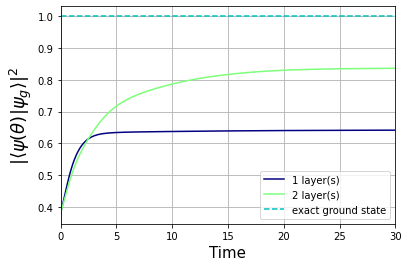

In [185]:
n = 3
colors = plt.cm.jet(np.linspace(0,1,n))

for kkk in range(2):
    plt.plot(time_domain,expt_value[kkk], color = colors[kkk],label = str(kkk+1)+" layer(s)")
plt.plot(time_domain,1.*np.ones(len(time_domain)), ls = "--", color ="c",label = "exact ground state")

plt.ylabel(r"$|\langle \psi(\theta)|\psi_g\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
plt.xlim(0,30)
#plt.ylim(0.99,1)

#plt.savefig("Imaginary_time_evolution_fidelity_over_layers_5qutrits_M=0.1.pdf")

(0.0, 30.0)

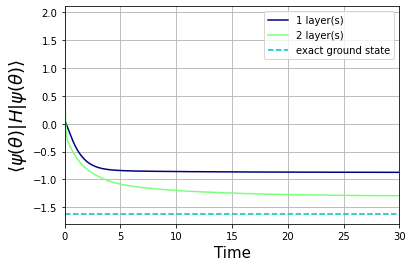

In [186]:
for kkk in range(2):
    plt.plot(time_domain,energyy[kkk], color = colors[kkk],label = str(kkk+1)+" layer(s)")
plt.plot(time_domain,eigenval[0]*np.ones(len(time_domain)), ls = "--", color ="c",label = "exact ground state")

plt.ylabel(r"$\langle \psi(\theta)|H|\psi(\theta)\rangle$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
plt.xlim(0,30)
#plt.ylim(-0.65,-0.63)

#plt.savefig("Imaginary_time_evolution_energy_over_layers_5qutrits_M=0.1.pdf")

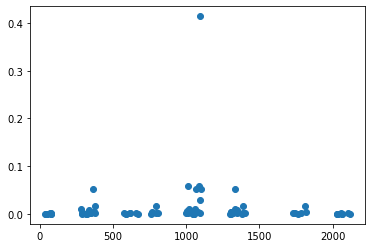

In [143]:
yy = []
xx = []
for i in range(basis.Ns):
    if np.abs(eigenvec[:,0][i])**2>=1e-4:
        yy.append(np.abs(eigenvec[:,0][i])**2) 
        xx.append(i)
plt.plot(xx,yy, "o")

###### import matplotlib.pyplot as plt
for i in range(coeff*N):
    plt.plot(time_domain, [row[i] for row in Y])
#plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
#plt.xlim(5.9,6.1)
plt.show()

In [212]:
obs = [[1.,2]]
obs_1 = [[-1.,1]]


obs_map = [
            ["z", obs], 
            ["z", obs_1], 


]

observable = hamiltonian(obs_map,dynamic_list=[],basis=basis,**no_checks)
observable_matrix = observable.toarray()
observable_matrix_p = observable_matrix
for i in range(L+1):
    observable_matrix_p = (Proj[i]+Proj_0[i])@observable_matrix_p@(Proj[i]+Proj_0[i])
    
observable_matrix = observable_matrix_p



In [214]:
def hamiltonian_evolution(theta):
    return expm(-1j*full_ham_matrix.toarray()*theta)

def hamiltonian_evolution_1(theta):
    return expm(-1j*constrained_full_ham_matrix.toarray()*theta)

In [218]:
for i in range(coeff*N):
    print(Y[0][i])

0.37141536888406607
0.6602899660443315
0.11637371823579168
0.39901353290549235
0.9247979940631299
0.026453178512319396
0.4382807802429473
0.07025615093206115
0.3606296388374573
0.8138966259351307
0.9031720383192907
0.523454217057356
0.9272695715059814
0.9827474226150743
0.2639324508516817
0.41284186279042756
0.8757225556853009
0.523982524132141
0.9490899608210723
0.6202612047452045
0.19801202641088236
0.6716191124543176


(0.0, 10.0)

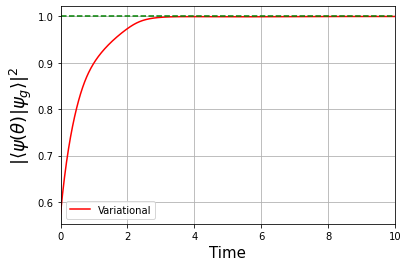

(0.0, 10.0)

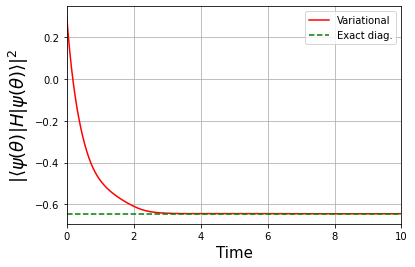

In [220]:
plt.plot(time_domain,energy, color = "red",label = "Variational")
plt.plot(time_domain,eigenval[0]*np.ones(len(time_domain)), ls = "--", color ="g", label = "Exact diag.")

plt.ylabel(r"$|\langle \psi(\theta)|H|\psi(\theta)\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
plt.xlim(0,10)
#plt.ylim(-0.65,-0.63)

#plt.savefig("Imaginary_time_evolution_energy_3qutrits_M=0.1_N=2_1.pdf")

In [221]:
print(expt_value_u[-1])

0.999481430342308


In [124]:
a = np.array([1,2,4])
ind = [1,3,5]
for i in ind:
    a = np.insert(a,i,i)
    print(a)

[1 1 2 4]
[1 1 2 3 4]
[1 1 2 3 4 5]


In [33]:
vec = np.array([1,2,3,4,5])
print(vec[-1]-vec[0])

4
